# Aprendizaje Supervisado con Scikit-Learn - Día 1

Antes que nada, vamos a comprobar las versiones de las diferentes librerías que vamos a estar utilizando a lo largo de las clases:

In [31]:
import sys
print("Python version:", sys.version)

import pandas as pd
print("pandas version:", pd.__version__)

import matplotlib
print("matplotlib version:", matplotlib.__version__)

import numpy as np
print("NumPy version:", np.__version__)

import scipy as sp
print("SciPy version:", sp.__version__)

import IPython
print("IPython version:", IPython.__version__)

import sklearn
print("scikit-learn version:", sklearn.__version__)

Python version: 3.7.6 | packaged by conda-forge | (default, Jan  7 2020, 22:33:48) 
[GCC 7.3.0]
pandas version: 0.25.3
matplotlib version: 3.1.2
NumPy version: 1.17.3
SciPy version: 1.3.1
IPython version: 7.10.1
scikit-learn version: 0.21.3


Por último, vamos a desactivar los mensajes de advertencia *`DeprecationWarnings`*, ya que no afectan en nada al código ni nuestros objetivos formativos para las clases:

In [2]:
# Importamos un filtro de warnings
from warnings import simplefilter
# Ignoramos los DeprecationWarnings, en concreto el del módulo six.py
simplefilter(action='ignore', category=DeprecationWarning)

In [3]:
# Hacemos ciertas configuraciones iniciales
%matplotlib inline
from preamble import *

## Lab 0 - Datasets de ejemplo

Una de las mejores maneras de aprender es, en general, reducir la dimensionalidad de un problema hasta comprender las cuestiones básicas y desarrollar una *intuición*.

Ésta es una técnica muy utilizada en Ciencias Físicas, donde muchas veces se estudia un modelo unidimensional y luego se generaliza, con la ayuda de herramientas matemáticas, a $n$ dimensiones.

Aquí haremos lo mismo gracias a una serie de Datasets básicos que utilizaremos en conjunto con otros reales a lo largo del curso.

### Forge Dataset
Utilizaremos un dataset llamado *Forge* para algunos ejemplos de modelos de clasificación supervisada. He aquí el dataset:

In [ ]:
# Generamos un dataset
X, y = mglearn.datasets.make_forge() # Característica, Característica
# Lo pintamos
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.legend(["Clase 0", "Clase 1"], loc=4)
plt.xlabel("Caractística 1")
plt.ylabel("característica 2")

¿Cuántos datapoints y características tiene este Dataset $X$? Utiliza Numpy para saber la respuesta, apóyate en el método `type()` de Python si necesitas saber qué métodos puedes utilizar sobre él, así como la combinación `Tab` y `Shift-Tab` para conocer la documentación de los diferentes métodos disponibles:

In [ ]:
# Escribe la línea de código abajo
print("X.shape:", X.shape)

#### Dataset Wave

Utilizaremos otro dataset llamado *Wave* para los ejemplos básicos de regresión supervisada. Igualmente, utilizamos un dataset muy sencillo, de pocas dimensiones que nos ayude a visualizar y a desarrollar una intuición sobre nuestros modelos.

In [ ]:
# Generamos un dataset
X, y = mglearn.datasets.make_wave(n_samples=40) #Inputs, Outputs
plt.plot(X, y, 'o')
plt.ylim(-3, 3)
plt.xlabel("Característica")
plt.ylabel("Objetivo")

#### Un ejemplo real: Wisconsin Breast Cancer Dataset
Scikit-learn incluye algunos datasets reales con el propósito de trabajar con ellos de manera más sencilla. Éstos se almacenan como objetos `Bunch`. Lo único que es necesario saber de estos objetos por el momento es que se comportan como diccionarios de Python, con el beneficio añadido de que los valores se pueden acceder con *dot notation*.

In [8]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
print("cancer.keys():\n", cancer.keys())

cancer.keys():
 dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])


In [ ]:
type(cancer)

In [ ]:
print("Dimensiones del dataset:", cancer.data.shape)

Cada tumor está etiquetado como *benigno* o *maligno*, y el objetivo será aprender a predecir en base a ciertas características del tejido si un tumor es benigno o maligno.

In [ ]:
print("Conteo de muestras por clase:\n",
      {n: v for n, v in zip(cancer.target_names, np.bincount(cancer.target))})

Para obtener una descripción del significado de cada una de las características, podemos usar el atributo `feature_names`:

In [ ]:
print("Nombres de las características:\n", cancer.feature_names)

#### Otro ejemplo real: Boston Housing Dataset
El objetivo de este dataset es predecir el valor medio de las casas en varios barrios de Boston en la década de los '70 usando información como la tasa de criminalidad, proximidad al río Charles, acceso a autovías, etc.

In [ ]:
from sklearn.datasets import load_boston
boston = load_boston()
print("Data shape:", boston.data.shape)

A efectos de utilizar este dataset, es mejor complementarlo considerando no sólo las 13 características iniciales, sino todos los productos entre características (llamados también *interacciones*). La generación de interacciones la haremos incrementando el grado polinómico del dataset con el transformador de Scikit Learn [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) Además, modificaremos la escala de los datos para uniformizarla y poder utilizar el concepto de medida de los datos correctamente gracias al preprocesador [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) de Scikit-Learn.

El incluir características derivadas como estas se llama **Ingeniería de características**. El dataset ampliado puede cargarse gracias a la función `load_extended_boston`.

In [ ]:
# Definimos una función en Python para encapsular la ingeniería de características que vamos a realizar sobre el dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
def load_extended_boston():
    boston = load_boston()
    X = boston.data
    # Aplicamos un MinMaxScaler para escalar las características bajo un mismo criterio
    X = MinMaxScaler().fit_transform(boston.data)
    # Finalmente, generamos interacciones entre las diferentes características.
    X = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X)
    return X, boston.target

In [ ]:
X, y = load_extended_boston()
print("X.shape:", X.shape)

## Lab 1 - k-Nearest Neighbors
### Clasificación k-NN

Usemos para empezar nuestro dataset *Forge*. Primero, separamos los datos en un set de training y de test para poder evaluar el rendimiento del modelo:

In [11]:
from sklearn.model_selection import train_test_split
X, y = mglearn.datasets.make_forge()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Lo siguiente es importar e instanciar la clase. Aquí es donde podemos poner un número de vecinos, por ejemplo, 3:

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)

Finalmente, entrenamos el modelo usando el juego de datos de entrenamiento. Esto implica almacenar el dataset para poder calcular los vecinos durante la predicción:

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
print("Predicciones sobre el juego de pruebas:", clf.predict(X_test))

In [ ]:
print("Precisión sobre el juego de pruebas: {:.2f}"
      .format(clf.score(X_test, y_test)))

### Análisis de KNeighborsClassifier

Se puede ilustrar la predicción para todos los puntos en el plano $xy$. Se usan colores en el plano de acuero con la clase predicha para el punto en cuestión. Eso permite ver la frontera de decisión y desarrollar una cierta intuición sobre el modelo en función del número de vecinos.

En el siguiente código, se generan gráficas para valores de vecinos de 1, 3 y 9:

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for n_neighbors, ax in zip([1, 3, 9], axes):
    # the fit method returns the object self, so we can instantiate
    # and fit in one line
    clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X, y)
    mglearn.plots.plot_2d_separator(
        clf, X, fill=True, eps=0.5, ax=ax, alpha=.4)
    mglearn.discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    ax.set_title("{} vecino(s)".format(n_neighbors))
    ax.set_xlabel("característica 0")
    ax.set_ylabel("característica 1")
axes[0].legend(loc=3)

**Pregunta**: ¿qué diferencias observas en la frontera de clasificación y qué puede decirse del uso de varios vecinos frente al uso de uno sólo?

<font color='grey'>
Un sólo vecino hace que la frontera de decisión se ajuste mucho a los datos de entrenamiento. Si se incrementa el número de vecinos, la frontera se suaviza.
Esto implica que con un número bajo de vecinos, el modelo es más complejo, y con un número alto, menos. Yendo a un extremo, si $k=n$, donde n es el núermo de muestras del juego de entrenamiento, todos los puntos tendrían el mismo número de vecions y la predicción sería siempre la mism: la clase más frecuente en el juego de entrenamiento.

Vamos a evaluar ahora la conexión entre complejidad y generalización usando un dataset real (Breast Cancer Dataset):

In [ ]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target,
    stratify=cancer.target, random_state=66)

training_accuracy = []
test_accuracy = []
# Probamos n_neighbors de 1 a 10
neighbors_settings = range(1, 11)

for n_neighbors in neighbors_settings:
    # Construimos el modelo
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    # Guardamos la precisión del training set
    training_accuracy.append(clf.score(X_train, y_train))
    # Guardamos la precisión de testing set (generalización)
    test_accuracy.append(clf.score(X_test, y_test))
    
plt.plot(neighbors_settings,
         training_accuracy, label="precisión training")
plt.plot(neighbors_settings, test_accuracy, label="precisión test")
plt.ylabel("Precisión")
plt.xlabel("n_neighbors")
plt.legend()

¿Reconoces las características de las curvas  de complejidad frente a precisión que vimos al principio? (Nótese que por el eje de ordenadas, la curva correspondiente al training set está invertida)

**¿Qué numero de vecinos es el mejor para obtener el mejor rendimiento del modelo?**

Como puede verse en la gráfica, obtenemos el mejor rendimiento en test para k=6, lo que nos da también la precisión que obtenemos en el dataset de training.

### Regresión k-NN
También hay una variante de regresión de k-Nearest Neighbors. De nuevo, comparemos el uso de un solo vecino frente a tres para ver la variación de las predicciones:

In [ ]:
mglearn.plots.plot_knn_regression(n_neighbors=1)

In [ ]:
mglearn.plots.plot_knn_regression(n_neighbors=3)

La implementación de kNN para regresión en Scikit-learn es muy parecida a su equivalente de clasificación. Lo hacemos aquí para el *Wave* dataset:

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

X, y = mglearn.datasets.make_wave(n_samples=40)

# Partimos el dataset wave en training y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0)

# Instanciamos el modelo y especificamos 3 vecinos
reg = KNeighborsRegressor(n_neighbors=3)
# Ajustamos el modelo usando los objetivo y datos de training
reg.fit(X_train, y_train)

In [ ]:
print("Predicciones sobre el test set:\n", reg.predict(X_test))

También podemos evaluar el modelo utilizando el método `score`, que para la regresión devuelve $R^2$ (el coeficiente de determinación, una medida de lo bueno que es un modelo de regresión que veremos en más detalle más adelante):

In [ ]:
print("Coeficiente de determinación del test set: {:.2f}".format(reg.score(X_test, y_test)))

### Análisis de KNeighborsRegressor

Para establecer el análisis, vamos a hacer una predicción de todos los posibles valores que puede tener la característica $x$ (donde $x\in[1,3000]$), y para ello creamos un dataset que tenga todos los puntos en una línea:

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
# Crear 1,000 data points, igualmente espaciados entre -3 y 3
line = np.linspace(-3, 3, 1000).reshape(-1, 1)
for n_neighbors, ax in zip([1, 3, 9], axes):
    # make predictions using 1, 3, or 9 neighbors
    reg = KNeighborsRegressor(n_neighbors=n_neighbors)
    reg.fit(X_train, y_train)
    ax.plot(line, reg.predict(line))
    ax.plot(X_train, y_train, '^', c=mglearn.cm2(0), markersize=8)
    ax.plot(X_test, y_test, 'v', c=mglearn.cm2(1), markersize=8)

    ax.set_title(
        "{} vecinos(s)\n Train score: {:.2f} Test score: {:.2f}".format(
            n_neighbors, reg.score(X_train, y_train),
            reg.score(X_test, y_test)))
    ax.set_xlabel("Característica")
    ax.set_ylabel("Objetivo")
axes[0].legend(["Predición modelo", "Training data/objetivo",
                "Test data/objetivo"], loc="best")

Como ejercicio adicional con kNNs, ábrase el fichero [kNNs-Exercise.ipynb](kNNs-Exercise.ipynb).

# Aprendizaje Supervisado con Scikit-Learn - Día 2

## Lab 2 - Modelos lineales de regresión
\begin{align*}
\end{align*}
A continuación, se muestra el gráfico del ajuste por regresión lineal de los datos del dataset *Wave*. Lo mostramos para adelantar la discusión teórica sobre el modelo, más abajo aprenderemos cómo entrenar modelos lineales.

w[0]: 0.393906  b: -0.031804


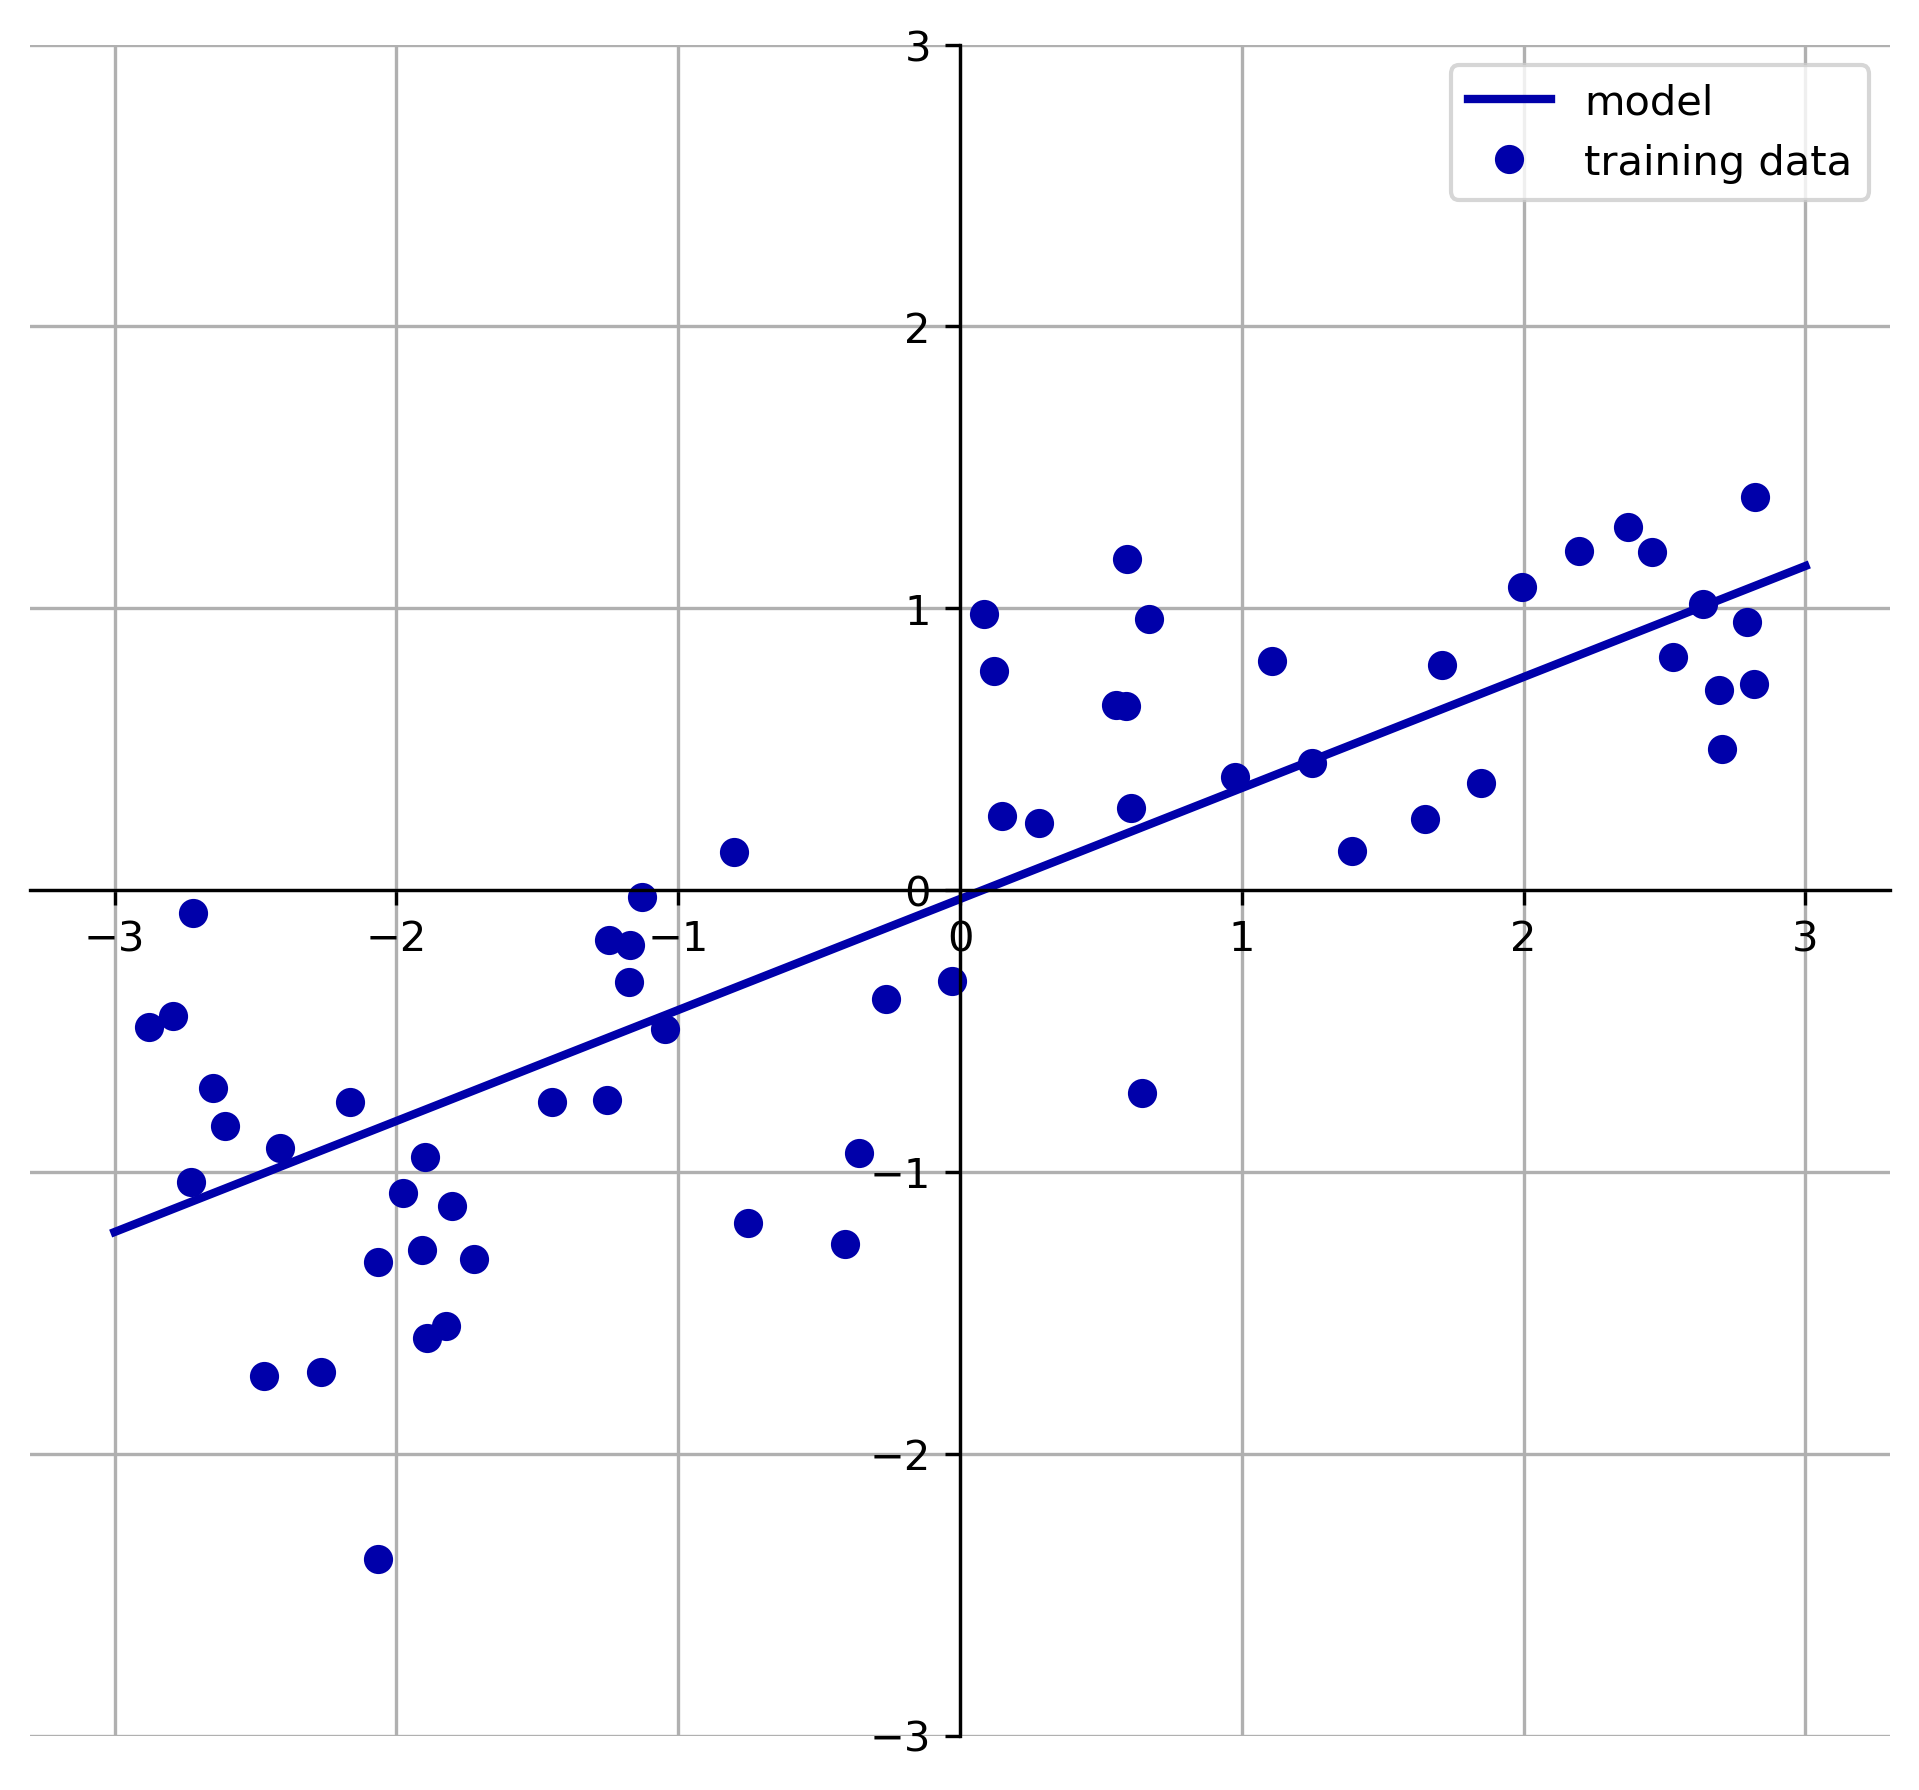

In [7]:
mglearn.plots.plot_linear_regression_wave() #modelos líneales funcionan mejor cuanto mayor numero de muestras y de caracteristicas tenga

¿Qué es $b$ y qué $w_0$? ¿Qué podemos comentar comparando con el regresor kNN que vimos antes?

### Regresión lineal, alias Ordinary Least Squares (OLS)

Generamos el código que produce la gráfica que aparece más arriba:

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
# Hacemos un dataset tipo wave con 60 muestras
X, y = mglearn.datasets.make_wave(n_samples=60)
# Hacemos el split, con un random_state=42
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

# Por último, instanciamos y entrenamos el modelo
lr = LinearRegression().fit(X_train,y_train)


Scikit-learn almacena siempre los datos derivados del entrenamiento de un modelo en atributos que terminan en guión bajo. En este caso, podemos consultar los pesos y el corte a través de las variables `coef_` y `intercept_`:

In [11]:
# Muestra ambas variables para el modelo que acabamos de entrenar
print('lr.coef_:',lr.coef_)
print('lr.intercept_', lr.intercept_)

lr.coef_: [0.394]
lr.intercept_ -0.03180434302675973


In [ ]:
#esta es la recta

Echemos un vistazo al rendimiento en el training set y el test set a través de $R^{2}$:

In [14]:
print("Training set score: {:.2f}".format(lr.score(X_train,y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test,y_test)))

Training set score: 0.67
Test set score: 0.66


In [ ]:
#situación de underfitting, no estamos generalizando bien, en un modelo lineal no hay peligro
# de overfitting


El $R^2$ de test no es demasiado bueno, pero ambos se parecen.

**¿Qué significa esto?**

**¿Qué ocurriría si tuviésemos datos de más dimension
es?**


**Ejercicio**

Veamos cómo se comporta OLS sobre un dataset como Boston Housing, que tiene mayor dimensionalidad (106 características). La manera de hacerlo es igual que en una dimensión:

In [18]:

X,y=mglearn.datasets.load_extended_boston()
# Cargamos el dataset con la herramienta de carga de Scikit-Learn
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

# Creamos datasets de entrenamiento y pruebas

# Entrenamos el modelo
lr = LinearRegression().fit(X_train,y_train)


Ahora mostramos el score:

In [19]:
print("Training set score: {:.2f}".format(
    lr.score(X_train,y_train)))
print("Test set score: {:.2f}".format(
    lr.score(X_test,y_test)))

Training set score: 0.94
Test set score: 0.78


$R^2$ es ahora bueno en el training set, pero mucho peor en el test set.

**¿Qué significa esto?** Hay posibilidad de estar haciendo overfitting. Puedo deteriorar el modelo yo, hacerlo más complejo, para solucionar el problema de overfitting, deterioro consciente, para generalizar mejor, para esto se usa el siguiente tipo de regresión

### Regresión contraída, de Tikhonov, o *Ridge*

Veamos cómo funciona en el dataset Boston Housing con Scikit-Learn:

In [20]:
from sklearn.linear_model import Ridge

ridge = Ridge().fit(X_train,y_train)
print("Training set score: {:.2f}".format(
    ridge.score(X_train,y_train)))
print("Test set score: {:.2f}".format(
    ridge.score(X_test,y_test)))

Training set score: 0.87
Test set score: 0.81


In [21]:
#generalizamos mejor al haber introducido complejidad, reducimos el overfitting y 
#mejora la precisión del test

**Discutimos los resultados**

**Ejercicio: vuelve a entrenar un Rigde sobre Boston Housing, pasando un valor de alpha = 10, (el valor por defecto es 1) y muestra los valores de $R^2$ para training y test**

In [22]:
ridge10 = Ridge(alpha=10).fit(X_train,y_train)
print("Training set score: {:.2f}".format(
    ridge10.score(X_train,y_train)))
print("Test set score: {:.2f}".format(
    ridge10.score(X_test,y_test)))

Training set score: 0.77
Test set score: 0.73


In [ ]:
#conforme aumentamos valor de alpha restringimos más el modelo, 
#conforme se acerca a cero lo restringimos menos

**Ejercicio: Haz lo mismo pasando un valor de alpha = 0.1, y muestra los valores de $R^2$ para training y test**

In [23]:
ridge01 = Ridge(alpha=0.1).fit(X_train,y_train)
print("Training set score: {:.2f}".format(
    ridge01.score(X_train,y_train)))
print("Test set score: {:.2f}".format(
    ridge01.score(X_test,y_test)))

Training set score: 0.92
Test set score: 0.82


In [24]:
#mas rendimiento si reduces valor de alfa

**Pregunta: ¿qué funciona mejor y cómo podríamos intentar mejorarlo?**

Pintamos en un gráfico los coeficientes para los tres valores de $\alpha$:

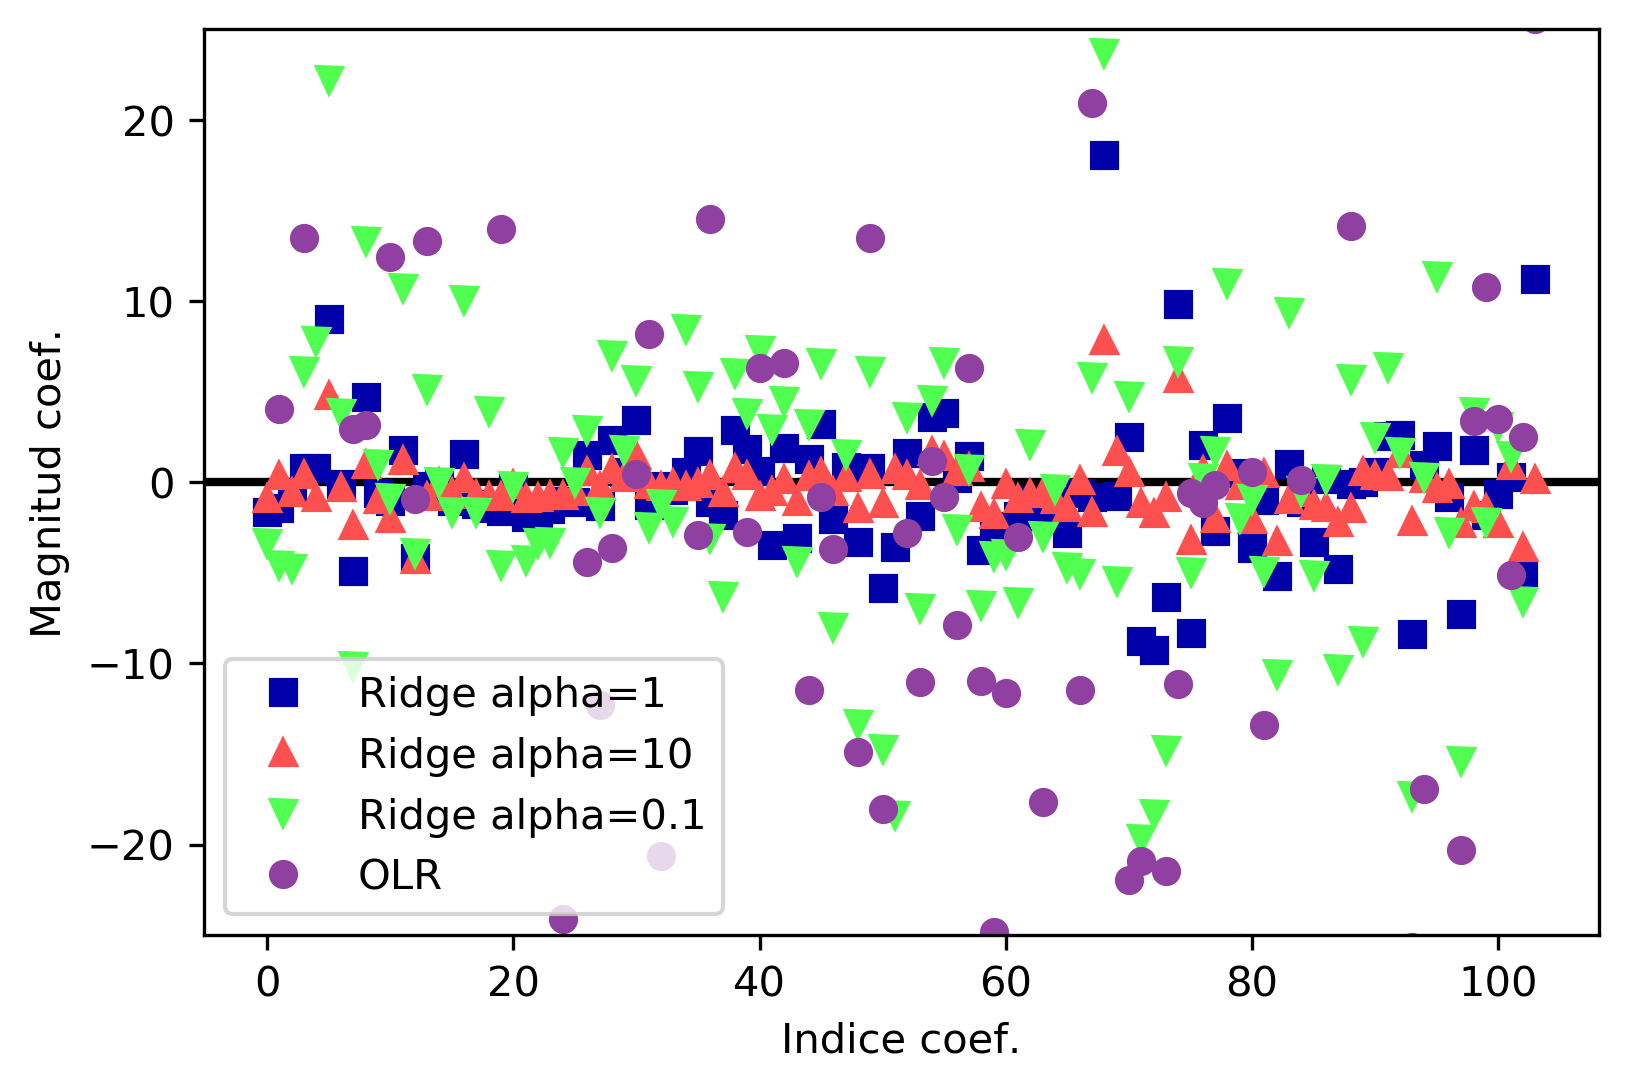

In [25]:
plt.plot(ridge.coef_, 's', label="Ridge alpha=1")
plt.plot(ridge10.coef_, '^', label="Ridge alpha=10")
plt.plot(ridge01.coef_, 'v', label="Ridge alpha=0.1")

plt.plot(lr.coef_, 'o', label="OLR")
plt.xlabel("Indice coef.")
plt.ylabel("Magnitud coef.")
xlims = plt.xlim()
plt.hlines(0, xlims[0], xlims[1])
plt.xlim(xlims)
plt.ylim(-25, 25)
plt.legend()

**Discusión**

Otra manera de entender la influencia de la regularización de los pesos es fijar $\alpha$ e ir cambiando la cantidad de datos en el training dataset. Eso es lo que puede verse en el gráfico que sigue:

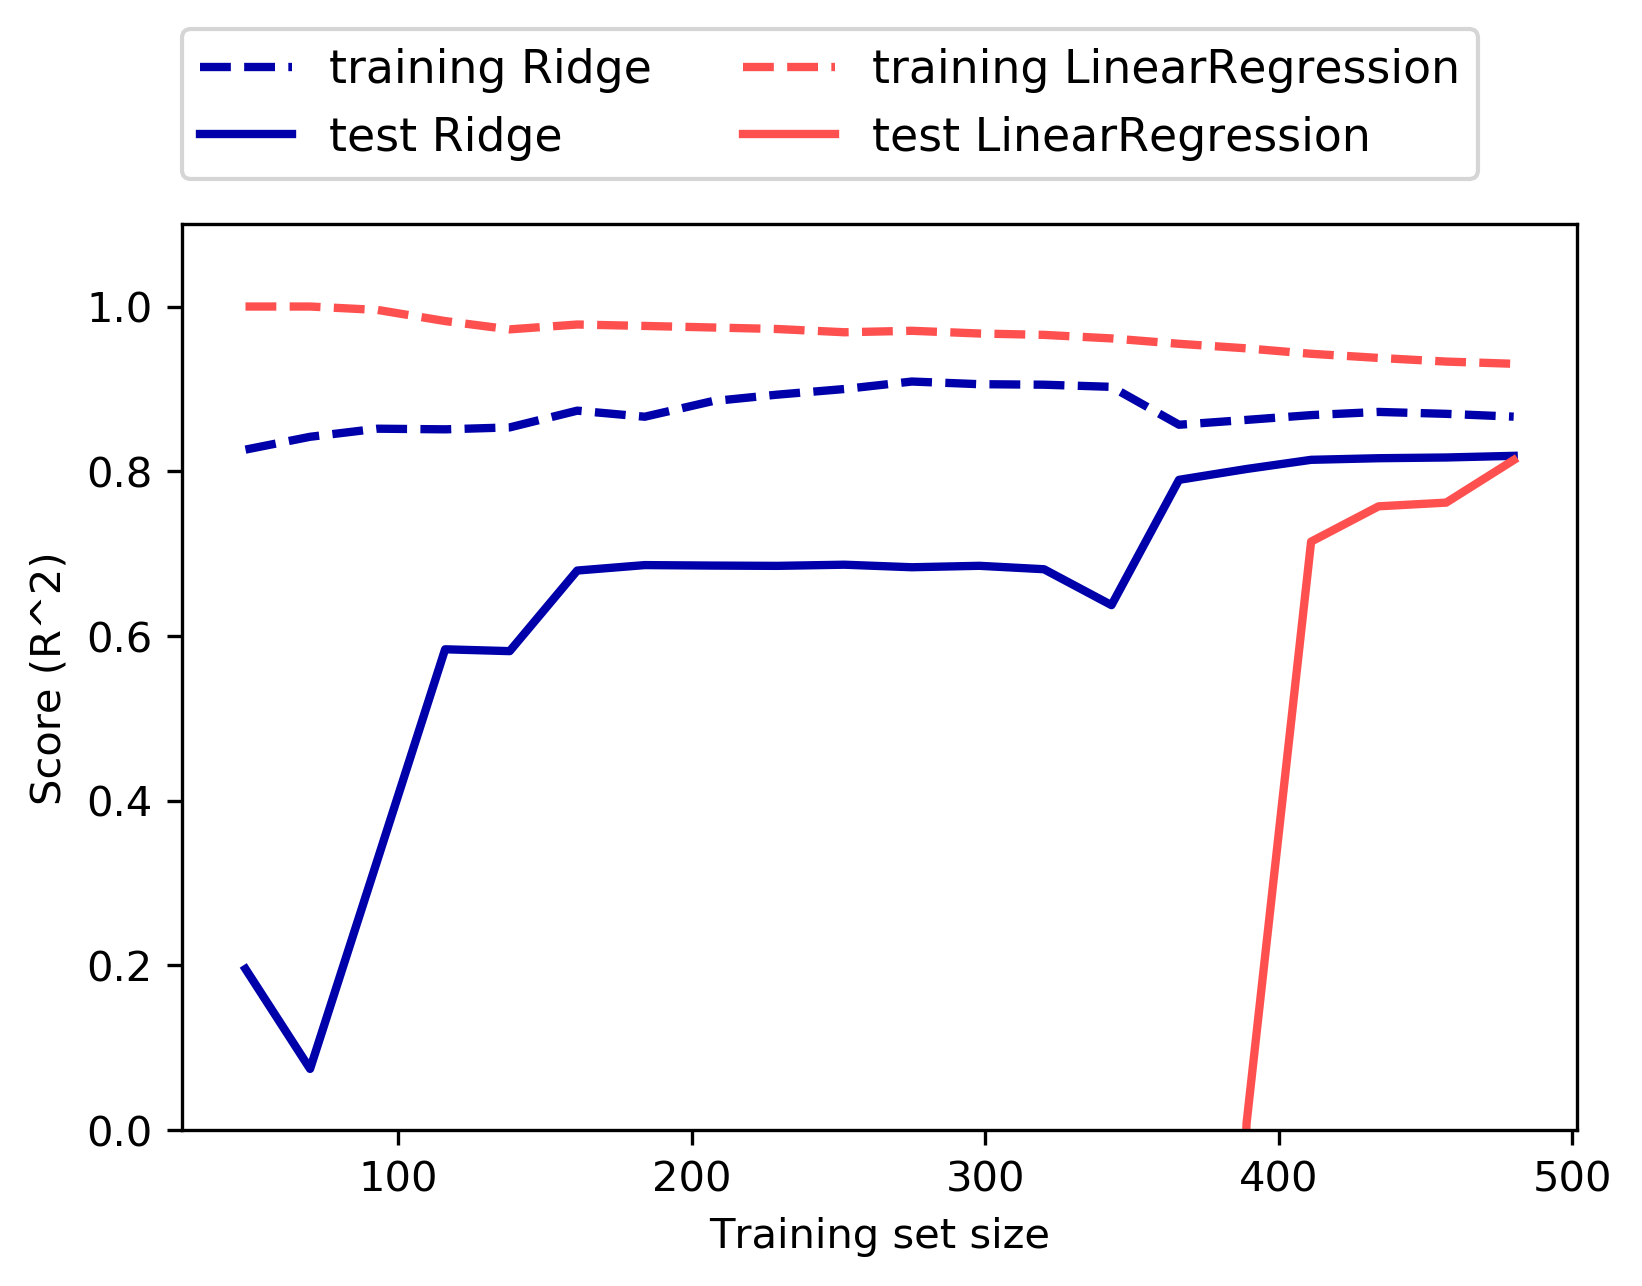

In [26]:
mglearn.plots.plot_ridge_n_samples()

In [ ]:
#a partir de 500 las linear regression convergen, quuiere decir que cuando tenemos un numero
#alto de datos funciona muy bien la regularización ridge cuando tenemos pocos datos

**Discusión**

### Regresión LASSO (Least Absolute Shrinkage and Selection Operator)

Vamos a aplicar la técnica LASSO al dataset de Boston Housing:Va a reducir caracteristicas a 0, va a reducir el numero de caracteristicas y se va a concentrar el peso en otras, es una regresión más radical, generalmente porque intuyes que hay caracteristicas con mucha importancia, esto  lo defines por intuición o por el proceso previo de tratado de datos que te lo indican. 
Intuimos que hay caracteristicas mas importantes porque se ve que tienen mas peso, con este modelo selecciona las que mas peso tienen, las que mas infuencias tienen sobre el modelo, elimina primero las que no influyen sobre el modelo

In [27]:
from sklearn.linear_model import Lasso

lasso = Lasso().fit(X_train,y_train)
print("Training set score: {:.2f}".format(
    lasso.score(X_train,y_train)))
print("Test set score: {:.2f}".format(
    lasso.score(X_test,y_test)))
# Suma las características que sean distintas de cero
print("Características usadas:", np.sum(lasso.coef_ !=0))

Training set score: 0.27
Test set score: 0.26
Características usadas: 3


In [ ]:
solo 3 caracteristicas usadas de 106, nos hemos pasado, alpha tb esta siendo 1, vamos 
a cambiarlo  En funcion del alpha que usamos dejamos mas o menos caracteristicas fuera

**Discusión**

In [28]:
# Decrementamos el valor de alpha a 0.01
# Incrementamos el número de "max_iter" a 10000
# De otra forma, el modelo nos advertirá de que deberíamos incrementarlo.
lasso001= Lasso(alpha=0.01,max_iter=10000).fit(X_train,y_train)
print("Training set score: {:.2f}".format(
    lasso001.score(X_train,y_train)))
print("Test set score: {:.2f}".format(
    lasso001.score(X_test,y_test)))
# Suma las características que sean distintas de cero
print("Características usadas:", np.sum(lasso001.coef_ !=0))

Training set score: 0.89
Test set score: 0.80
Características usadas: 34


**Discusión**


In [30]:
# Probamos con un alpha de 0001
lasso0001= Lasso(alpha=0.001,max_iter=100000).fit(X_train,y_train)
print("Training set score: {:.2f}".format(
    lasso0001.score(X_train,y_train)))
print("Test set score: {:.2f}".format(
    lasso0001.score(X_test,y_test)))
# Suma las características que sean distintas de cero
print("Características usadas:", np.sum(lasso0001.coef_ !=0))

Training set score: 0.93
Test set score: 0.82
Características usadas: 73


In [ ]:
He ajustado más el modelo y me está funcionando mejor, pero no quiero que el modelo
memorice los datos, overfitting,. Depende de los datos esta mejora del 2% usando 38 
caracteristicas más, te puede merecer mucho la pena(depende del negocio) o no
te interese nada, quiza tenga un coste computacional muy alto y no te convenga.

Una vez más, podemos pintar los coeficientes de los modelos anteriores con valores distintos de `alpha`:

Text(0, 0.5, 'Magnitud del coeficiente')

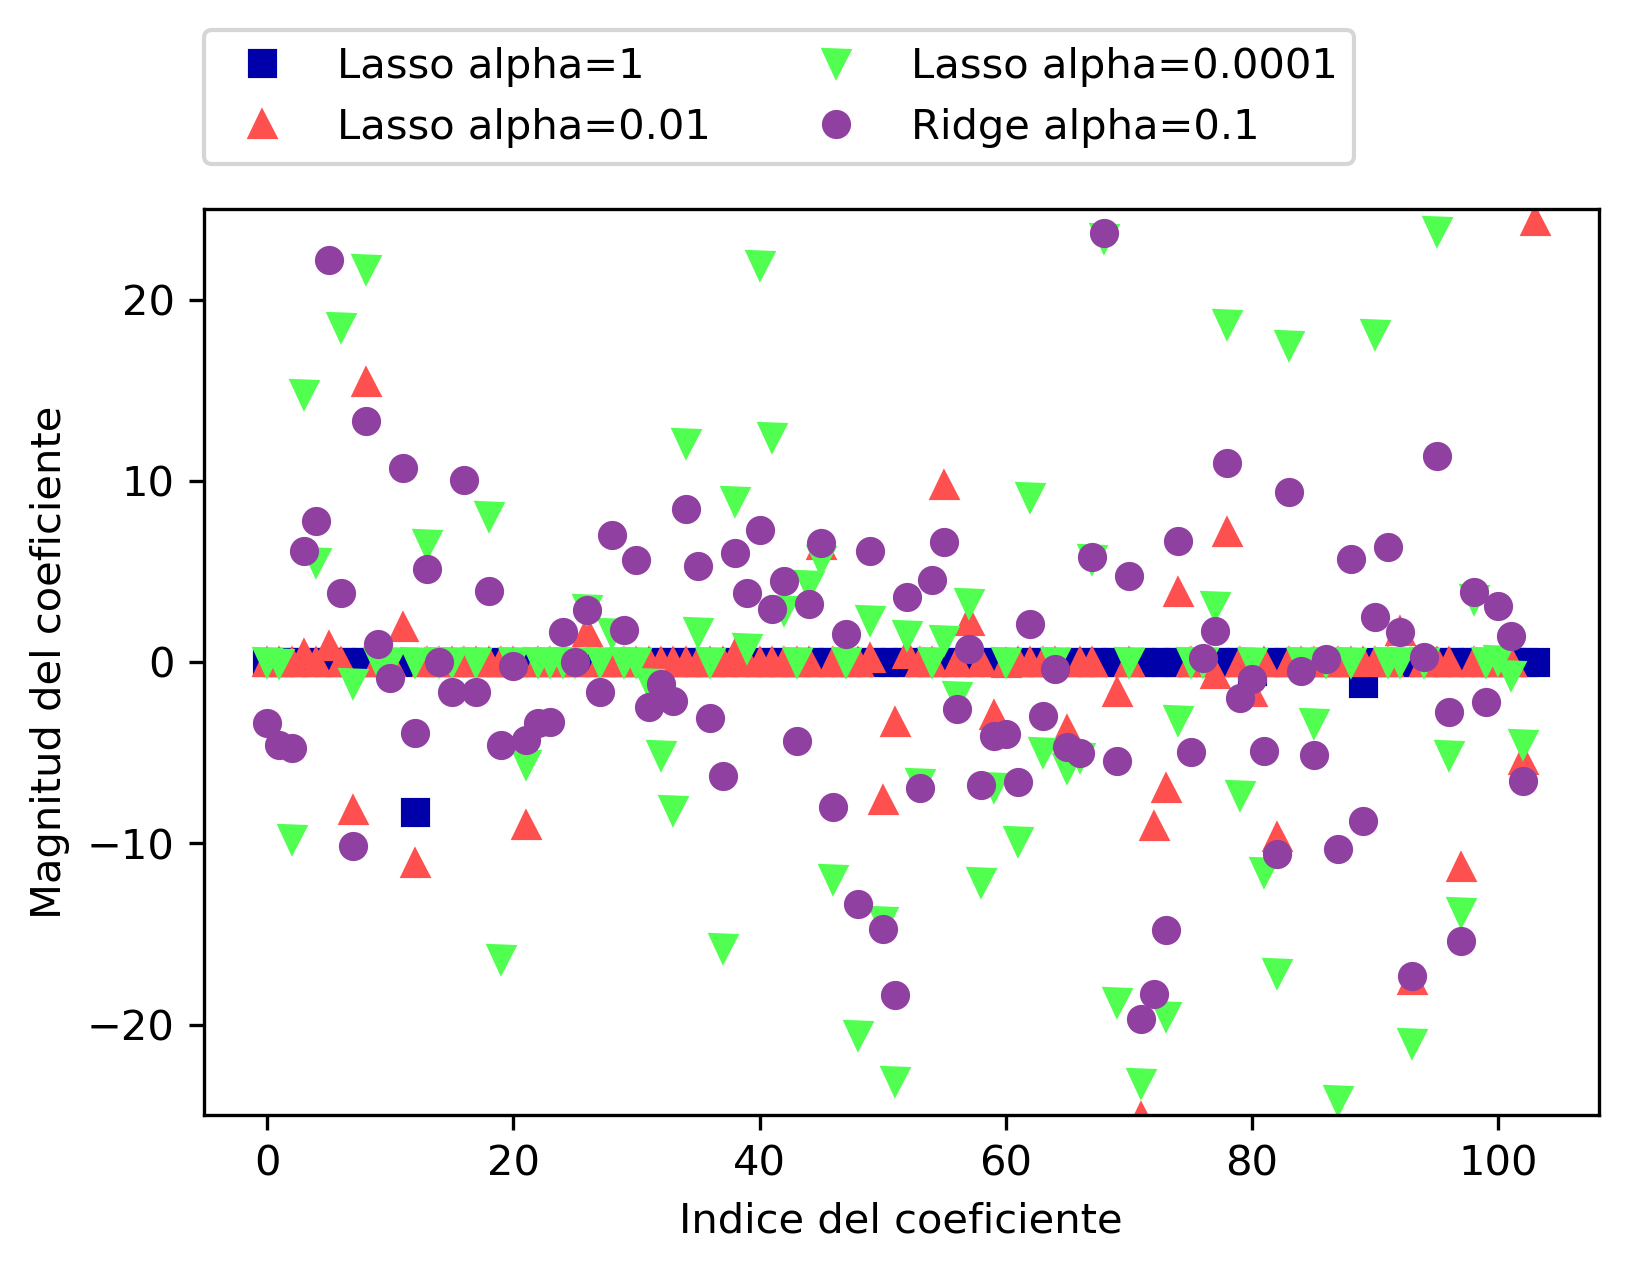

In [32]:
plt.plot(lasso.coef_, 's', label="Lasso alpha=1")
plt.plot(lasso001.coef_, '^', label="Lasso alpha=0.01")
plt.plot(lasso0001.coef_, 'v', label="Lasso alpha=0.0001")

plt.plot(ridge01.coef_, 'o', label="Ridge alpha=0.1")
plt.legend(ncol=2, loc=(0, 1.05))
plt.ylim(-25, 25)
plt.xlabel("Indice del coeficiente")
plt.ylabel("Magnitud del coeficiente")

In [ ]:
esto marca los pesos de cada caracteristica, los que mete en cero son los que elimina
en LASSO
Hay que quedarse en que estos dos modelos son buenos para un pequeño numero de datos

**Discusión**

## Lab 3 - Modelos lineales de clasificación

\begin{align*}
\end{align*} Para empezar, apliquemos los modelos `LogisticRegression` y `LinearSVC` al dataset modelo `forge`, y visualicemos el límite de decisión para ambos: 

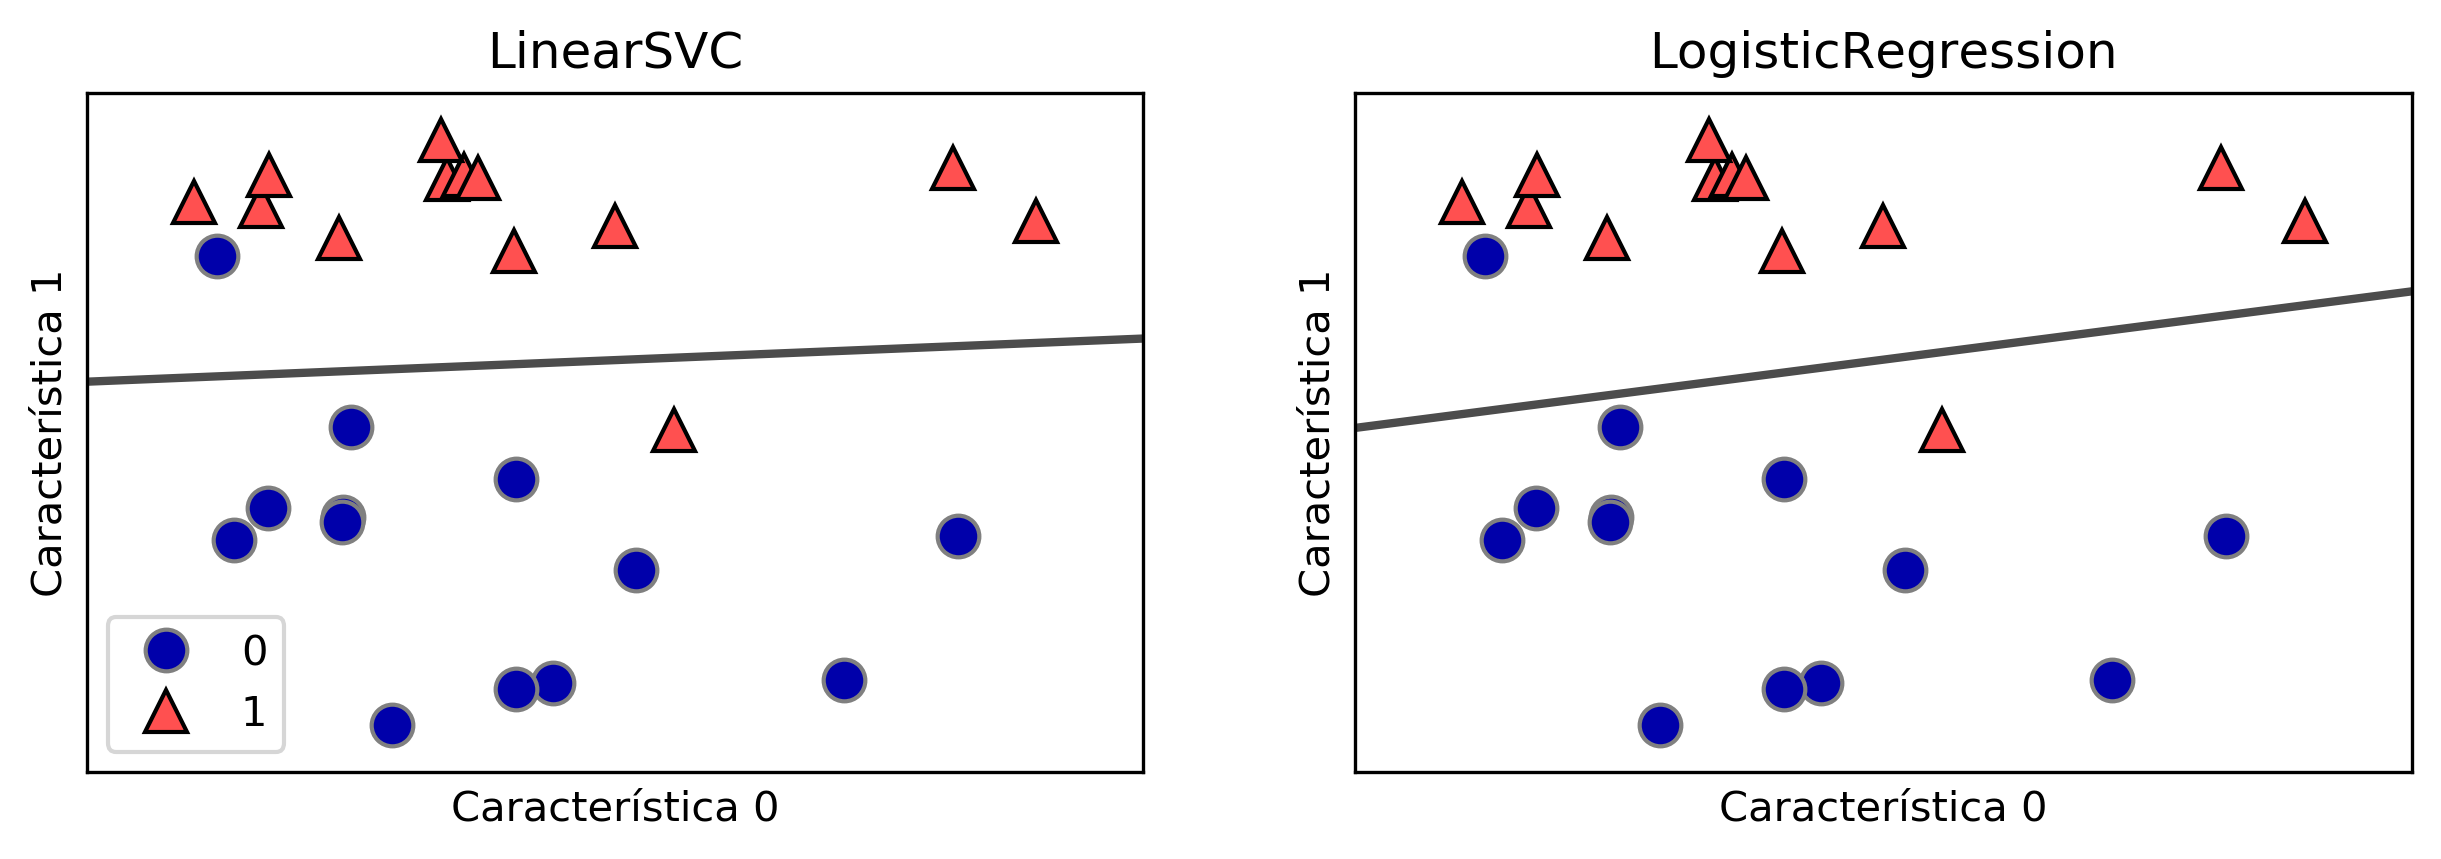

In [33]:
# Importamos paquetes
from sklearn.linear_model import LogisticRegression
from sklearn.svm  import LinearSVC


# Importamos forge dataset
X,y=mglearn.datasets.make_forge()#data set modelo para clasificaciones

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

for model, ax in zip([LinearSVC(max_iter=10000),LogisticRegression(solver='liblinear')],
                     axes):
    # Entrenamos el modelo
    clf = model.fit(X,y)
    mglearn.plots.plot_2d_separator(clf, X, fill=False, eps=0.5,
                                    ax=ax, alpha=.7)
    mglearn.discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    ax.set_title(clf.__class__.__name__)
    ax.set_xlabel("Característica 0")
    ax.set_ylabel("Característica 1")
axes[0].legend()

**Discusión**

In [ ]:
Vamos a modificar el modelo para tener una capacidad de ajuste sobre el modelo y hacerlo
más preciso, y a que generalice mejor
SUbida de C ajustaremos mejor a training
con bajada de c estamos reduciendo los pesos que tienen los pesos sobre las caracteristicas
y no funciona tan bien

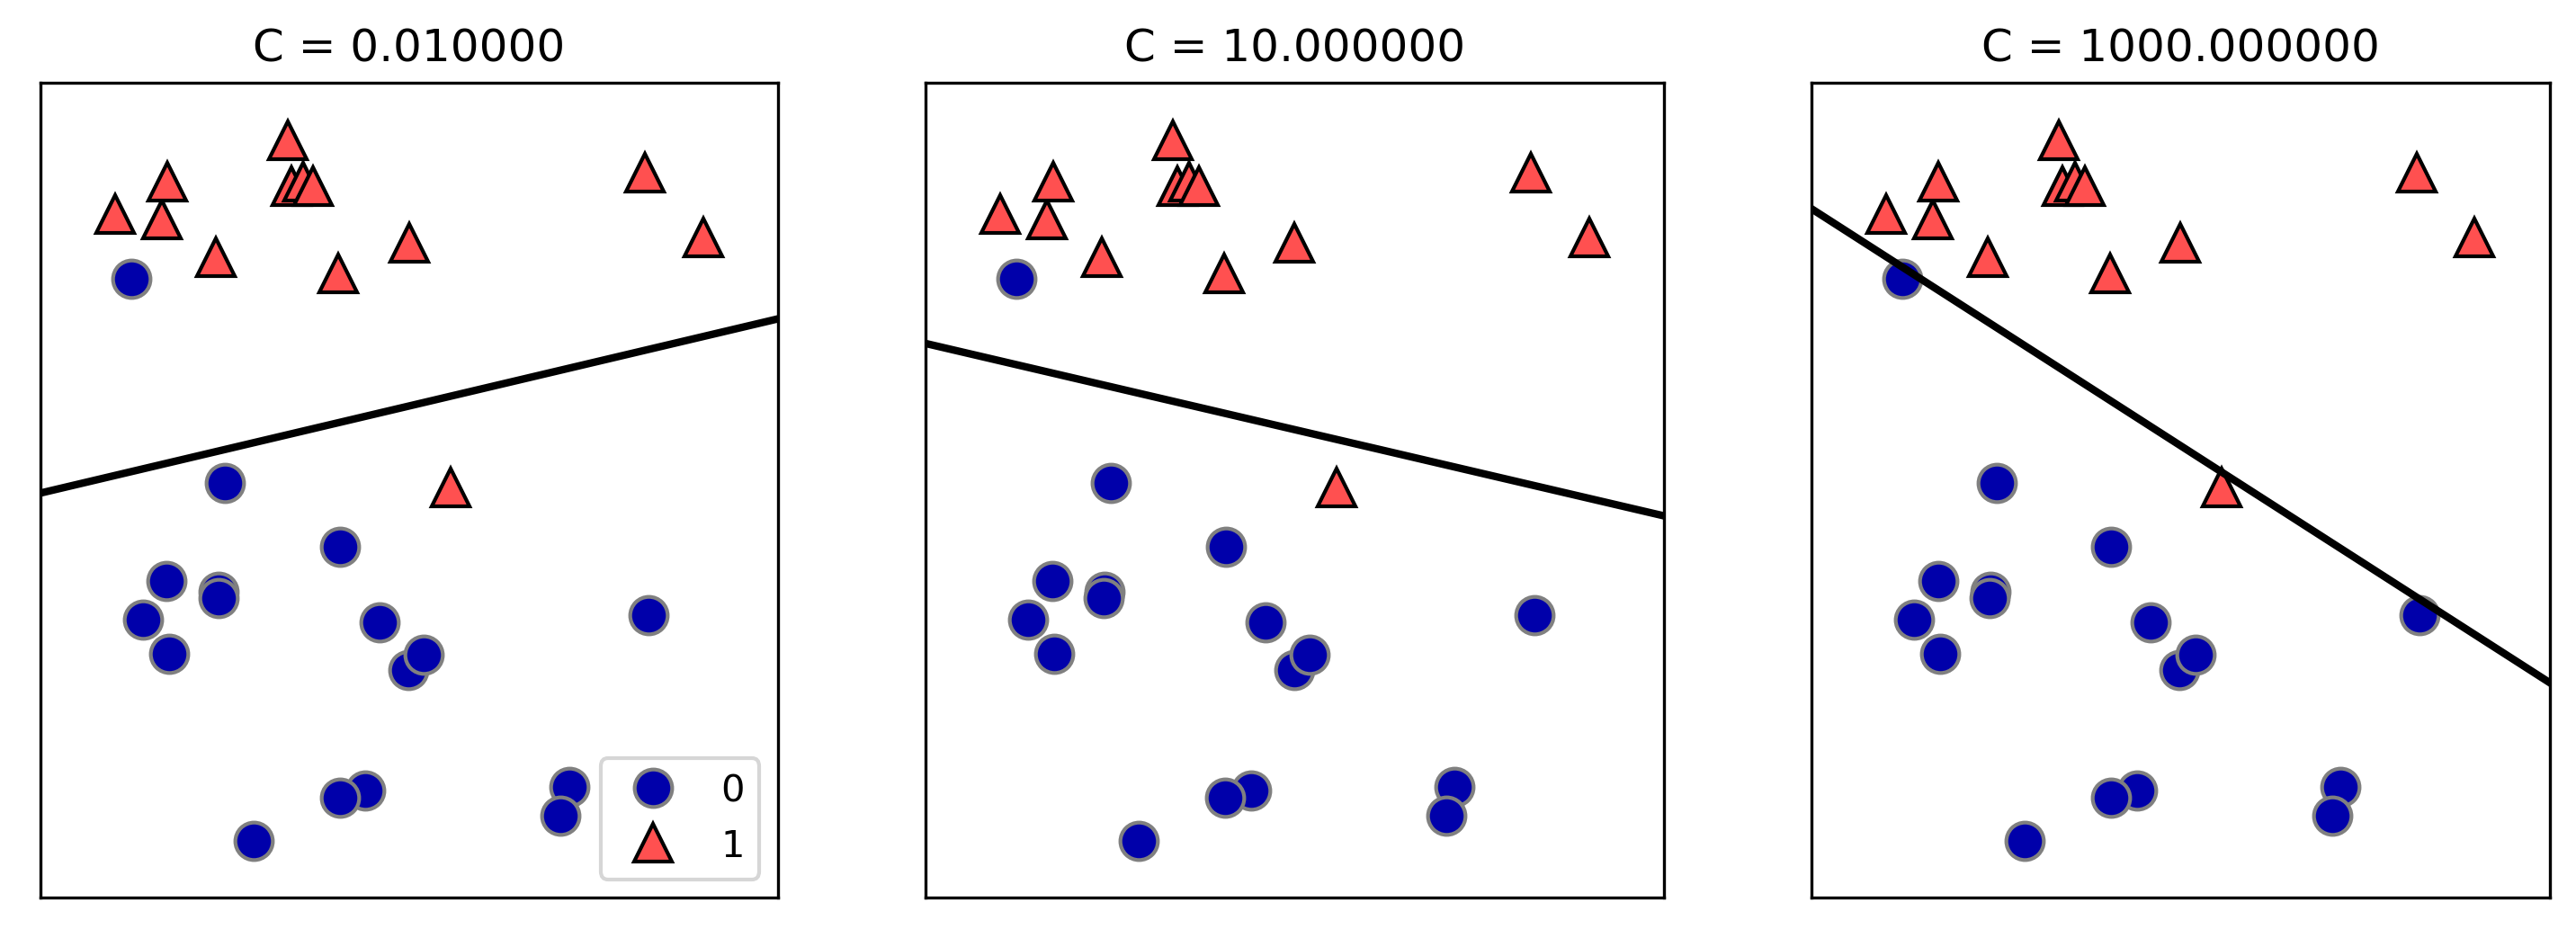

In [34]:
mglearn.plots.plot_linear_svc_regularization()

In [ ]:
EL tercer grafico esta lo más ajustado posible(Cmayor)
El primero generaliza mejor

**Discusión**

Veamos cómo se comporta la regresión logística en el dataset de cáncer de mama:

In [38]:
# Carga
from sklearn.datasets import load_breast_cancer
cancer=load_breast_cancer()

# Parte los datasets
X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,stratify=cancer.target,random_state=42)

# Instancia y entrena el modelo
logreg = LogisticRegression(solver='liblinear').fit(X_train,y_train)
print("Training set score: {:.3f}".format(logreg.score(X_train,y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test,y_test)))

Training set score: 0.953
Test set score: 0.958


**Discusión**

In [ ]:
C por defecto es 1, C tb es la modificació nde los pesos de las caracteristicas

In [39]:
# Prueba con C=100
logreg100 = LogisticRegression(solver='liblinear',C=100).fit(X_train,y_train)
print("Training set score: {:.3f}".format(logreg100.score(X_train,y_train)))
print("Test set score: {:.3f}".format(logreg100.score(X_test,y_test)))

Training set score: 0.967
Test set score: 0.965


In [ ]:
Es muy precisa, hemos mejorado el modelo, han subido el training y el test

**Discusión**

In [40]:
# Prueba con C=0.01 
logreg001 = LogisticRegression(solver='liblinear',C=0.01).fit(X_train,y_train)
print("Training set score: {:.3f}".format(logreg001.score(X_train,y_train)))
print("Test set score: {:.3f}".format(logreg001.score(X_test,y_test)))

Training set score: 0.934
Test set score: 0.930


In [ ]:
generalizamos mejor, porque training es mayor, pero hemos perdido precision

**Discusión**

Finalmente, echemos un vistazo al os coeficientes(los pesos de las caracteristicas) aprendidos por el modelo con tres valores diferentes de $C$:

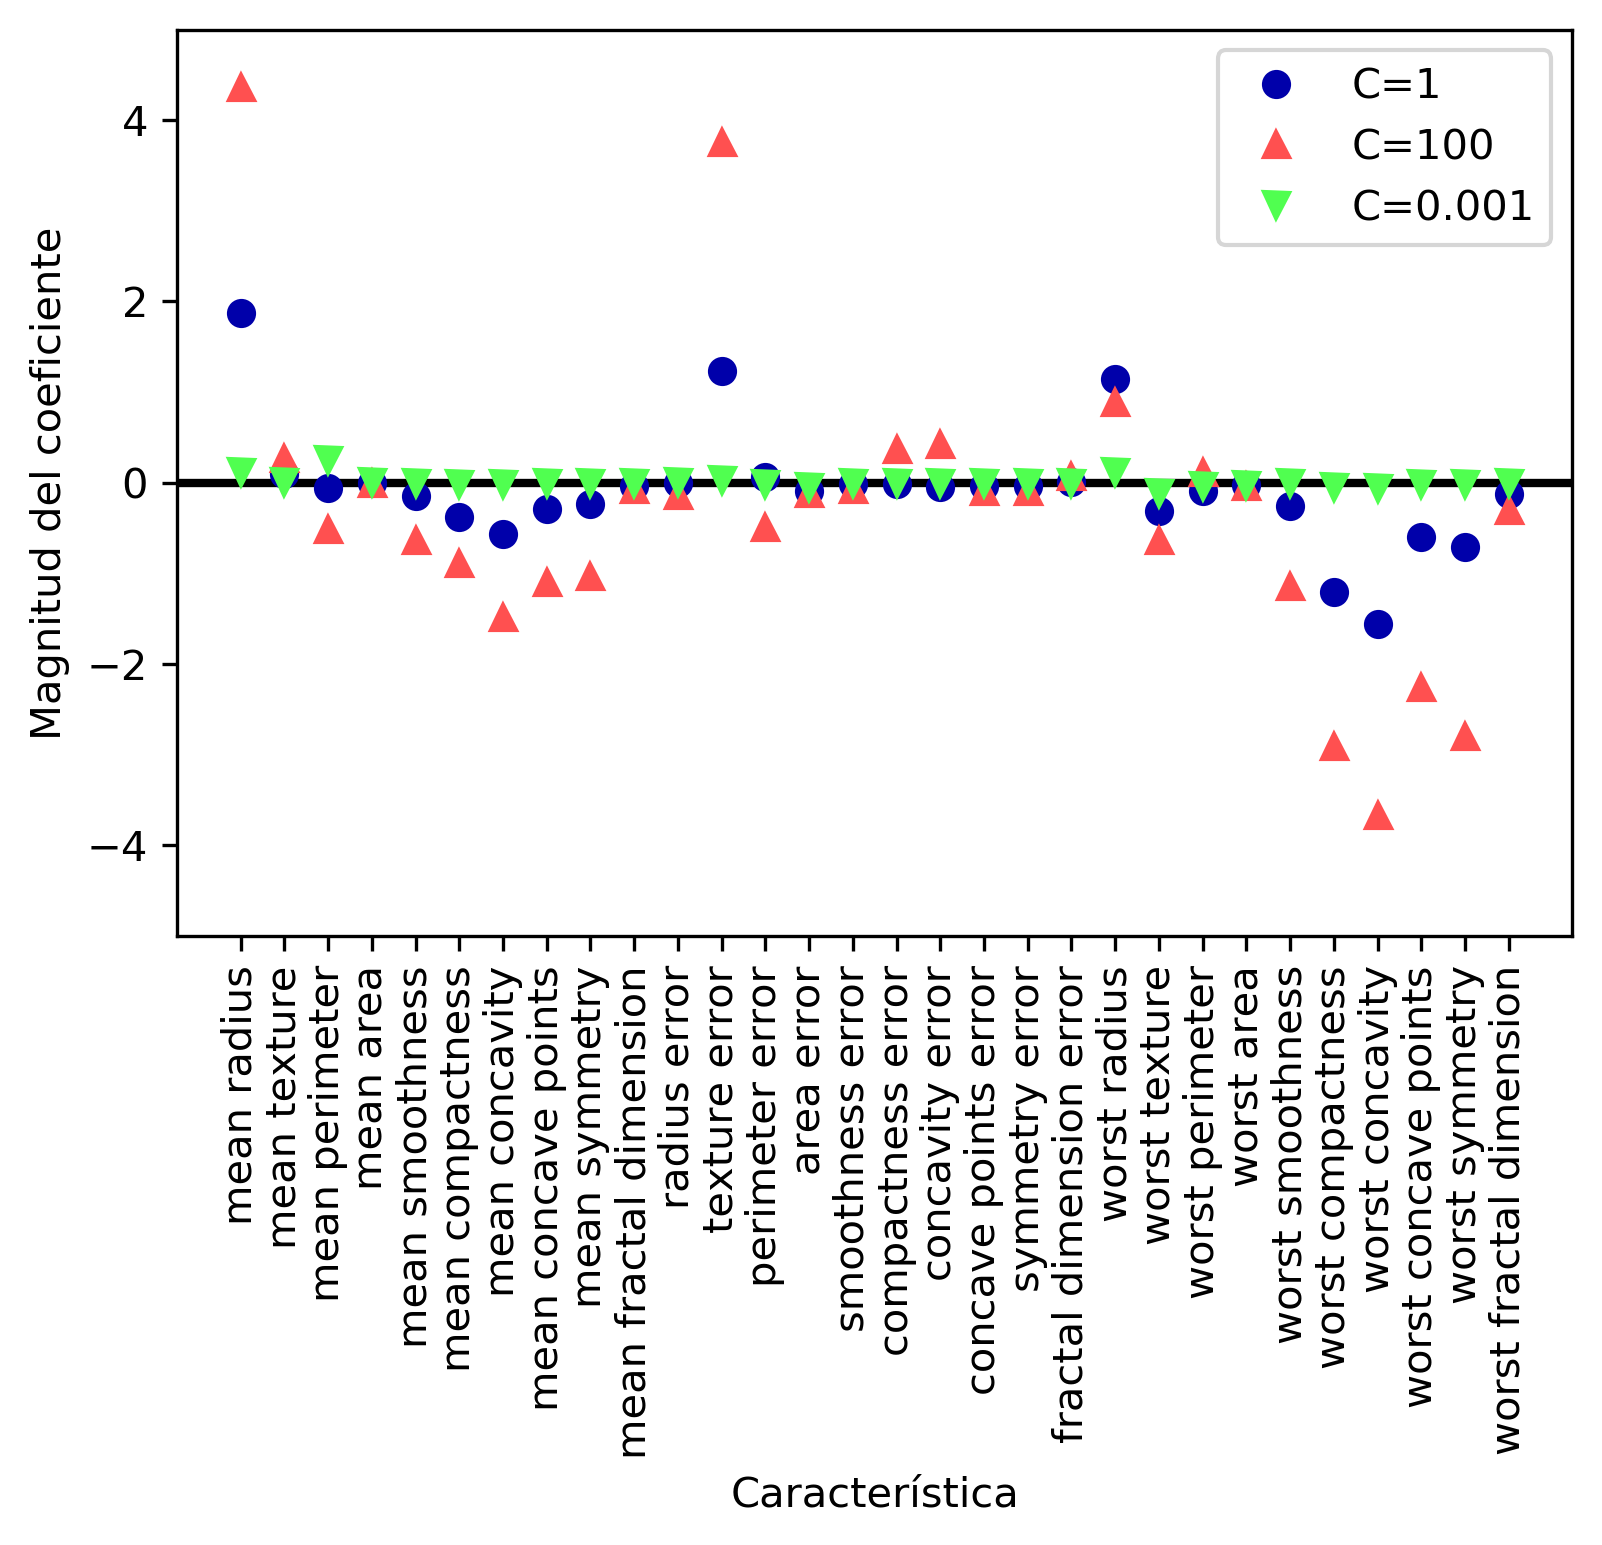

In [41]:
plt.plot(logreg.coef_.T, 'o', label="C=1")
plt.plot(logreg100.coef_.T, '^', label="C=100")
plt.plot(logreg001.coef_.T, 'v', label="C=0.001")
plt.xticks(range(cancer.data.shape[1]),
           cancer.feature_names, rotation=90)
xlims = plt.xlim()
plt.hlines(0, xlims[0], xlims[1])
plt.xlim(xlims)
plt.ylim(-5, 5)
plt.xlabel("Característica")
plt.ylabel("Magnitud del coeficiente")
plt.legend()

In [ ]:
Mapa de los pesos de las caracteristicas cuanto mas bajo mas peso pierden las 
caracteristicas. Texture error y mean radius (azul) 
tienen mucho peso ,es el resultado claro a sacar de esto
Mean perimeter en función de C es positiva y negativa
Este modelo no es muy bien interpretable, porque no queda claro, en función de C, que
caracteristicas son más importantes, estos modelos L2 son menos interpretables. 
De ahí lo de debajo:

**Discusión**

Si quisiésemos tener un modelo más fácilmente interpretable, una regularización de tipo $L1$ ayuda, ya que limita al modelo a usar sólo algunas características. He aquí un gráfico de los coeficientes y las precisiones para un modelo $L1$:

Precisión (Training) para Logistic Reg. L1 con C=0.001: 0.96
Precisión (Test) para Logistic Reg. L1 con C=0.001: 0.96
Precisión (Training) para Logistic Reg. L1 con C=1.000: 0.96
Precisión (Test) para Logistic Reg. L1 con C=1.000: 0.96
Precisión (Training) para Logistic Reg. L1 con C=100.000: 0.96
Precisión (Test) para Logistic Reg. L1 con C=100.000: 0.96


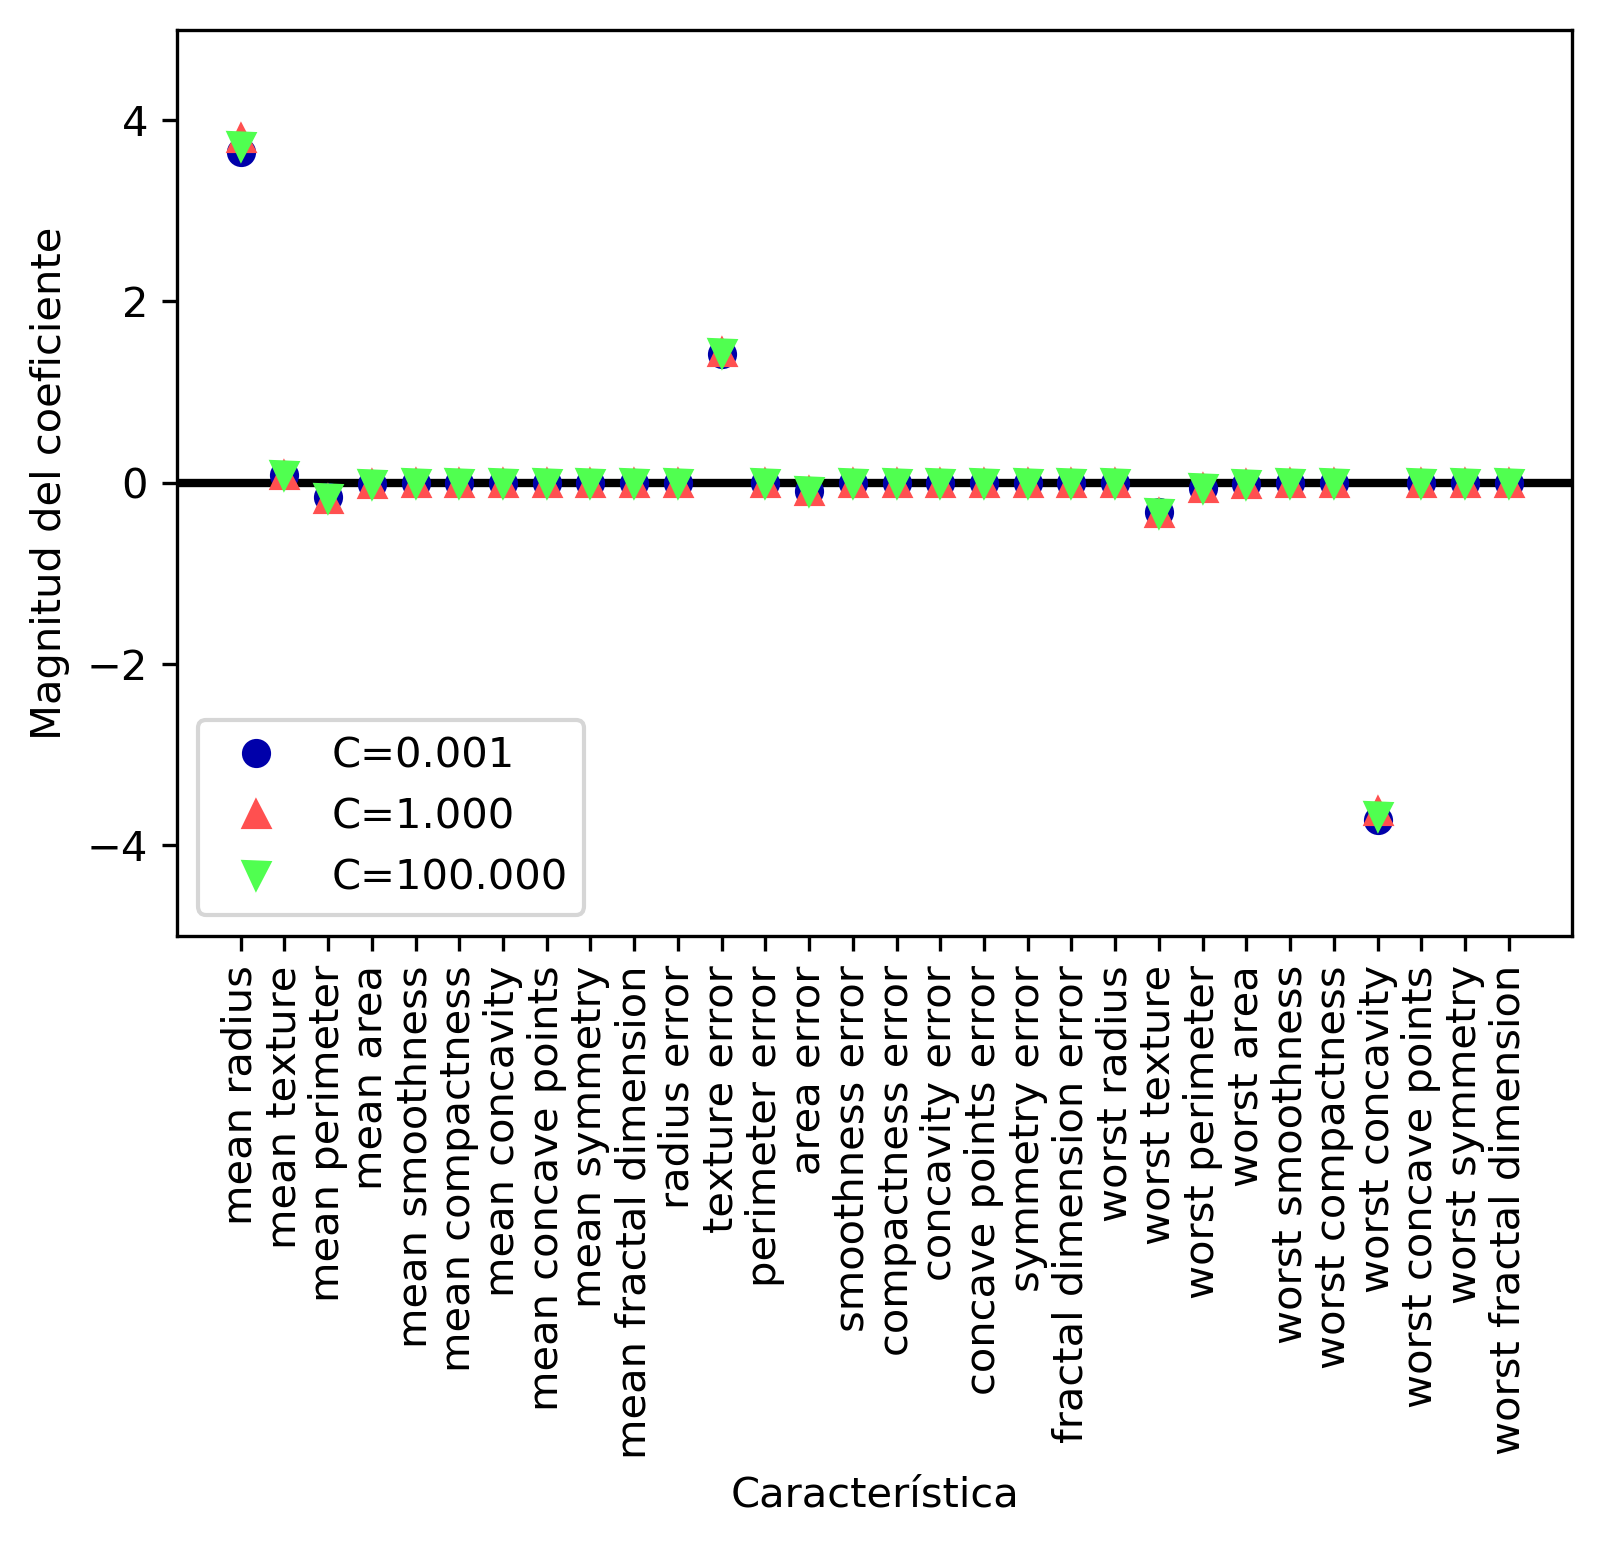

In [44]:
for C, marker in zip([0.001, 1, 100], ['o', '^', 'v']):
    # Entrenamos un modelo con L1
    lr_l1 = LogisticRegression(max_iter=10000,solver='liblinear',penalty='l1').fit(X_train,y_train)
    print("Precisión (Training) para Logistic Reg. L1 con C={:.3f}: {:.2f}".format(
          C, lr_l1.score(X_train, y_train)))
    print("Precisión (Test) para Logistic Reg. L1 con C={:.3f}: {:.2f}".format(
          C, lr_l1.score(X_test, y_test)))
    plt.plot(lr_l1.coef_.T, marker, label="C={:.3f}".format(C))

plt.xticks(
    range(cancer.data.shape[1]), cancer.feature_names, rotation=90)
xlims = plt.xlim()
plt.hlines(0, xlims[0], xlims[1])
plt.xlim(xlims)
plt.xlabel("Característica")
plt.ylabel("Magnitud del coeficiente")

plt.ylim(-5, 5)
plt.legend(loc=3)

In [ ]:
esto indica un modelo mucho mas interpretable, nos confirma que mean radius y texture error
y worst concavity son caracteristicas diferenciadoras por su peso, el modelo tiene que ser
ademas de interpretable preciso, como es el caso, 96%

**Discusión**

### Modelos lineales de clasificación multiclase
\begin{align*}
\end{align*}

Vamos a aplicar la técnica *one-vs-rest* a un dataset sencillo con tres clases. Usamos aquí un dataset bidimensional, al que cada clase se obtiene a partir de datos de una distribución normal:

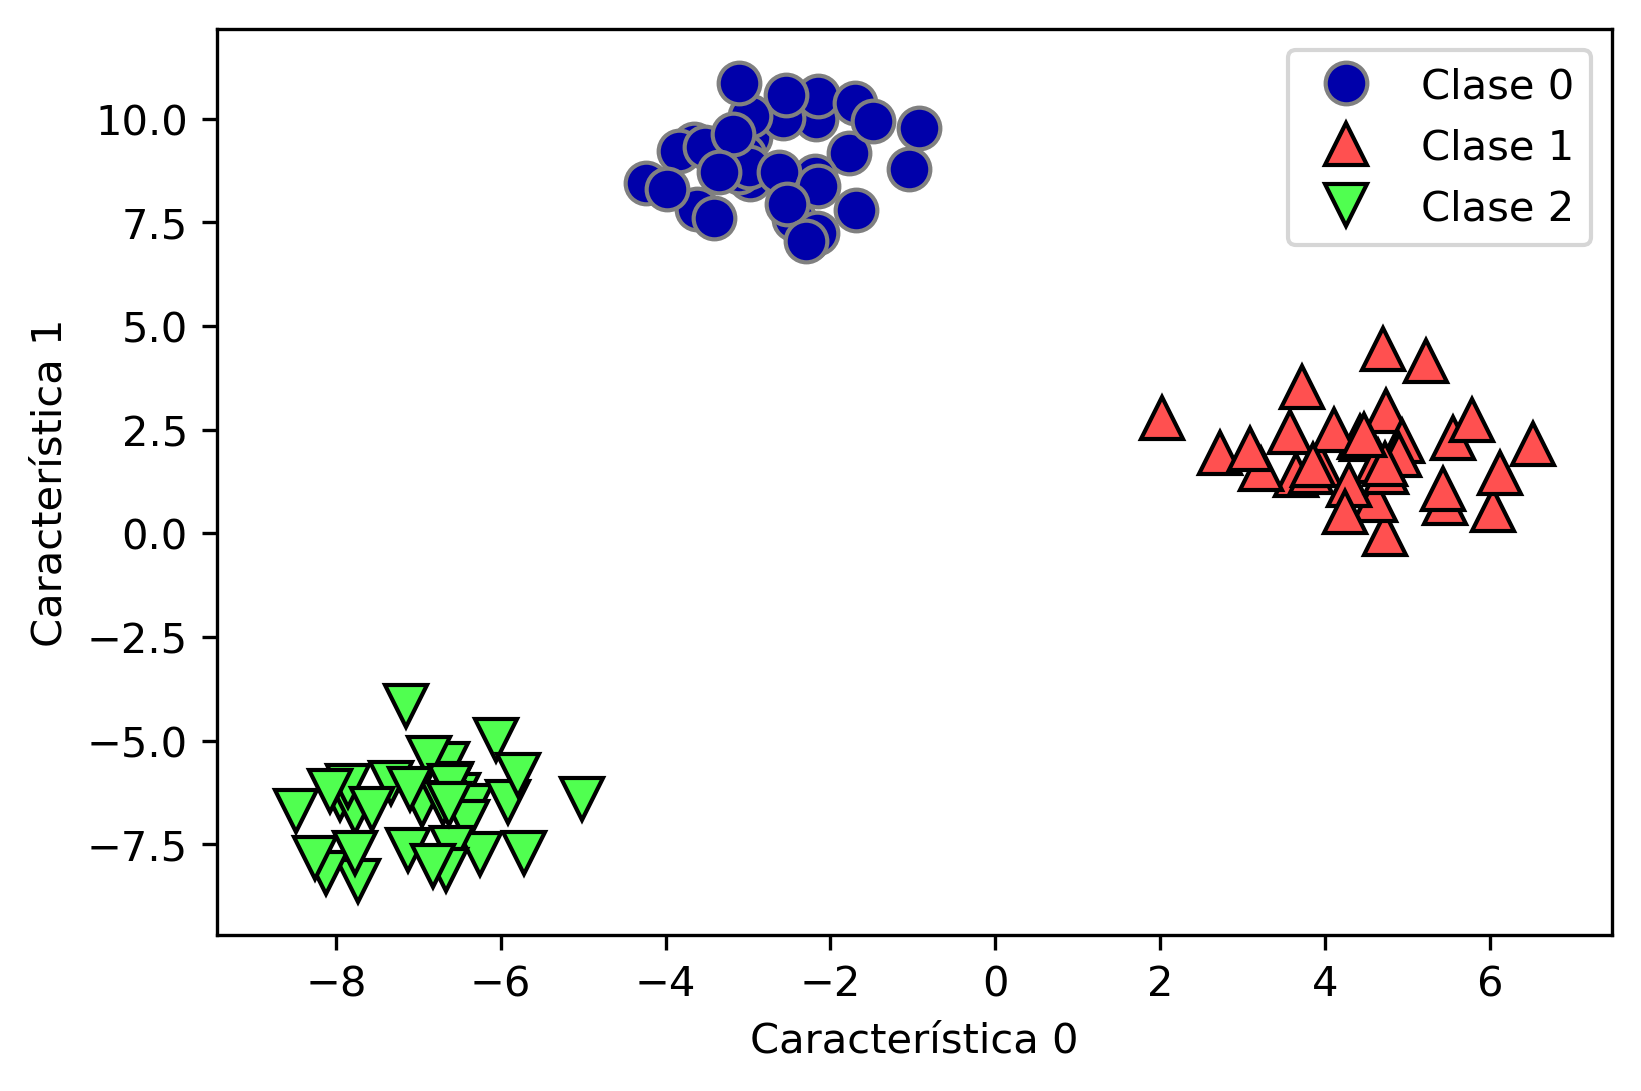

In [45]:
from sklearn.datasets import make_blobs

X, y = make_blobs(random_state=42)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Característica 0")
plt.ylabel("Característica 1")
plt.legend(["Clase 0", "Clase 1", "Clase 2"])

Con estos datos, entrenamos un modelo `LinearSVC`:

In [46]:
# Instanciamos un modelo LinearSCV
linear_svm = LinearSVC().fit(X,y)
print("dimensiones coeficientes: ", linear_svm.coef_.shape)
print("Dimensiones término b: ", linear_svm.intercept_.shape)

dimensiones coeficientes:  (3, 2)
Dimensiones término b:  (3,)


In [ ]:
son los parametros de la frontera de decisión. Tiene 3 hiperplanos, 3 terminos de bayes

Visualicemos las lineas frontera para cada clasificador binario:

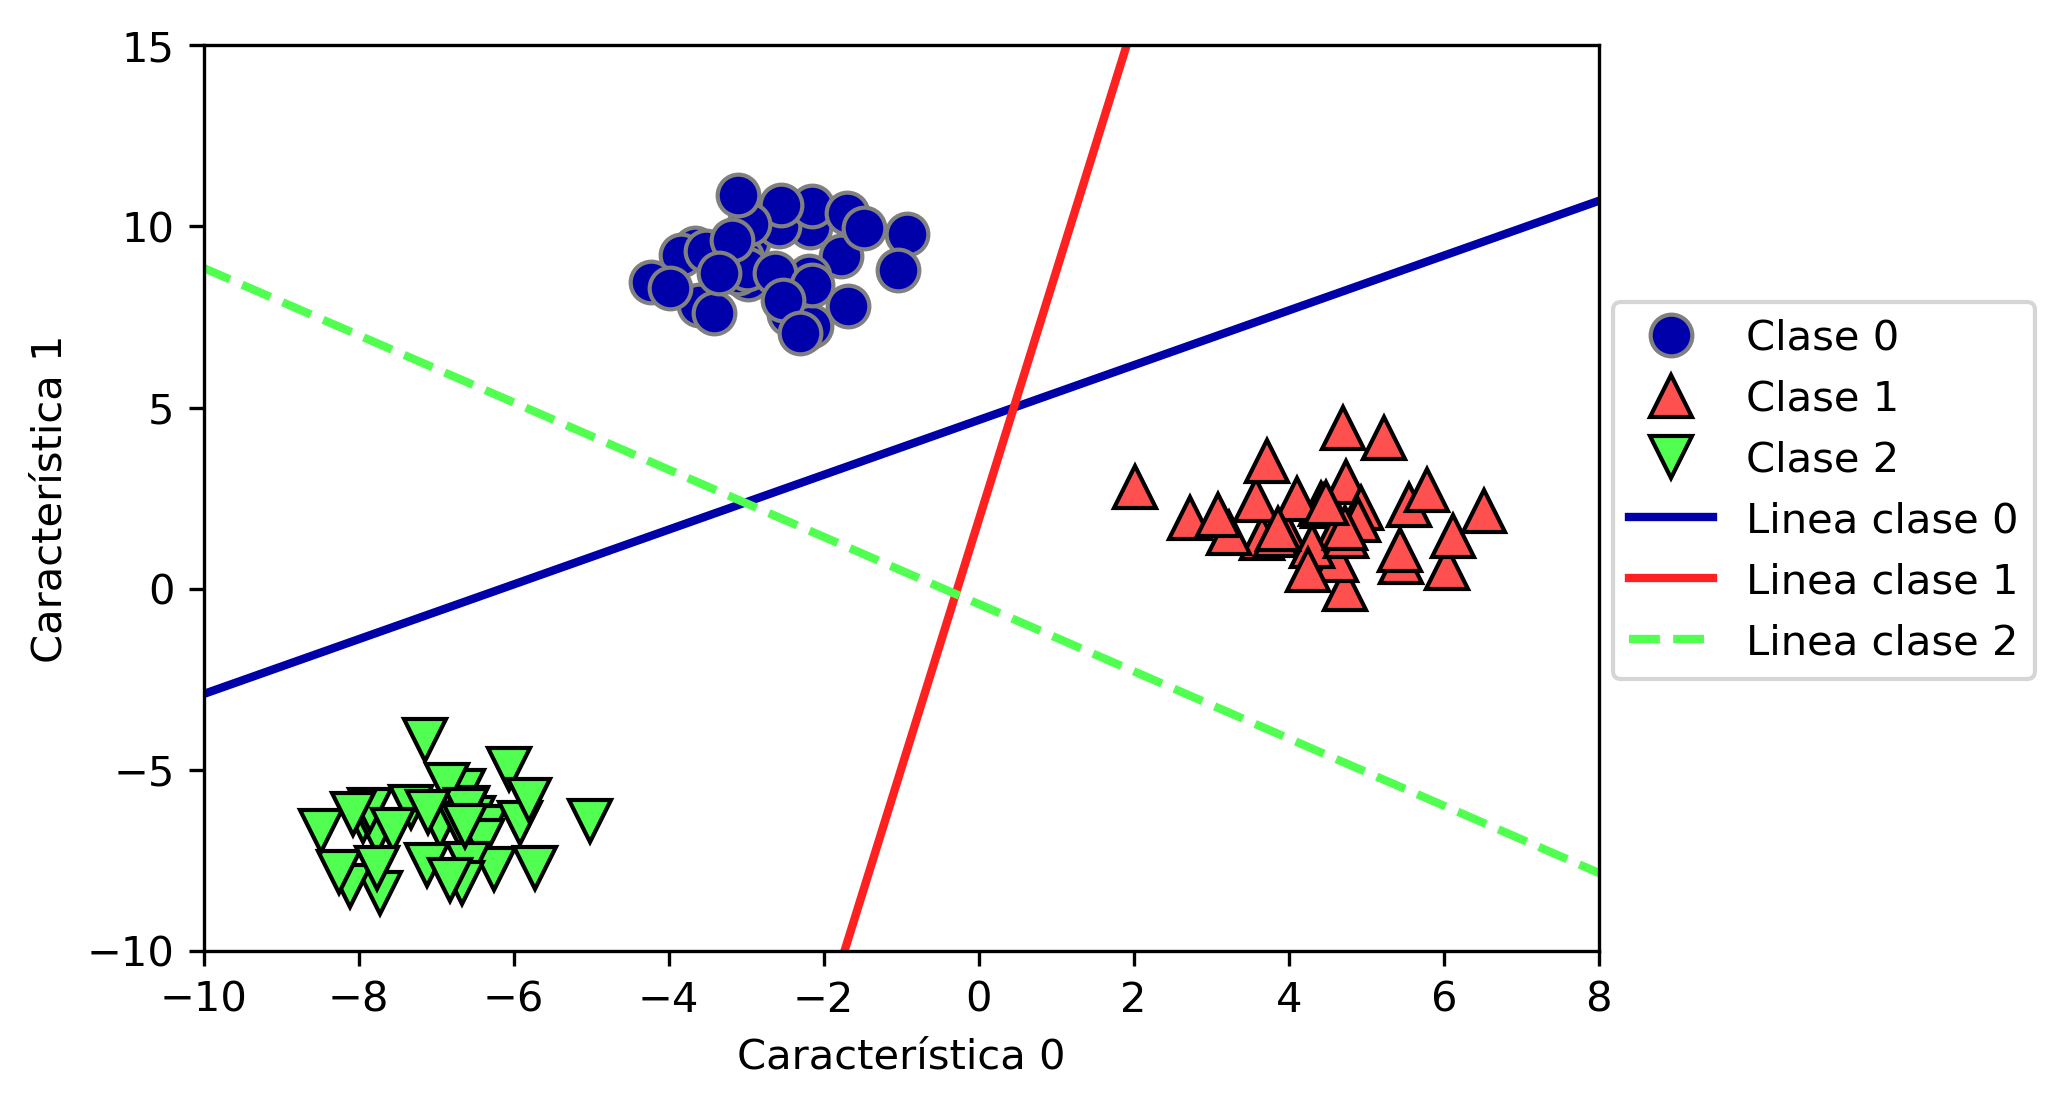

In [47]:
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
# Creamos puntos en una línea en el intervalo [-15, 15]
line=np.linspace(-15,15)

# Iteramos para pintar las lineas con colores distintos
for coef,intercept,color in zip(linear_svm.coef_,linear_svm.intercept_,mglearn.cm3.colors):
    plt.plot(line, -(line * coef[0] + intercept) / coef[1], c=color)

plt.ylim(-10, 15)
plt.xlim(-10, 8)
plt.xlabel("Característica 0")
plt.ylabel("Característica 1")
plt.legend(['Clase 0', 'Clase 1', 'Clase 2', 'Linea clase 0', 'Linea clase 1',
            'Linea clase 2'], loc=(1.01, 0.3))

**Discusión**

Text(0, 0.5, 'Característica 1')

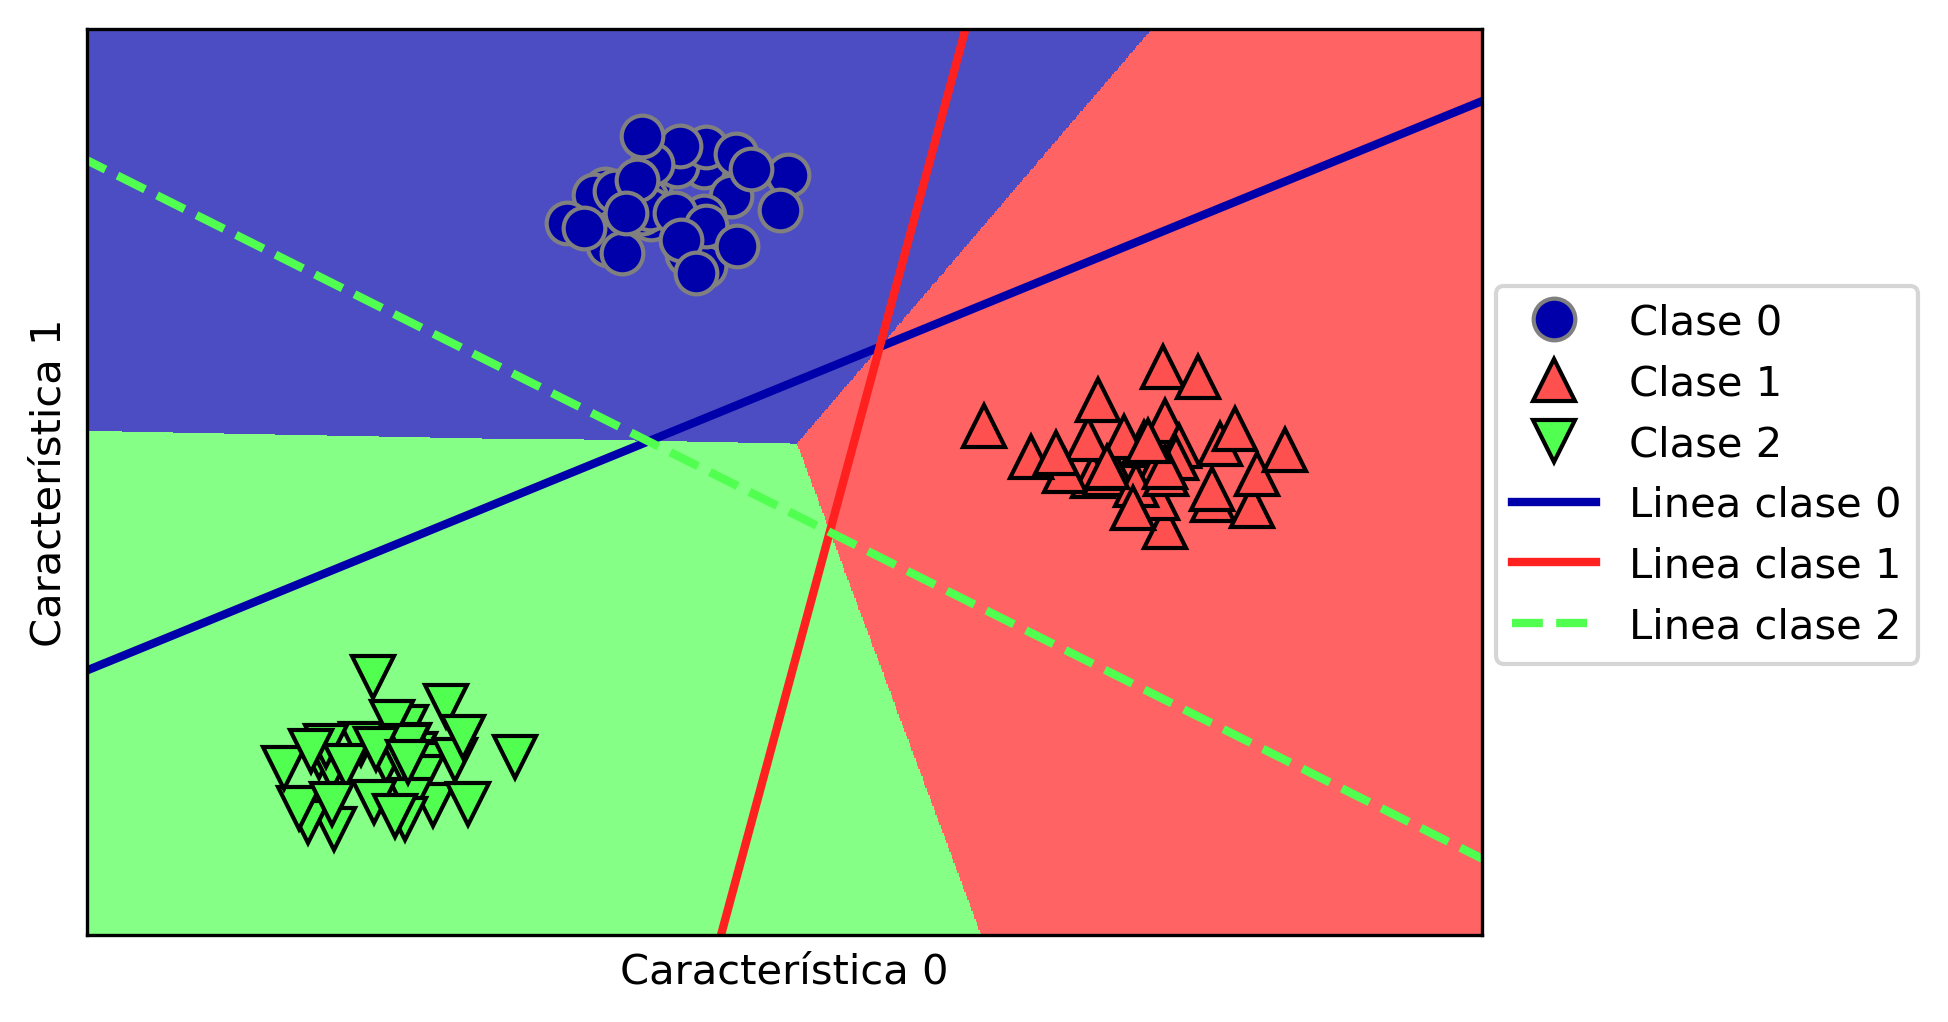

In [48]:
mglearn.plots.plot_2d_classification(linear_svm, X, fill=True, alpha=.7)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
line = np.linspace(-15, 15)
for coef, intercept, color in zip(linear_svm.coef_, linear_svm.intercept_,
                                  mglearn.cm3.colors):
    plt.plot(line, -(line * coef[0] + intercept) / coef[1], c=color)
plt.legend(['Clase 0', 'Clase 1', 'Clase 2', 'Linea clase 0', 'Linea clase 1',
            'Linea clase 2'], loc=(1.01, 0.3))
plt.xlabel("Característica 0")
plt.ylabel("Característica 1")

## Lab 4 - Clasificadores Naive Bayes


Un clasificador Naive Bayes tipo Bernoulli cuenta con qué frecuencia las características de cada clase son distintas de cero. Para entenderlo bien, veamos un ejemplo:

In [4]:
# Crear un array X de 4x4 con ceros y unos aleatoriamente
# Crear un array y de 1x4 con las etiquetas (ceros y unos)
X=np.array([[0,1,0,1],[0,0,1,1],[1,1,0,1],[1,0,1,0]])
y=np.array([0,1,0,1])

Hagamos un conteo de muestras

In [6]:
# Contar tipo de características
counts={}
for label in np.unique(y):
    counts[label]=X[y==label].sum(axis=0)
print(counts)
    

{0: array([1, 2, 0, 2]), 1: array([1, 0, 2, 1])}


In [7]:
# Importar BernoulliNB, instanciar y entrenar
from sklearn.naive_bayes import BernoulliNB
clf=BernoulliNB()
clf.fit(X,y)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [9]:
# Probar una predicción
print(clf.predict([[1,1,1,0]]))

[1]


**Discusión**

## Lab 5 - Árboles de decisión

### Construcción de árboles de decisión
Usemos ahora el método `make_moons` de Scikit-Learn para ilustrar gráficamente con un dataset de más puntos la construcción de un árbol de decisión, que también nos ayudará a revelar algunas de sus características:

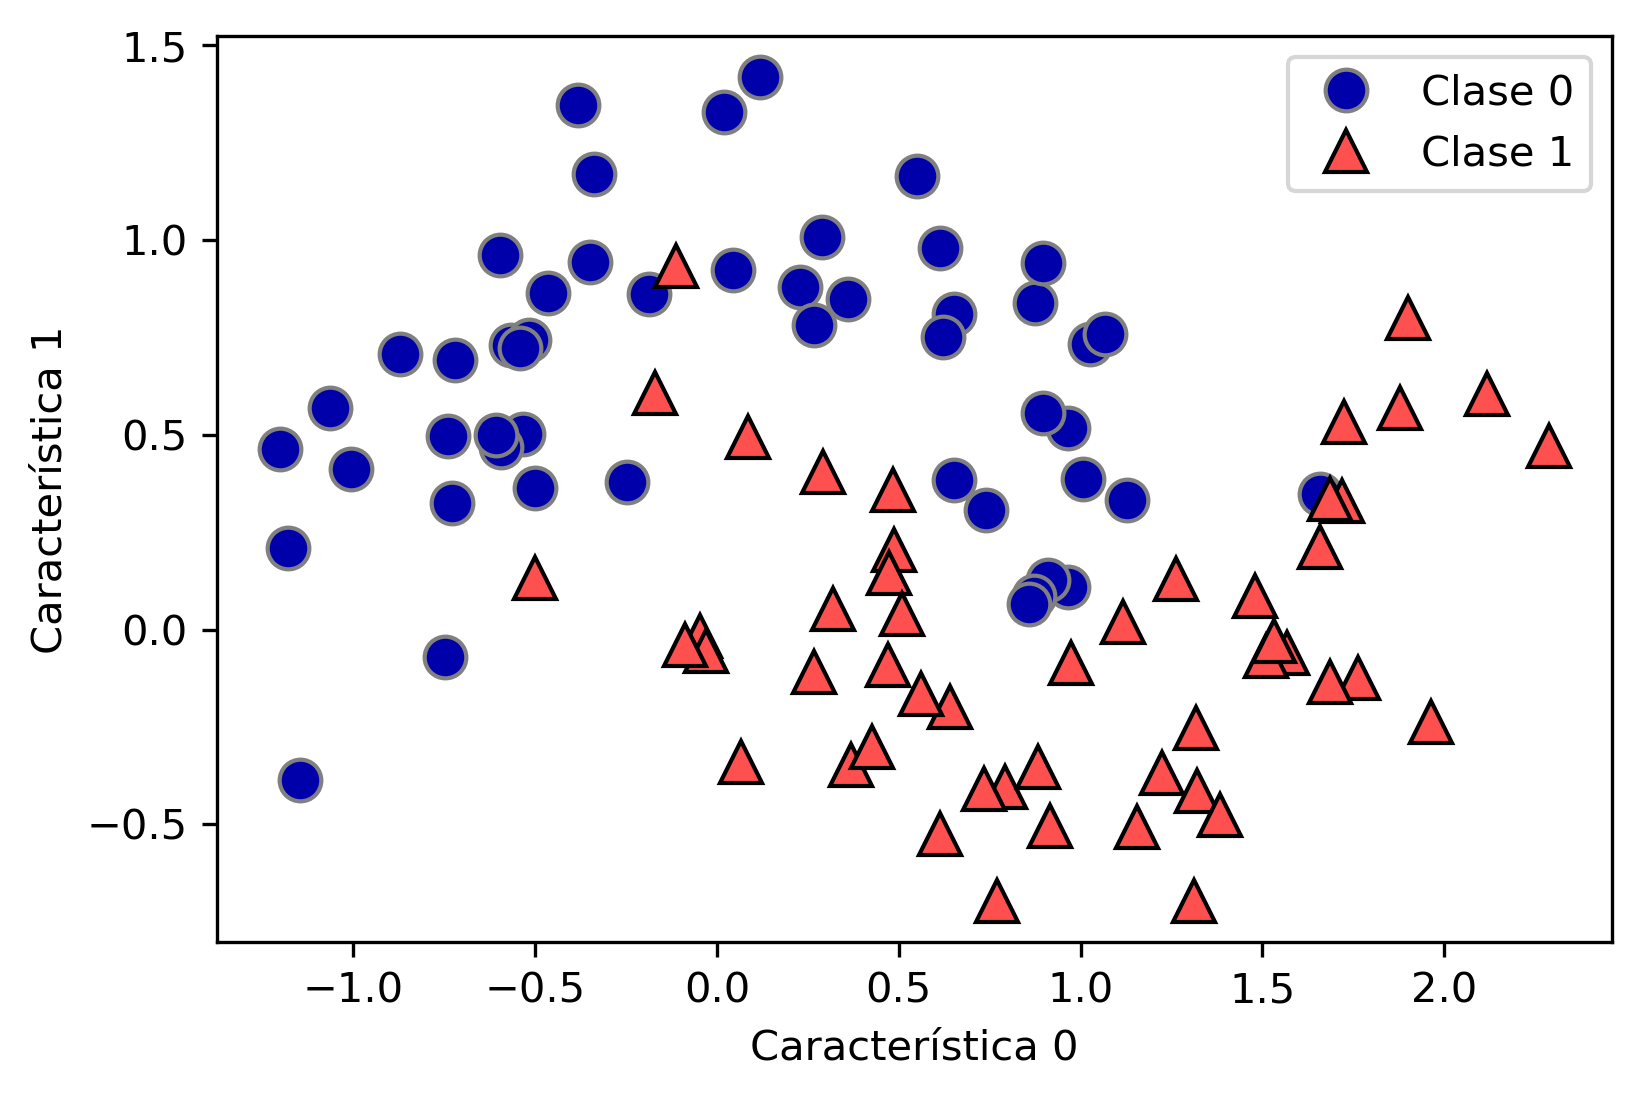

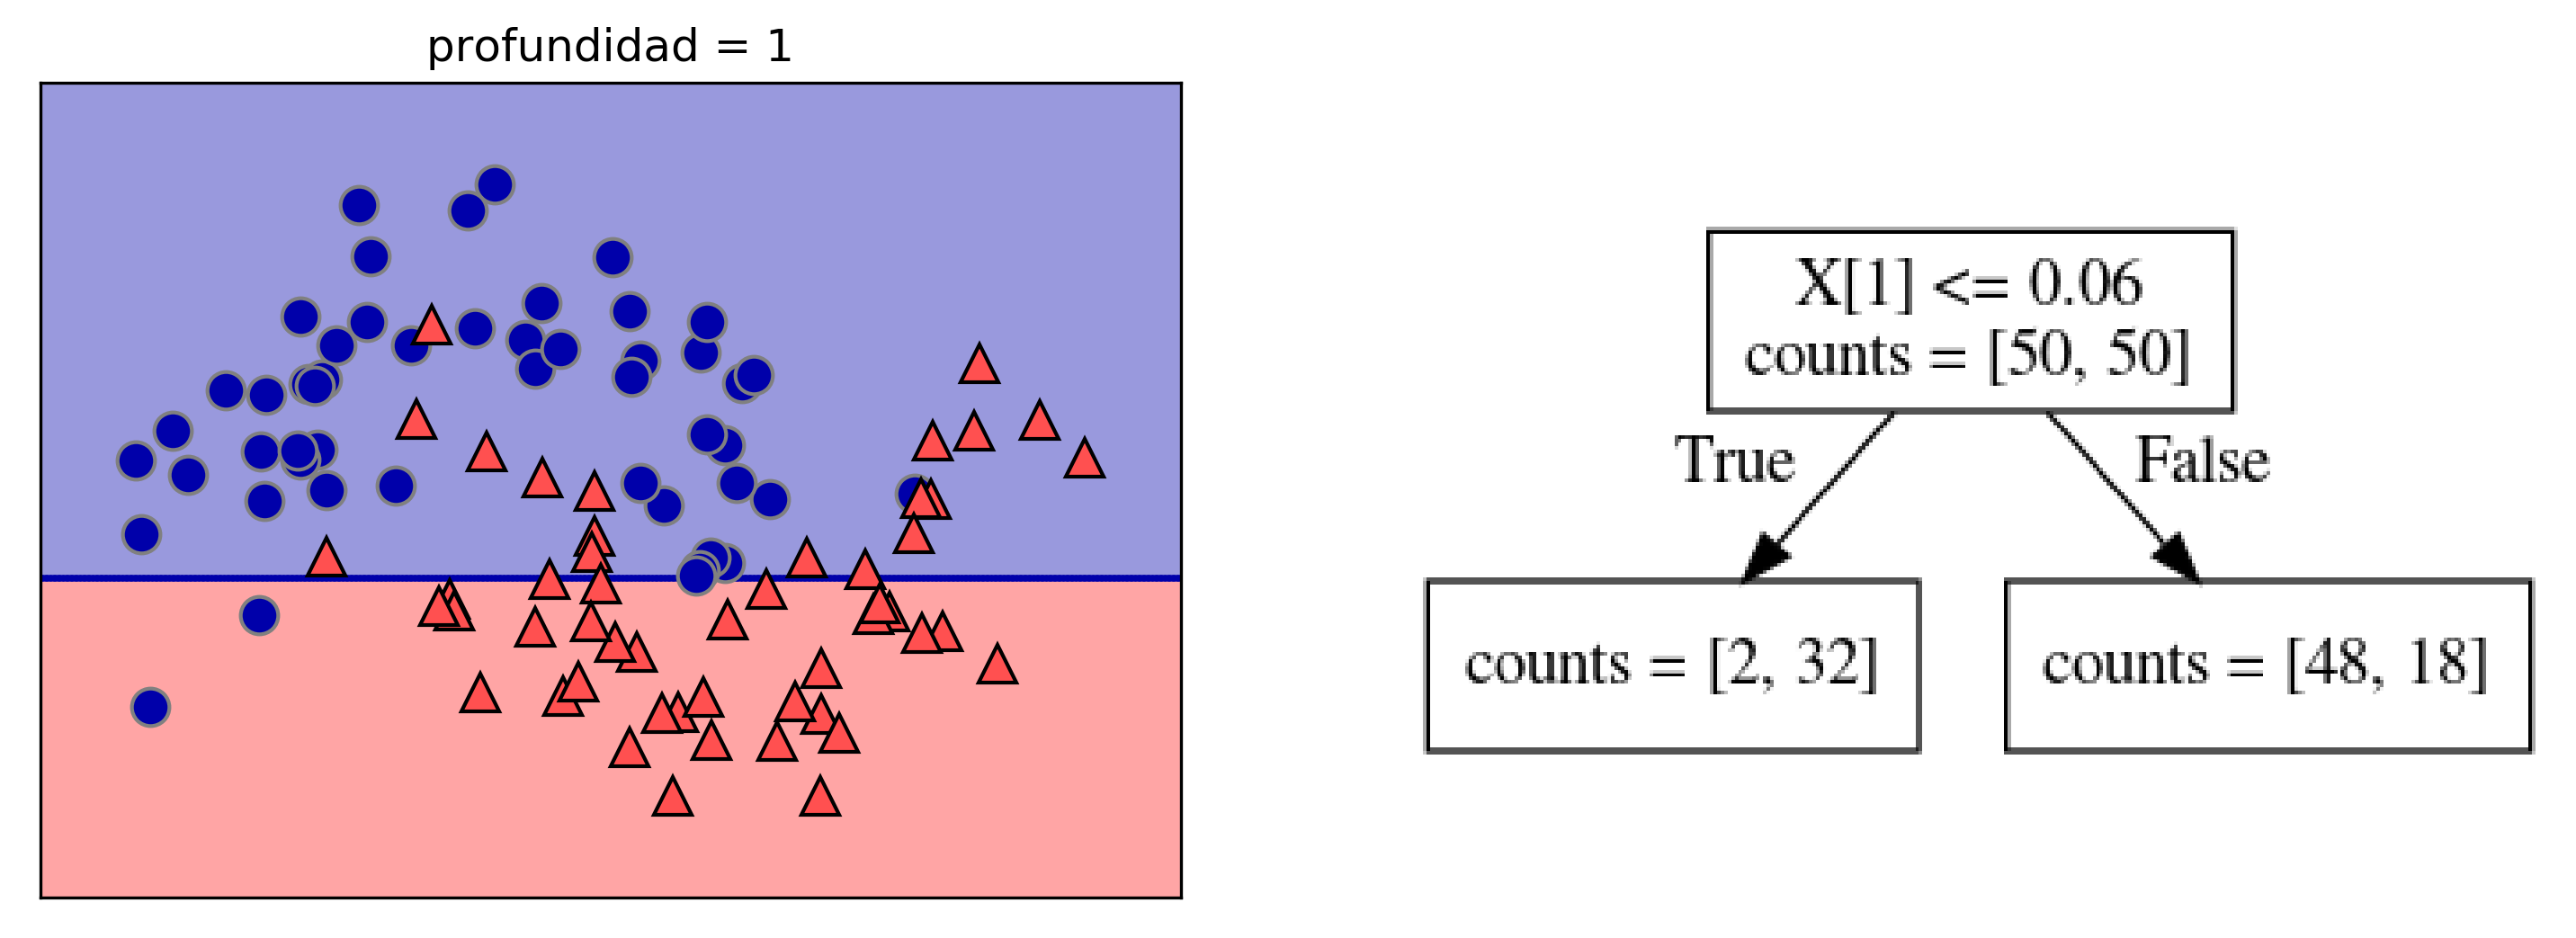

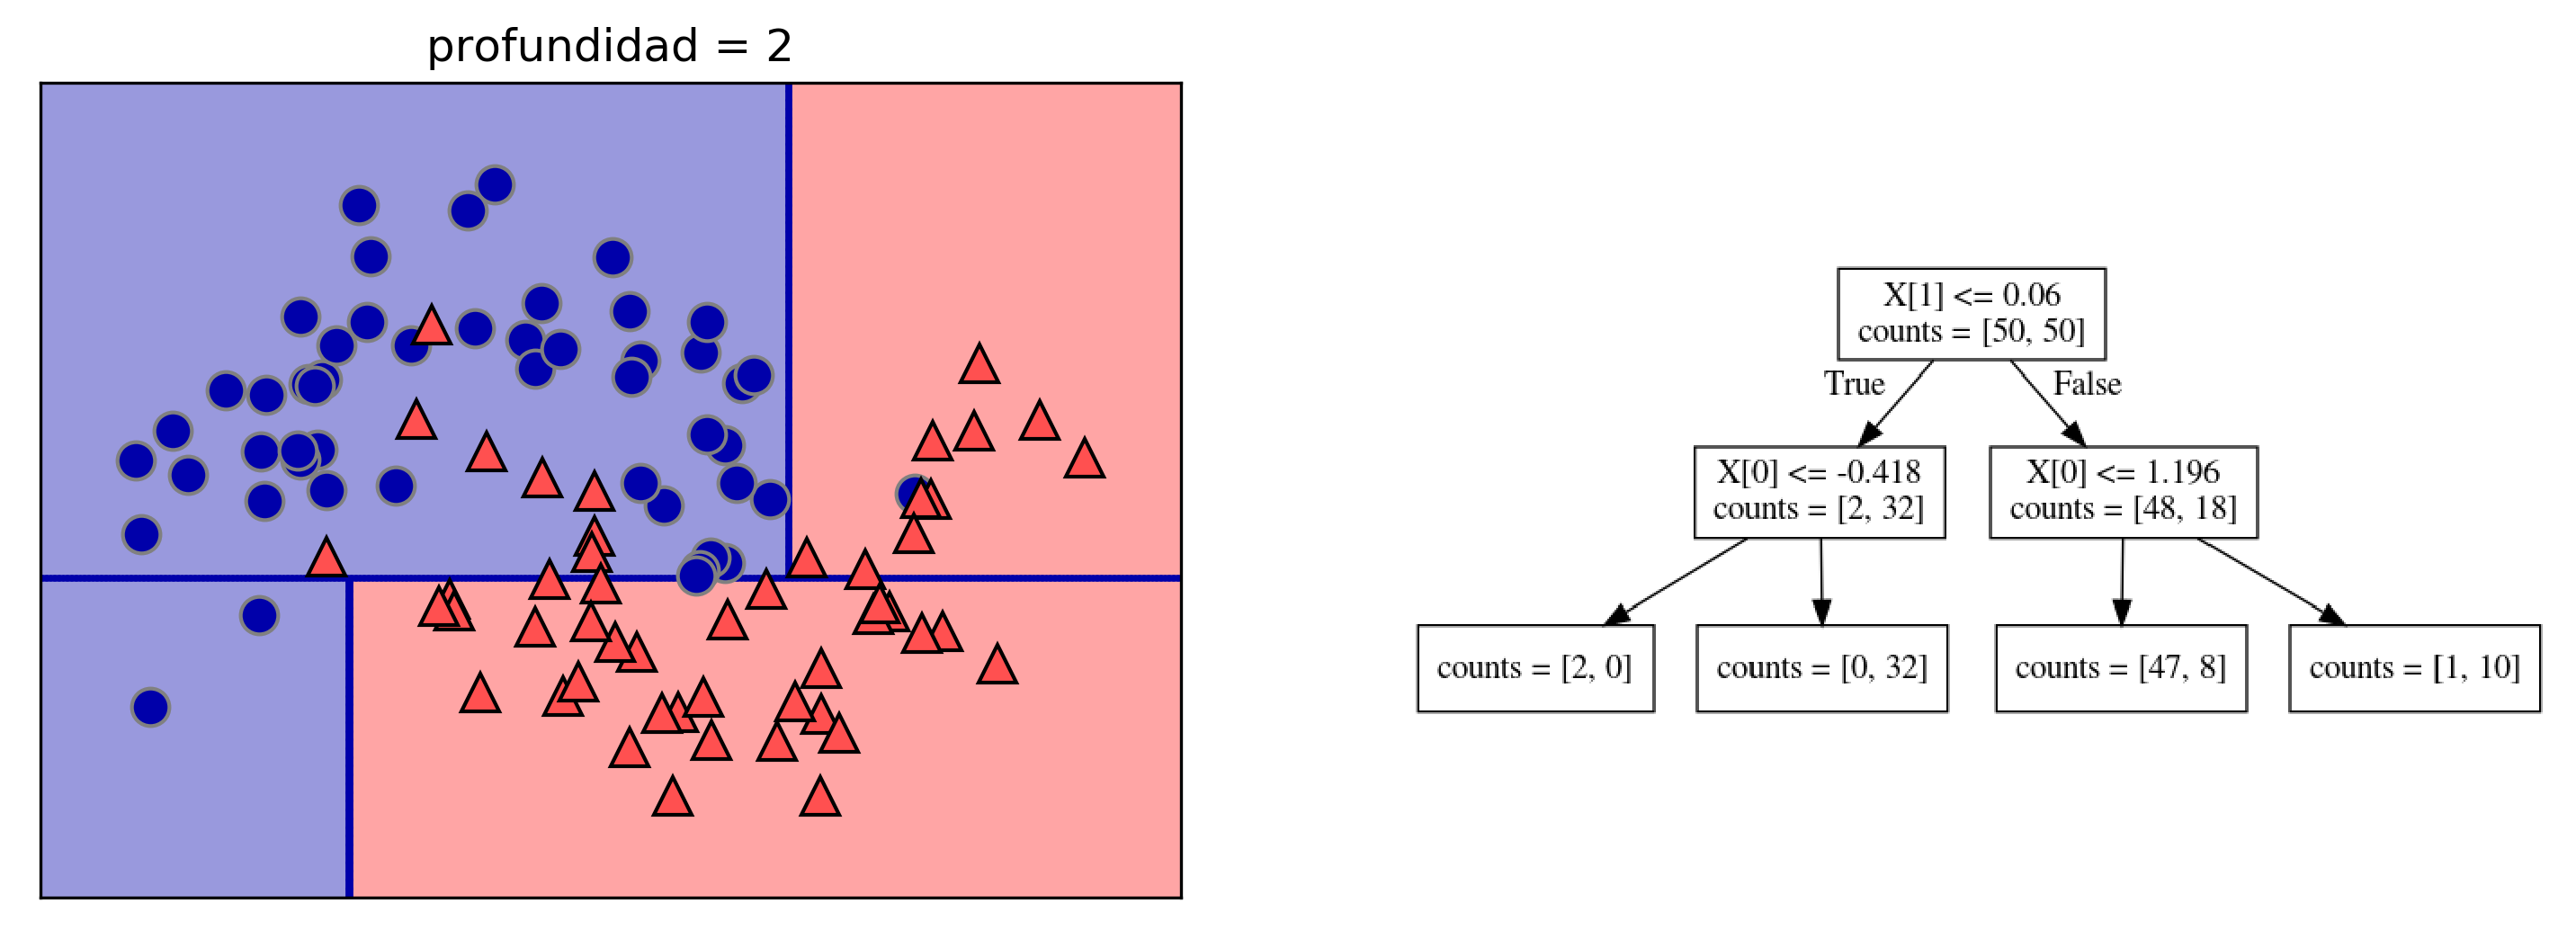

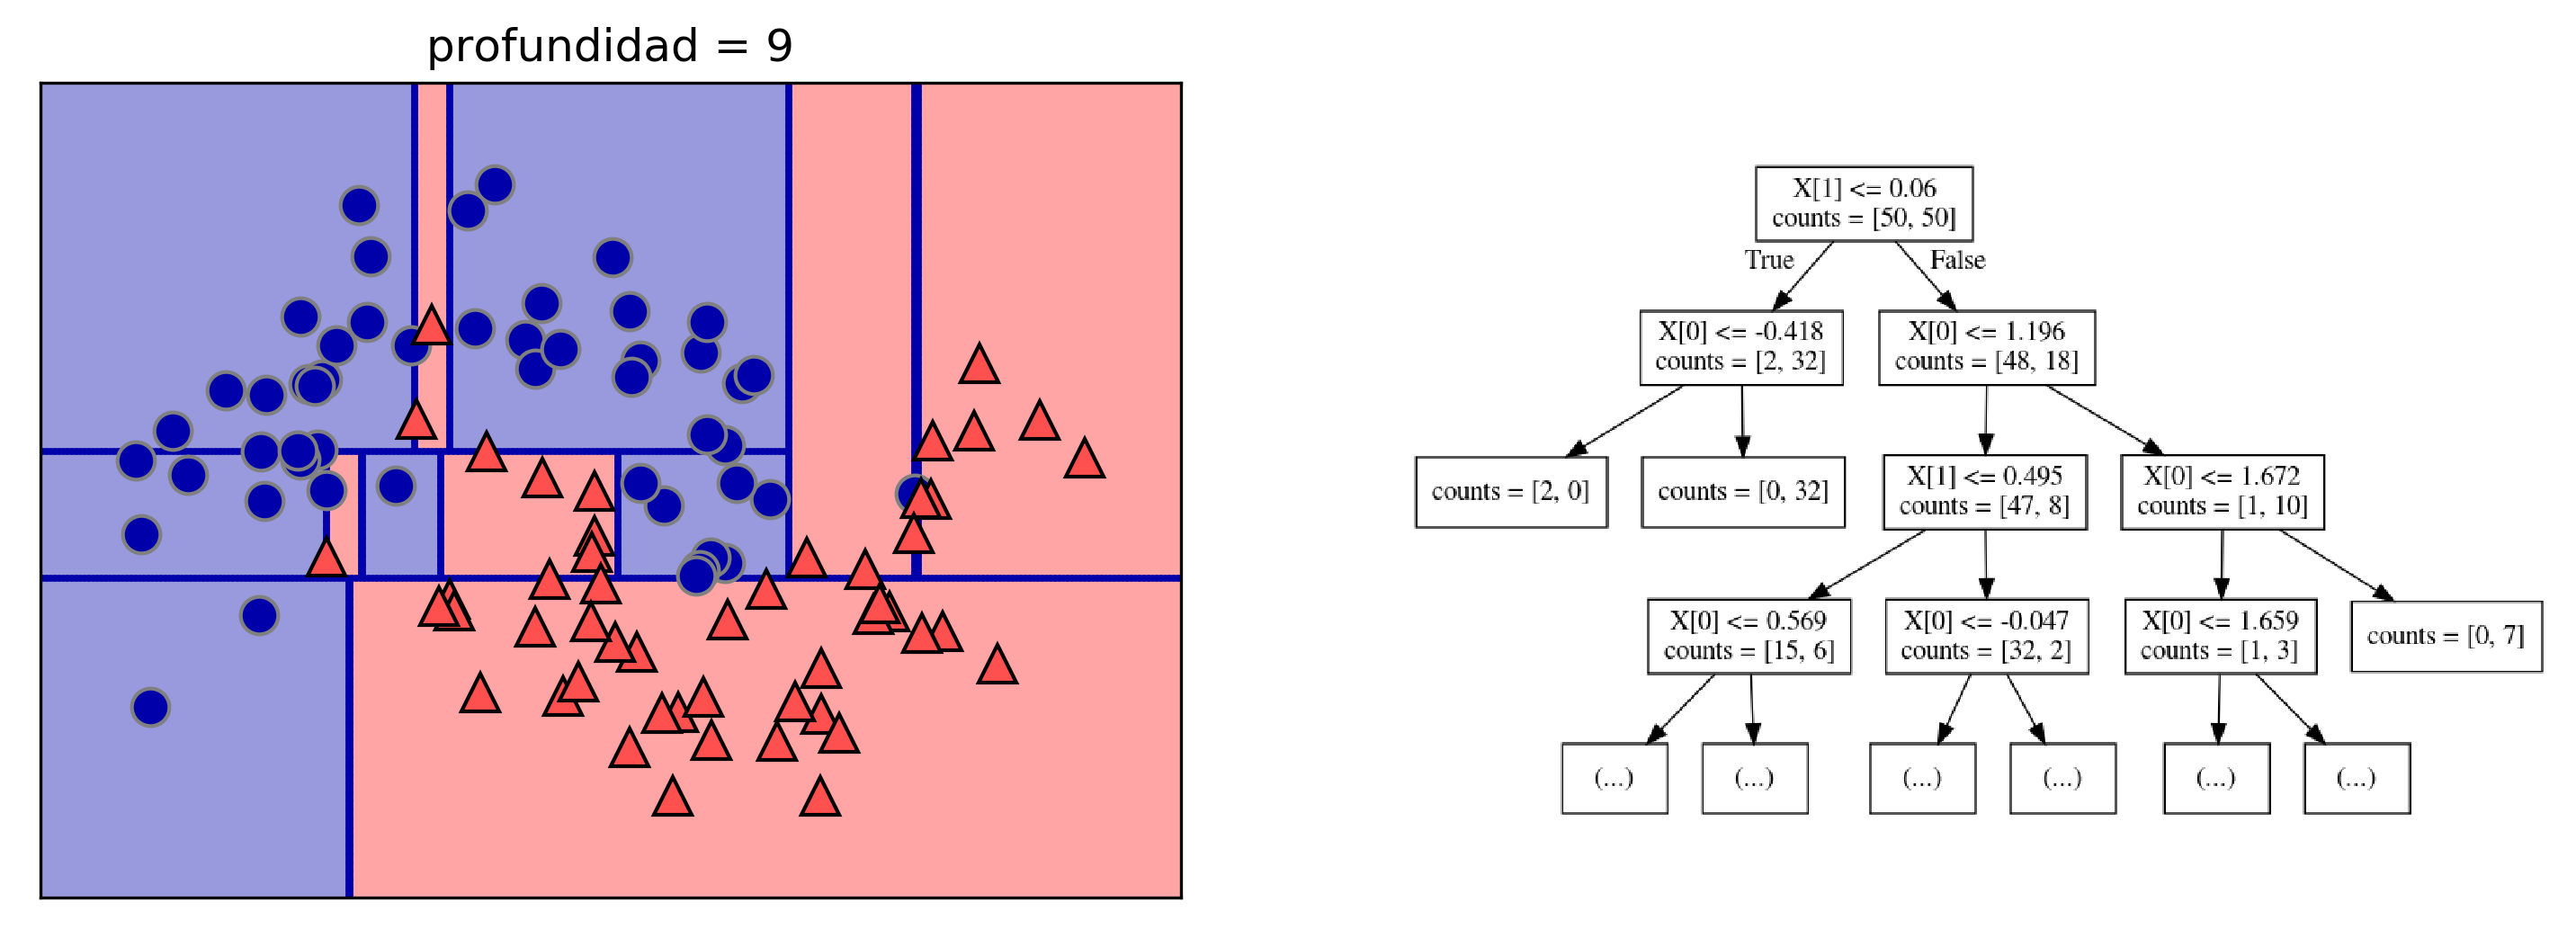

In [4]:
import mglearn
mglearn.plots.plot_tree_progressive() # pinta como funciona un arbol de decisión para make_moons

In [ ]:
problema de decision trees, si no lo gestionas bien peligro de overfitting

**Discusión**

### Control de la precisión de los árboles de decisión

In [14]:
#Importar un DecisionTreeClassifier desde el módulo tree
from sklearn.tree import DecisionTreeClassifier

# Cargar el Breast Cancer Dataset
cancer = load_breast_cancer()
# Partir el dataset alrededor del target
X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,
                                                    stratify=cancer.target,random_state=42)

# Instanciar un modelo y entrenarlo
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train,y_train)

# Evaluarlo
print("Precisión en el training set: {:.3f}".format(tree.score(X_train,y_train)))
print("Precisión en el test set: {:.3f}".format(tree.score(X_test,y_test)))

Precisión en el training set: 1.000
Precisión en el test set: 0.923


In [ ]:
problema de overfitting, esto no es bueno. Ha aprendido el training set
cuando haya un minimo de variabilidad el juego de test va a fallar

**Discusión**

Limitemos ahora la profundidad máxima a 4 y volvamos a entrenar el modelo y evaluar su precisión:

In [16]:
# Instanciar un modelo y entrenarlo
tree = DecisionTreeClassifier(max_depth=4,random_state=42)
tree.fit(X_train,y_train)

# Evaluarlo
print("Precisión en el training set: {:.3f}".format(tree.score(X_train,y_train)))
print("Precisión en el test set: {:.3f}".format(tree.score(X_test,y_test)))

Precisión en el training set: 0.988
Precisión en el test set: 0.944


In [ ]:
Ha subido la precisión en el test cortando la profundidad a 4

### Análisis de los árboles de decisión

Podemos visualizar el árbol utilizando la función `export_graphviz` incluida en el módulo `tree`. Esta función graba el árbol en un fichero de tipo `.dot`, que es un formato texto para describir árboles.

Usamos una opción para colorear los nodos para reflejar la clase mayoritaria en cada uno y le pasamos los nombres de clases y caracterísitcas:

In [20]:
from sklearn.tree import export_graphviz
export_graphviz(tree,out_file='tree.dot',class_names=['maligno','benigno'],
                feature_names=cancer.feature_names,impurity=False,filled=True)

Por último, leemos el fichero y los visualizamos para representar el árbol:

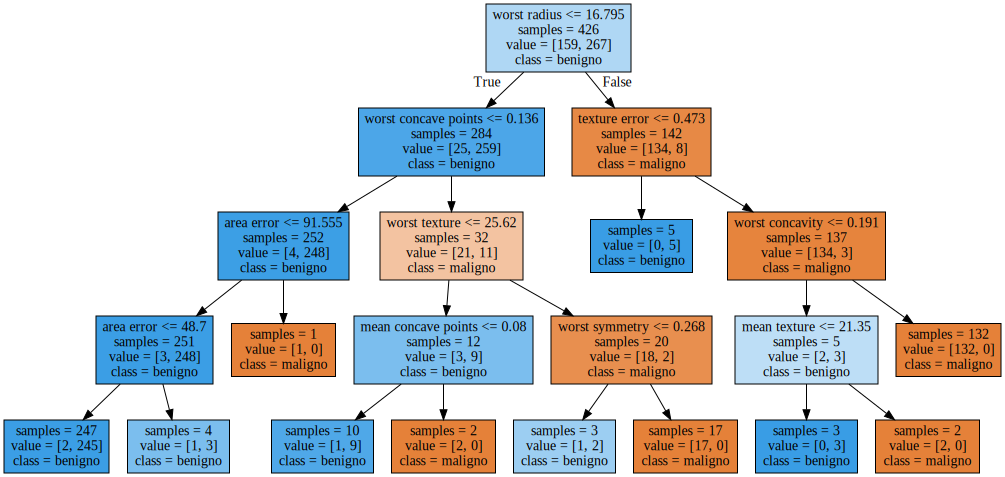

In [21]:
import graphviz
with open('tree.dot')as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

**Discusión**

### Importancias de las características

In [22]:
print("Importancia de las características:")
print(tree.feature_importances_)

Importancia de las características:
[0.    0.013 0.    0.    0.    0.    0.    0.014 0.    0.    0.    0.048
 0.    0.013 0.    0.    0.    0.    0.    0.    0.727 0.033 0.    0.
 0.    0.    0.018 0.122 0.012 0.   ]


In [ ]:
Si el valor es 0 significa que no hemos utilizado la caracteristicas para la construccion
del arbol. Un valor de 1 signifcia que la caracteristica es determinante y predice 
perfectamente. Quiere decir que el arbol no la ha elegido, no significa que la 
caracteristica no sea importante, el arbol elige la caracteristica que representa mejor
el tipo de decisión que va a tomar. El 1 es un indica de que el arbol hace
un buen split con esa caracteristica, no que sea una caracteristica que defina si el
cancer es maligno o benigno

Podemos visualizar estas importancias de manera similar a la que visualizábamos los coeficientes en los modelos lineales:

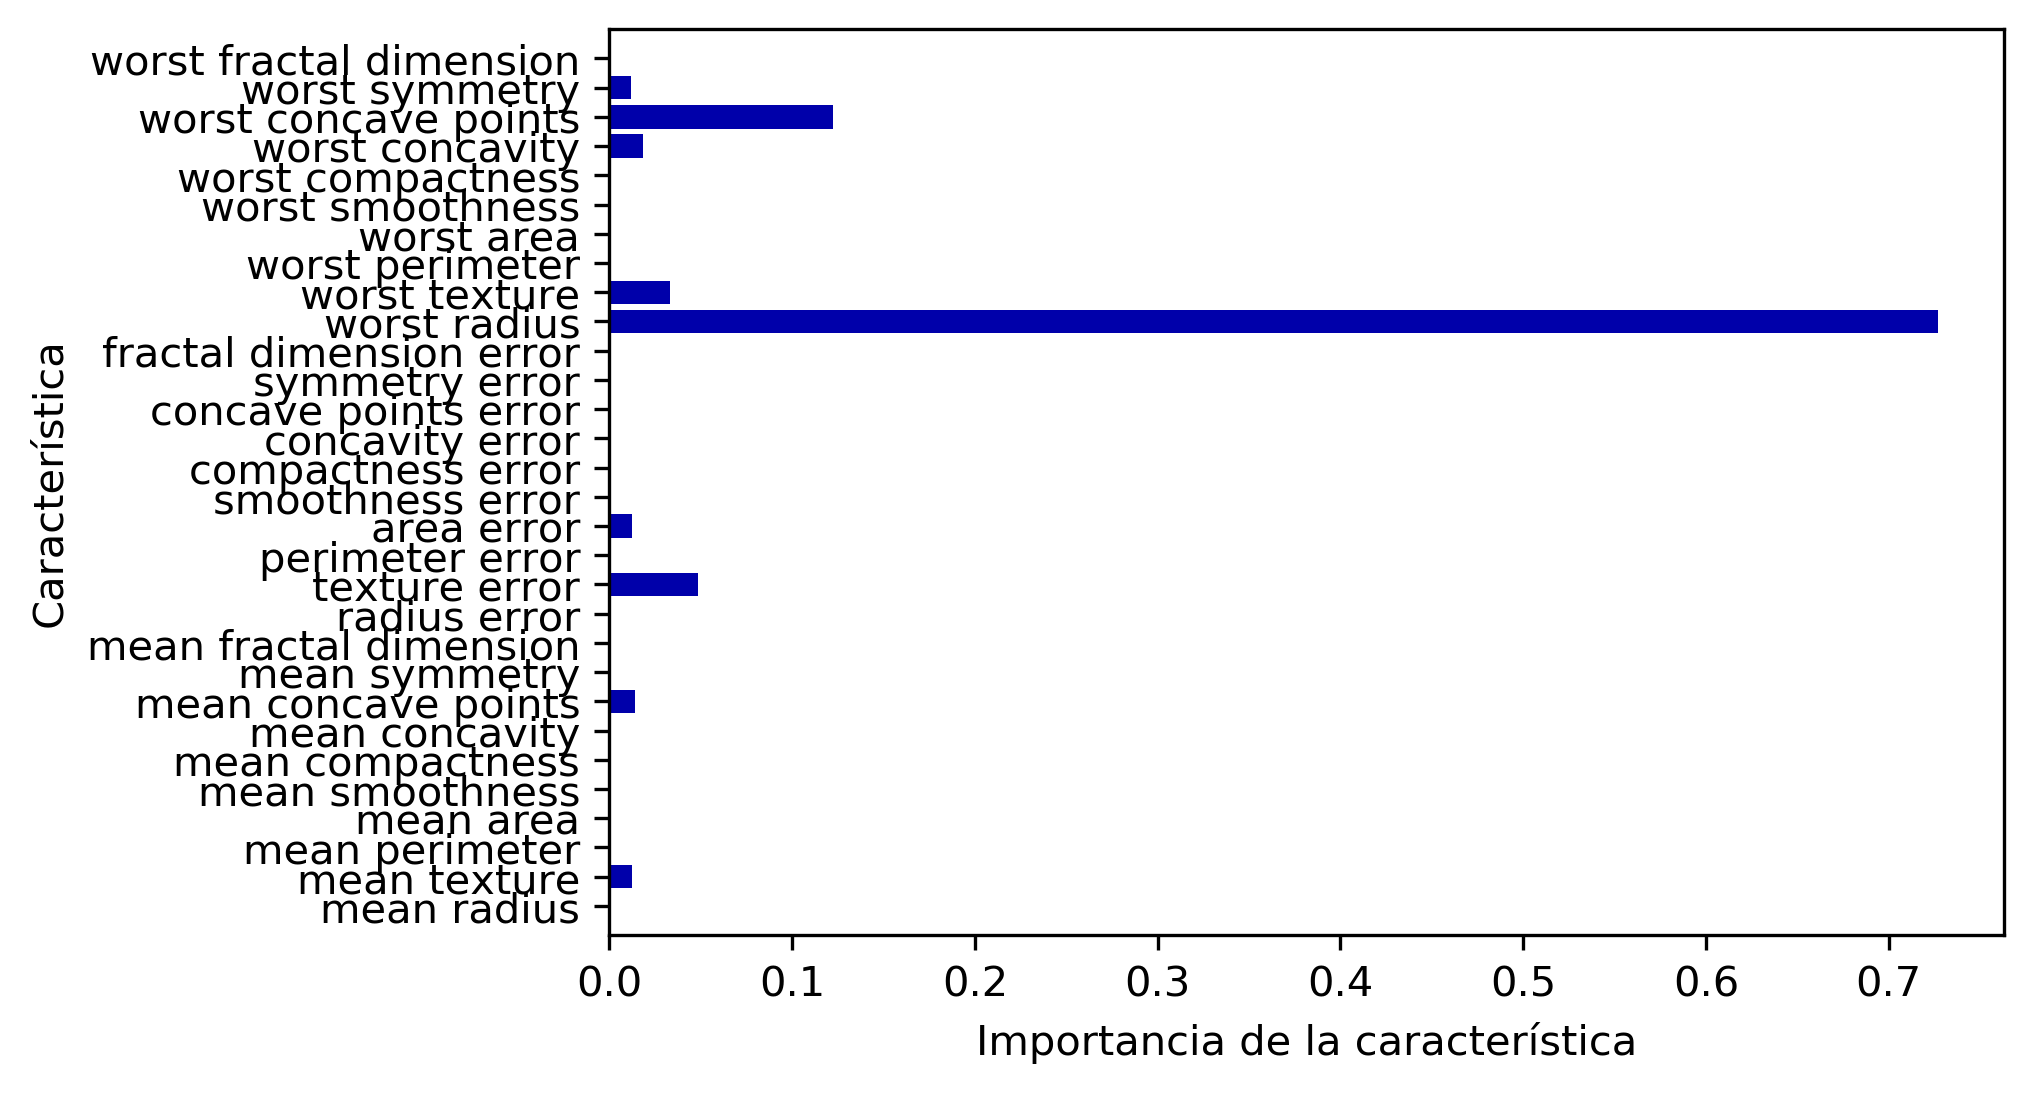

In [23]:
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Importancia de la característica")
    plt.ylabel("Característica")
    plt.ylim(-1, n_features)

plot_feature_importances_cancer(tree)

**Discusión**

Feature importances: [0. 1.]


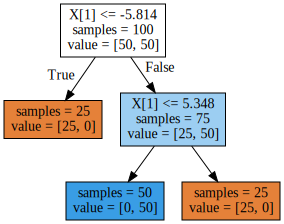

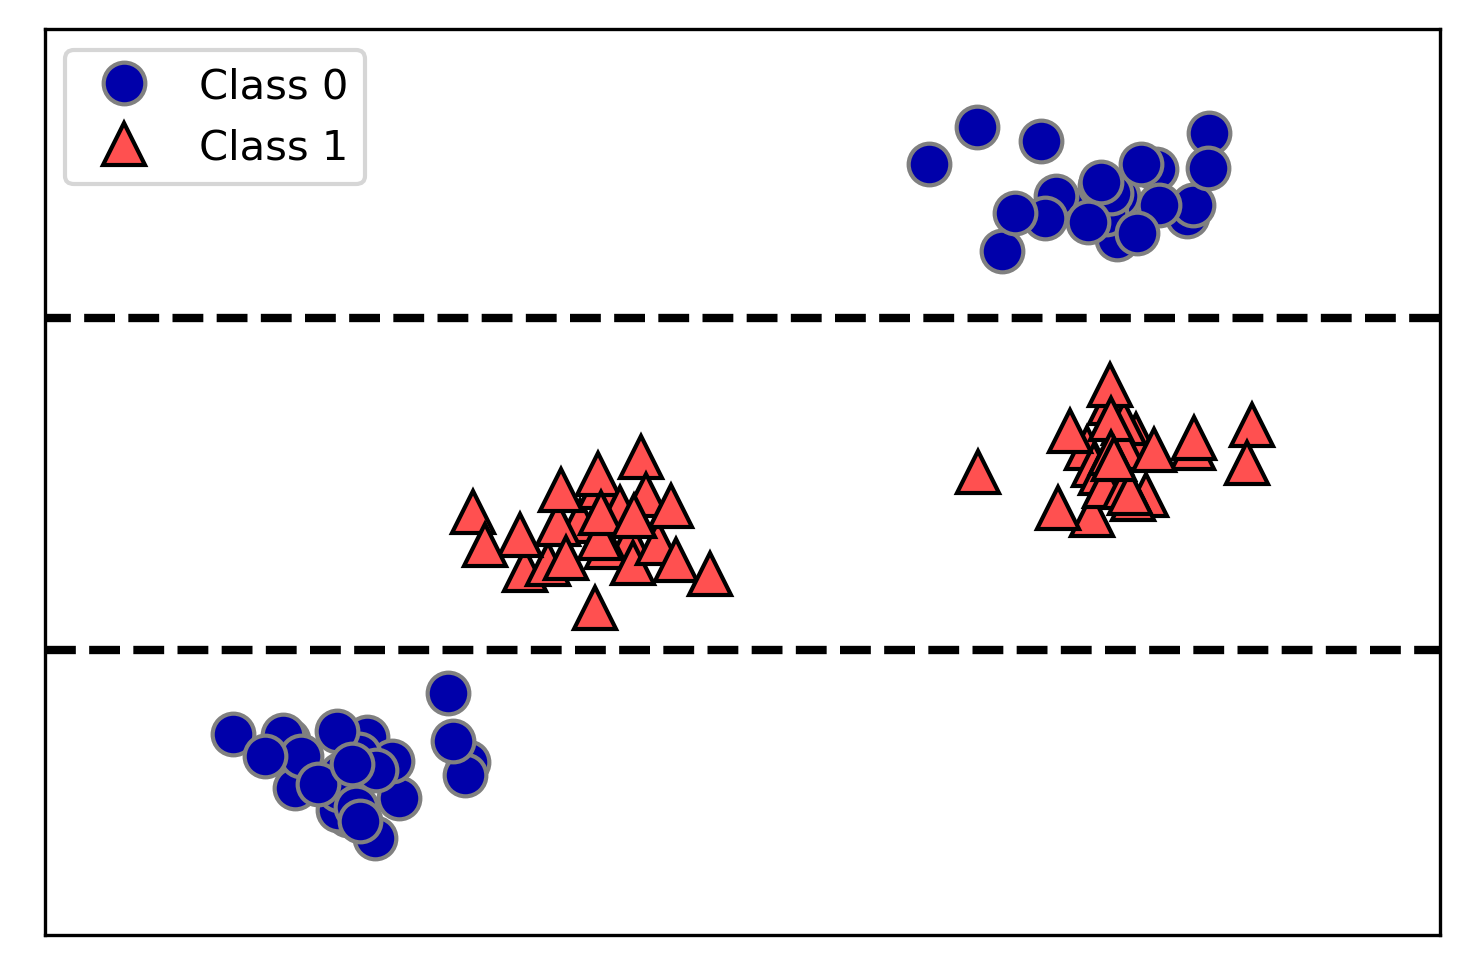

In [24]:
tree = mglearn.plots.plot_tree_not_monotone()
display(tree)

**Discusión**

Cargamos un dataset llamado ram_price.csv y lo pintamos:

In [25]:
%pwd

'/home/dsc/Repos/kschool-supervised-learning'

Text(0, 0.5, 'precio en S/Mbyte')

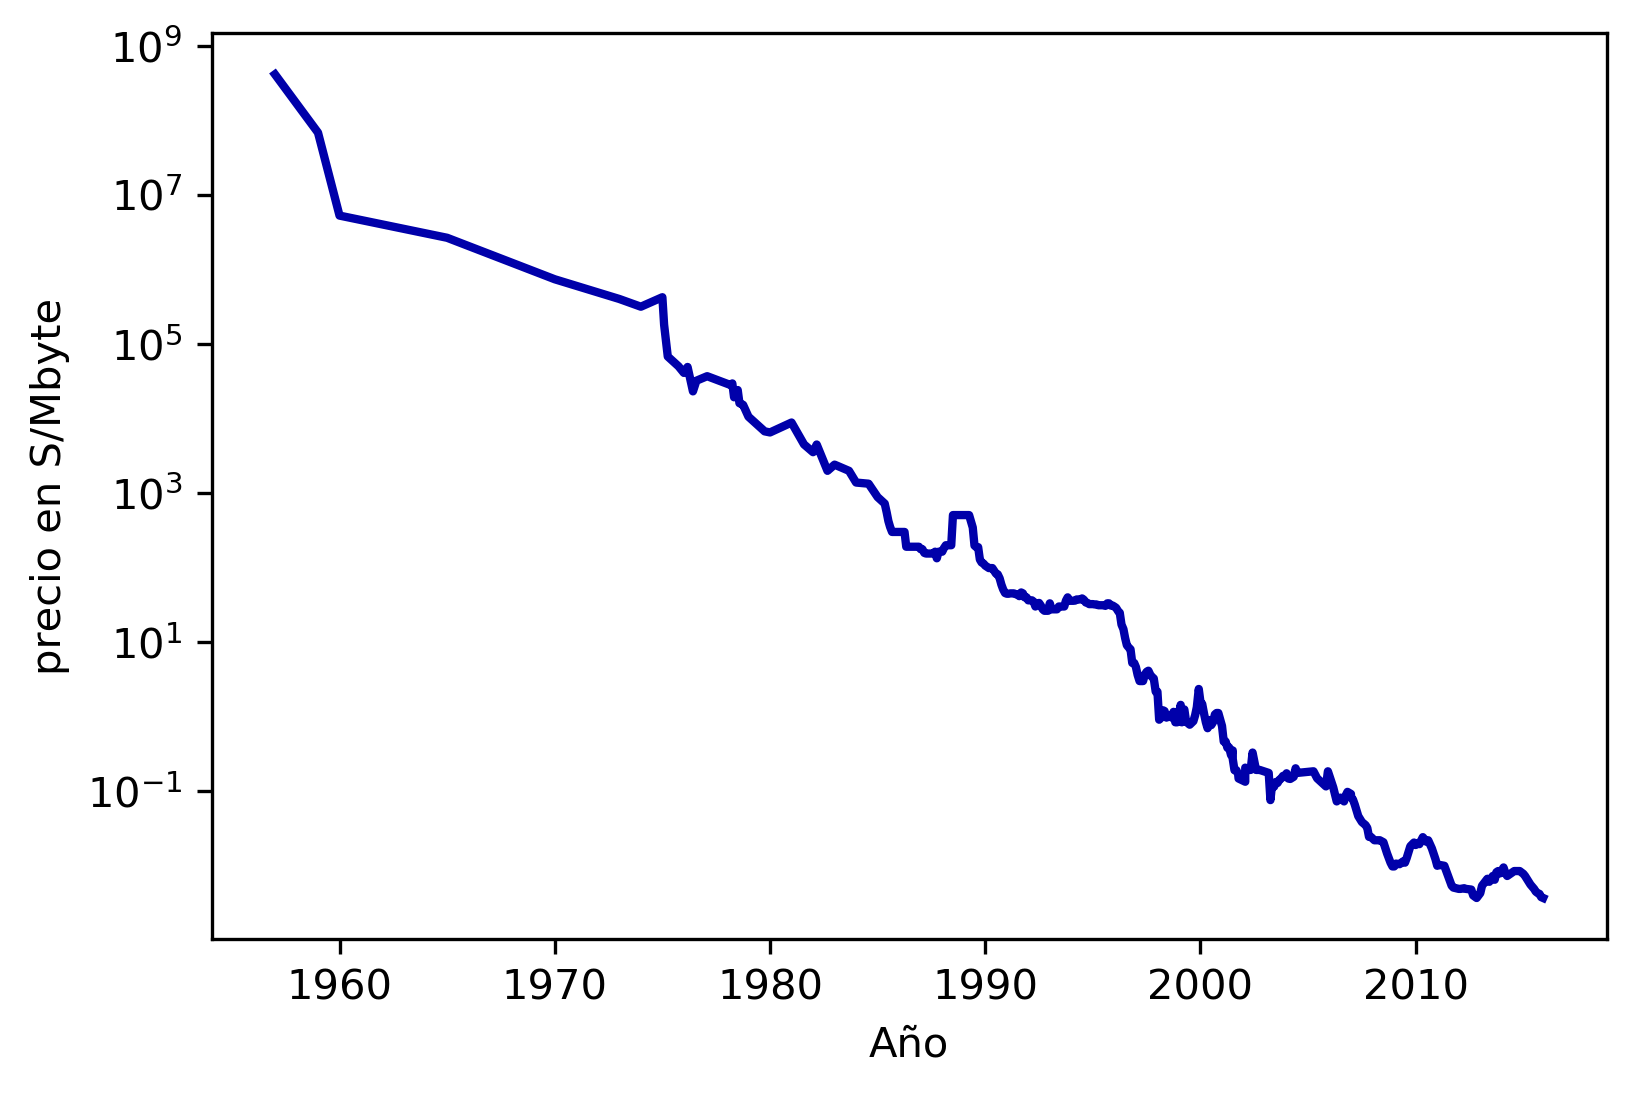

In [28]:
import os
ram_prices=pd.read_csv('data/ram_price.csv')
plt.semilogy(ram_prices.date,ram_prices.price)
plt.xlabel('Año')
plt.ylabel('precio en S/Mbyte')

Aplicamos una regresión lineal y un árbol de decisión para hacer predicciones y comparar:

In [33]:
from sklearn.tree import DecisionTreeRegressor
data_train = ram_prices[ram_prices.date<2000]
data_test = ram_prices[ram_prices.date>=2000]

X_train = data_train.date[:, np.newaxis]# convierte esto en un vector columna
y_train = np.log(data_train.price)# para hacer un mejor entrenamiento de los datos transfor logaritmica

tree = DecisionTreeRegressor(max_depth=3).fit(X_train,y_train)
linear_reg = LinearRegression().fit(X_train,y_train)

X_all = ram_prices.date[:,np.newaxis]

pred_tree = tree.predict(X_all)
pred_lr =linear_reg.predict(X_all)

price_tree =np.exp(pred_tree) # hacemos reconversión para vovler atras en la escala
price_lr =np.exp(pred_lr)

Ahora, dibujamos  las predicciones para comparar los modelos con los datos de partida:

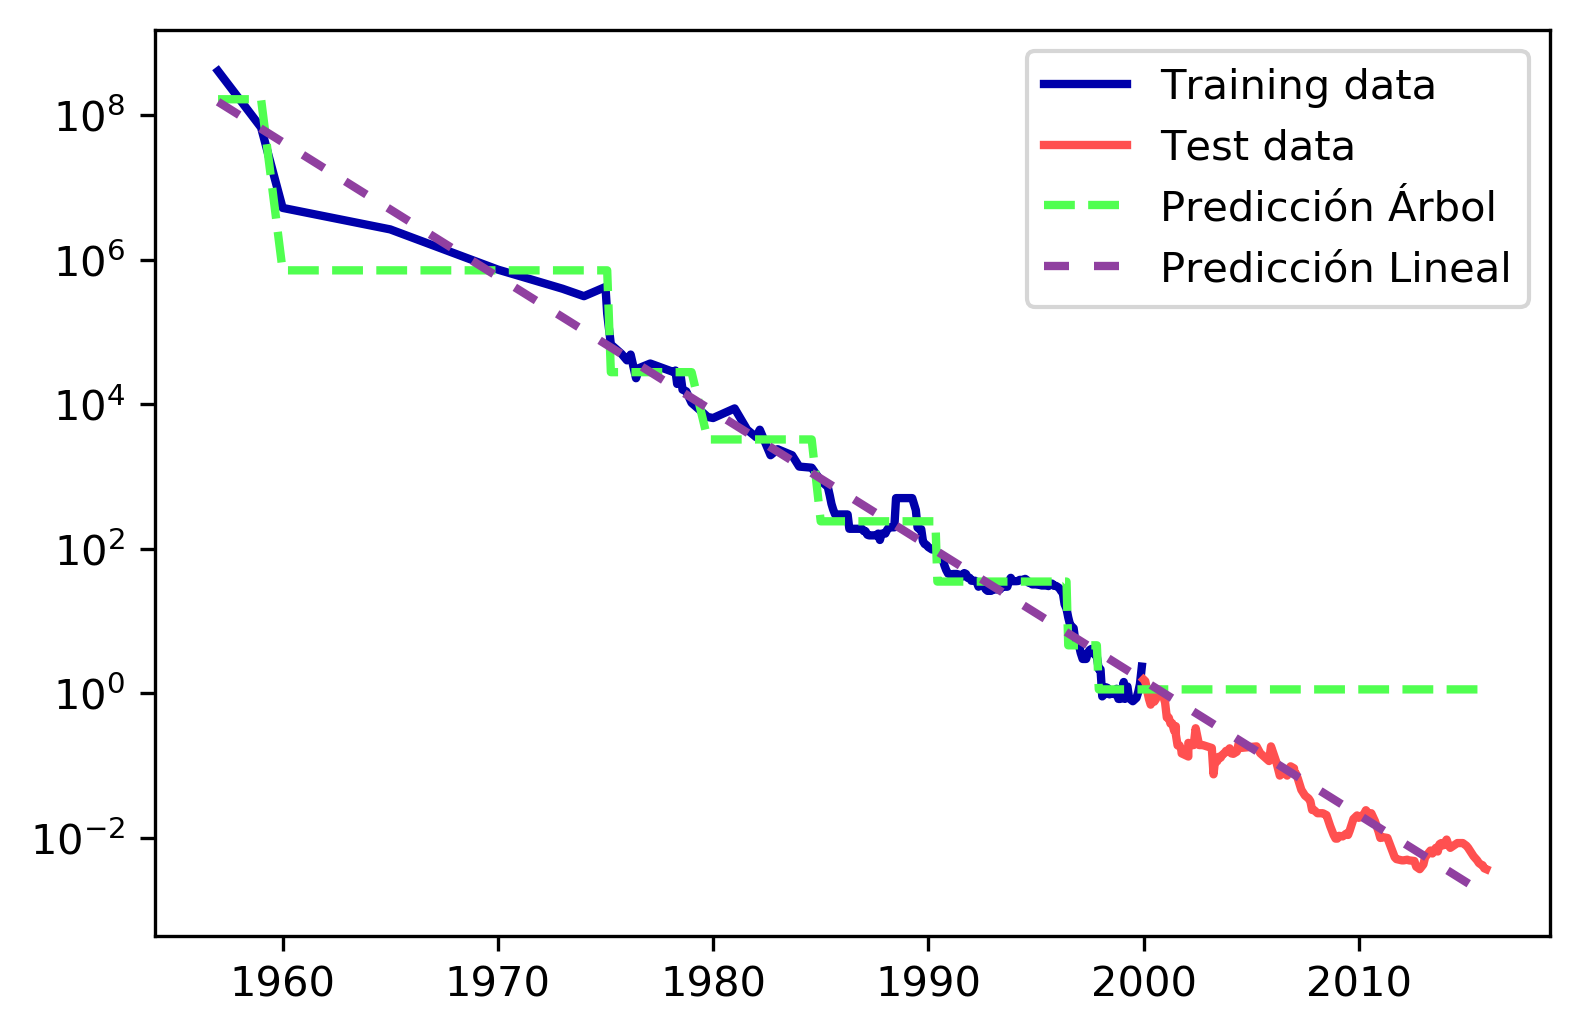

In [34]:
plt.semilogy(data_train.date, data_train.price, label="Training data")
plt.semilogy(data_test.date, data_test.price, label="Test data")
plt.semilogy(ram_prices.date, price_tree, label="Predicción Árbol")
plt.semilogy(ram_prices.date, price_lr, label="Predicción Lineal")
plt.legend()

In [ ]:
regresión lineal generaliza mejor. En el año 2000 el decision tree se queda sin datos,
no infiere, se sale del rango de datos de la prediccion, no generaliza bien
Si no va a  haber variabilidad en la escala de la caracteristica que quieres predecir
no vas a tener problema con el decision tree

**Discusión**

# Aprendizaje Supervisado con Scikit-Learn - Día 3

## Ensembles de árboles de decisión

### Análisis de los random forests

Vamos a construir un random forest con cinco árboles sobre el dataset `two_moons` que vimos anteriormente:

In [37]:
# Importamos un RandomForestClassifier del paquete ensemble
from sklearn.ensemble import RandomForestClassifier

# Importamos make_moons
from sklearn.datasets import make_moons

# Usa make moons con 100 muestras
X,y= make_moons(n_samples=100,noise=0.25,random_state=42)
# Haz el split test / training
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,random_state=42)

# Instancia y entrena un random forest con 5 estimadores
forest = RandomForestClassifier(n_estimators=5,random_state=42)
forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

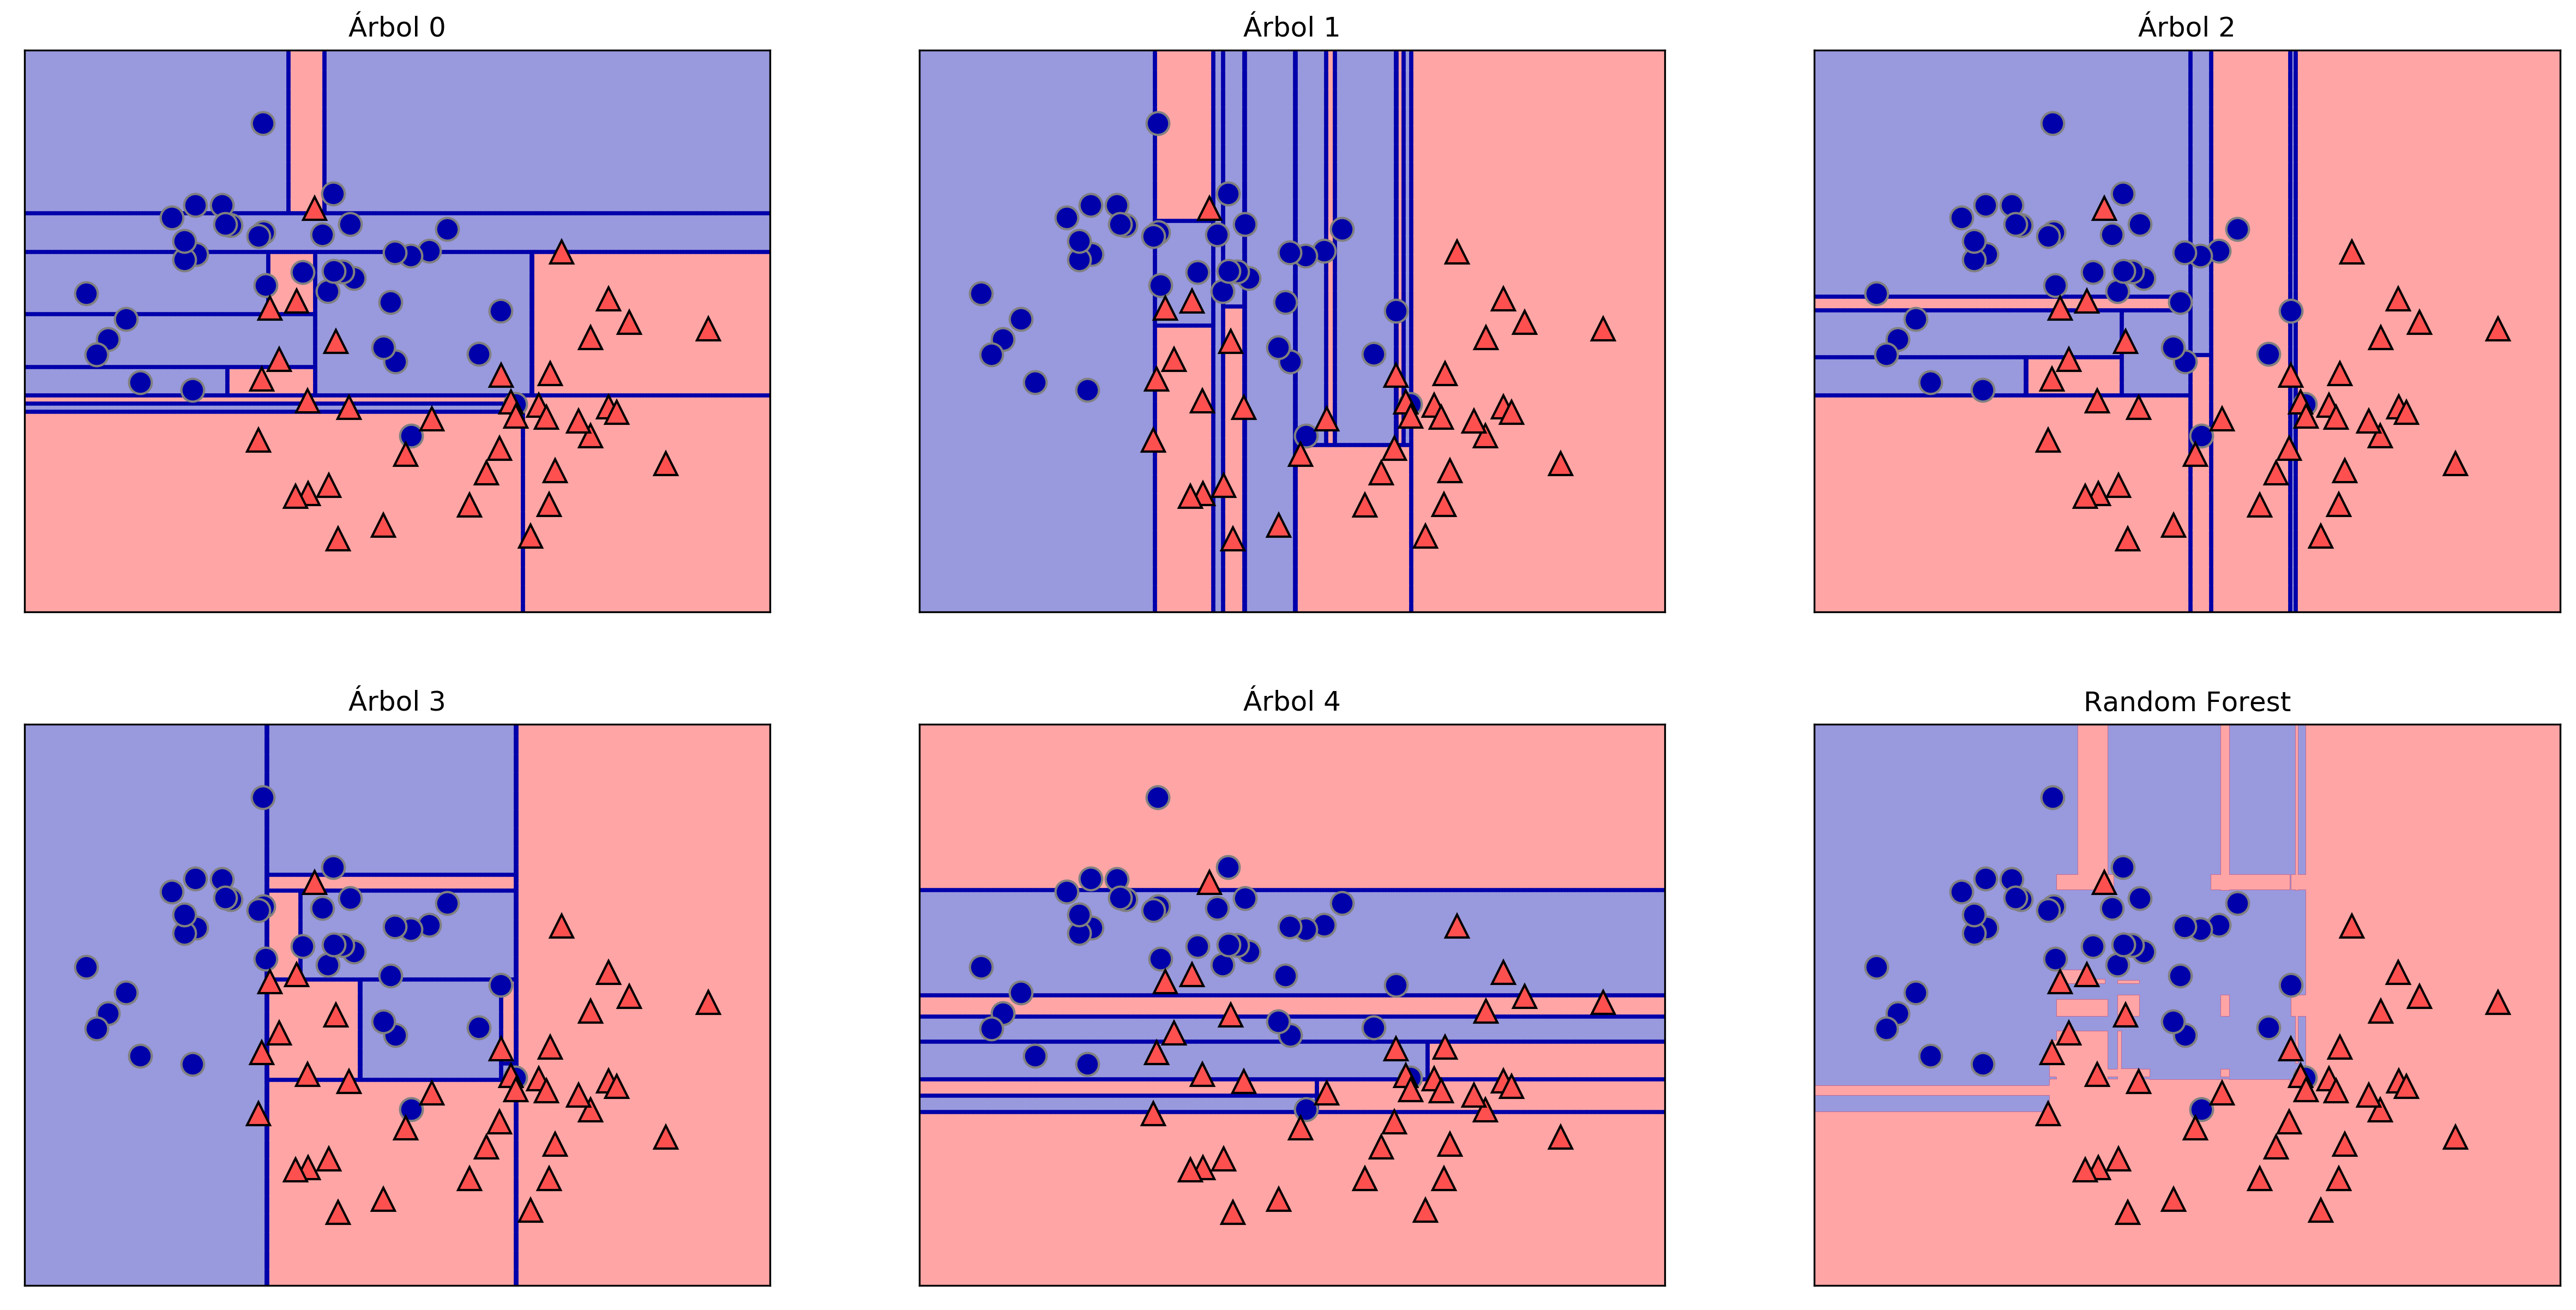

In [38]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
# ravel(): devuelve un array aplanado de elementos contiguos
# Pasamos los árboles con el atributo _estimators_ a una 
# función visualizadora
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("Árbol {}".format(i))
    mglearn.plots.plot_tree_partition(X_train, y_train, tree, ax=ax)
    
mglearn.plots.plot_2d_separator(forest, X_train, fill=True, ax=axes[-1, -1],
                                alpha=.4)
axes[-1, -1].set_title("Random Forest")
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)

In [ ]:
visualizacion del boobtrapping que estamos haciendo en el dataset
el random forest comete menos errores y generaliza mejor que los casos particulares

**Discusión**

Pongamos un ejemplo más y construyamos una random forest de 100 árboles sobre el dataset de cancer de mama:

In [44]:
# Partimos nuestro cancer dataset
X_train,X_test,y_train,y_test=train_test_split(cancer.data,cancer.target,
                                               stratify=cancer.target,random_state=42)

# Instanciamos y entrenamos un bosque con 100 estimadores
forest= RandomForestClassifier(n_estimators=100,random_state=42)
forest.fit(X_train,y_train)

# Muestra las precisiones de los dos sets de training y test
print('Precisión en training:',forest.score(X_train,y_train))
print('Precisión en test:',forest.score(X_test,y_test))

Precisión en training: 1.0
Precisión en test: 0.958041958041958


In [ ]:
resultado bueno, mejor que el de linear regresion de más arriba en este dataset

**Discusión**

Visualizamos las importancias de las características:

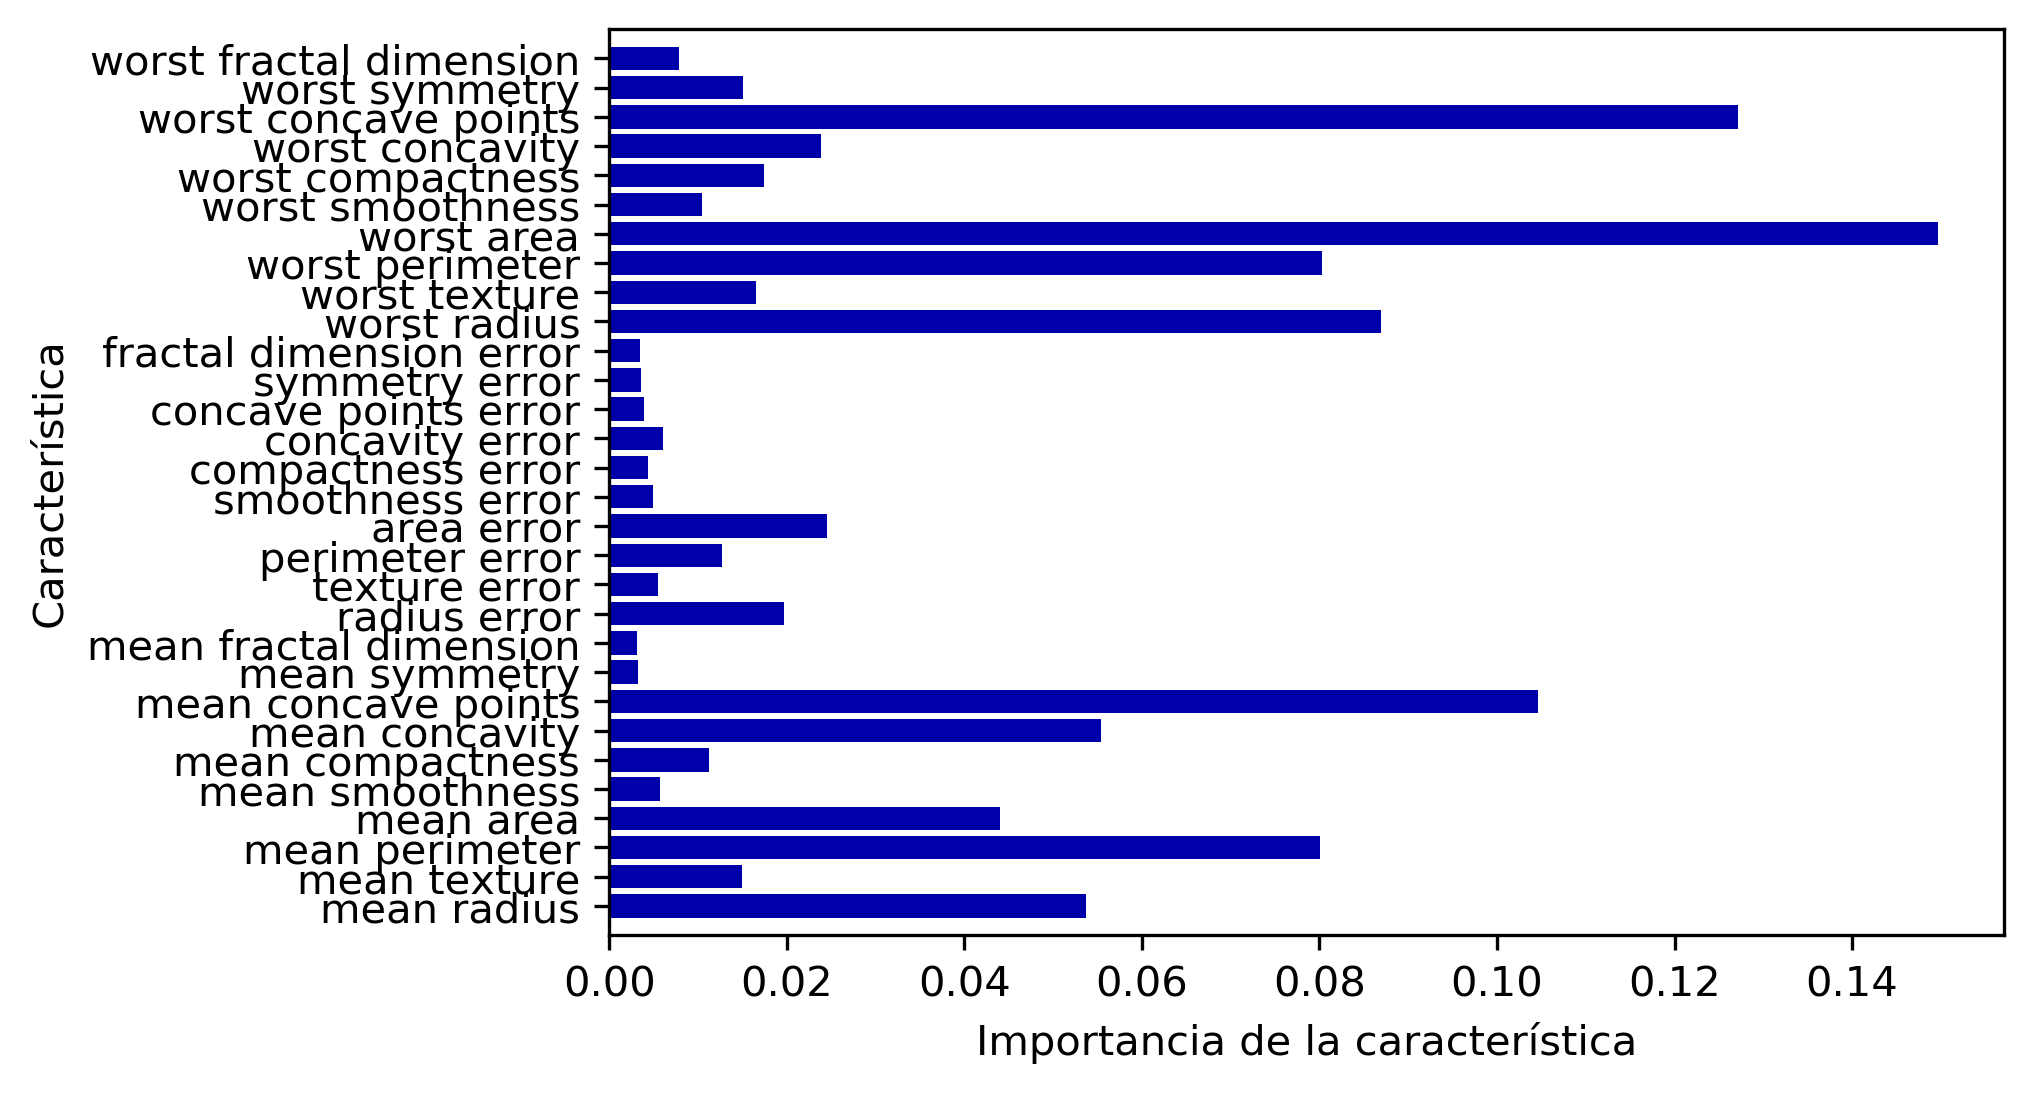

In [45]:
plot_feature_importances_cancer(forest)

**Discusión**

### Análisis de las Gradient Boosting Machines

Veamos un ejemplo de uso de `GradientBoostingClassifier` en el dataset de cáncer de mama. Por defecto, se usan 100 árboles de un máximo de tres niveles de profundidad y un learning rate de 0.1:

In [47]:
# Importamos GradientBoostingClassifier del mismo módulo ensemble
from sklearn.ensemble import GradientBoostingClassifier

# Hacemos split train y test
X_train,X_test,y_train,y_test=train_test_split(cancer.data,cancer.target,
                                               stratify=cancer.target,random_state=42)

# Instanciamos y entrenamos el modelo
gbrt = GradientBoostingClassifier(random_state=42)
gbrt.fit(X_train,y_train)

# Visualizamos las precisiones de ambos sets con 3 decimales
print('Precisión training:',gbrt.score(X_train,y_train))
print('Precisión test:',gbrt.score(X_test,y_test))

Precisión training: 1.0
Precisión test: 0.958041958041958


In [ ]:
quiza hay sobreajuste, no lo sabemos

**Discusión**

In [48]:
# Reentrenamos aplicando prunning
# Instanciamos y entrenamos el modelo
gbrt = GradientBoostingClassifier(random_state=42,max_depth=1)
gbrt.fit(X_train,y_train)

# Visualizamos las precisiones de ambos sets con 3 decimales
print('Precisión training:',gbrt.score(X_train,y_train))
print('Precisión test:',gbrt.score(X_test,y_test))

Precisión training: 0.9882629107981221
Precisión test: 0.958041958041958


In [ ]:
No hemos conseguido nada. Hacer pruning es mejor que nada, porque estoy generalizando
un poco mejor, training es algo más bajo

In [49]:
# Reentrenamos modificando la tasa de aprendizaje
# Instanciamos y entrenamos el modelo
gbrt = GradientBoostingClassifier(random_state=42,learning_rate=0.01)# mas pequeño por lo que aumentamos la frecuencia
gbrt.fit(X_train,y_train)

# Visualizamos las precisiones de ambos sets con 3 decimales
print('Precisión training:',gbrt.score(X_train,y_train))
print('Precisión test:',gbrt.score(X_test,y_test))

Precisión training: 0.9882629107981221
Precisión test: 0.9370629370629371


In [ ]:
Peor resultado que el anterior.Nos ha venido mejor para generalizar tocar la profundizar de
los arboles

Ambos métodos de decremento de la complejidad del modelo reducen la precisión en el training set, como era de esperar. En este caso, bajar la profundidad máxima del árbol mejora bastante el modelo, mientras que bajar el learning rate solo mejora la generalización levemente.

Como en los otros casos, vamos a ver cómo se están asignando las importancias de las características ahora:

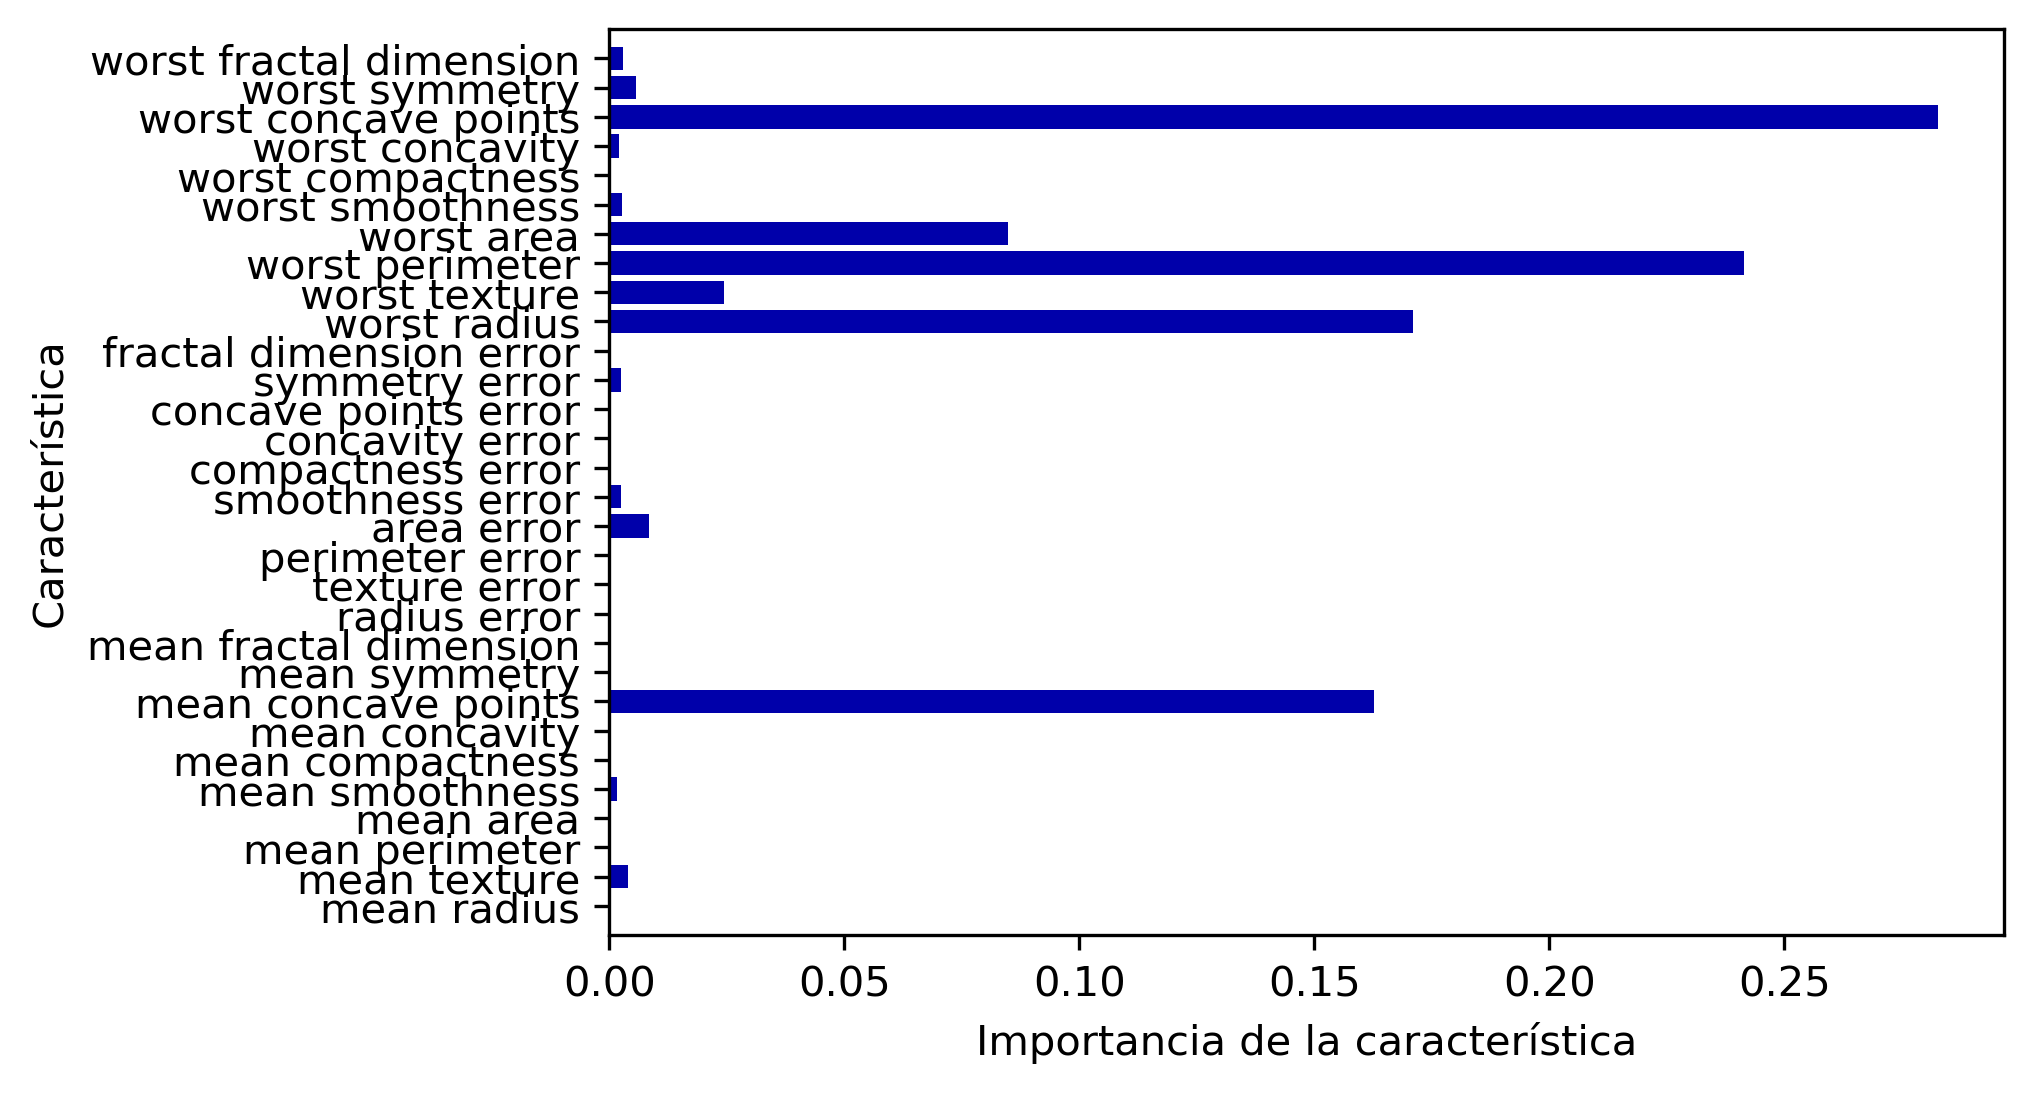

In [50]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

plot_feature_importances_cancer(gbrt)

In [ ]:
hay caracteristicas que desaparecen completamente pese a tener gran numero de arboles


In [ ]:
Primero aplicamos un random forest, si vemos que tenemos margen de mejora
probamos con el boosting machine, tocando primero prunning y luego learning_rate

**Discusión**

## Kernelized Support Vector Machines
### Modelos lineales con características no lineales

Hemos visto que los modelos lineales pueden ser bastante limitados en espacios 2D, ya que las lineas e hiperplanos tienen una flexibilidad limitada. Una manera de hacer un modelo lineal más flexible, como hemos visto, es aplicar ingeniería de características añadiendo interacciones o procesamiento polinómico de las características de entrada.

Echemos un vistazo al dataset sintético que usamos para analiza la importancia de las características previamente:

Text(0, 0.5, 'Feature 1')

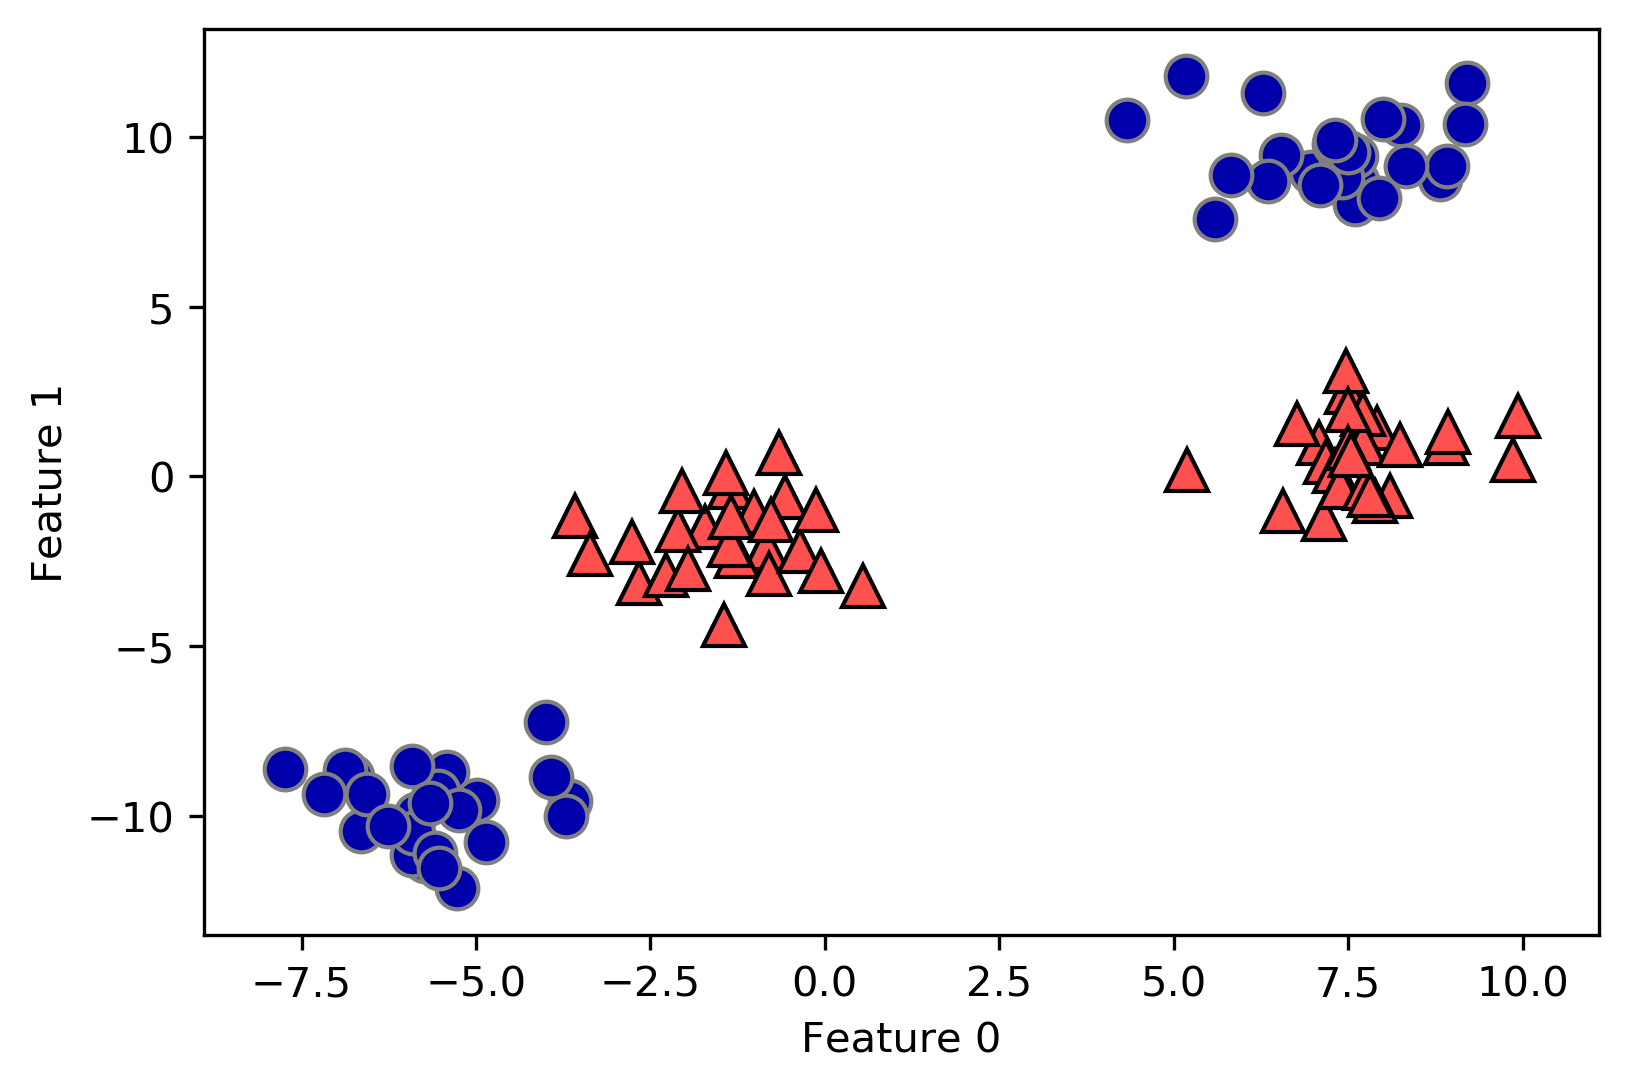

In [51]:
from sklearn.datasets import make_blobs
X, y = make_blobs(centers=4, random_state=8)
y = y % 2

mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Text(0, 0.5, 'Caracteristicas 1')

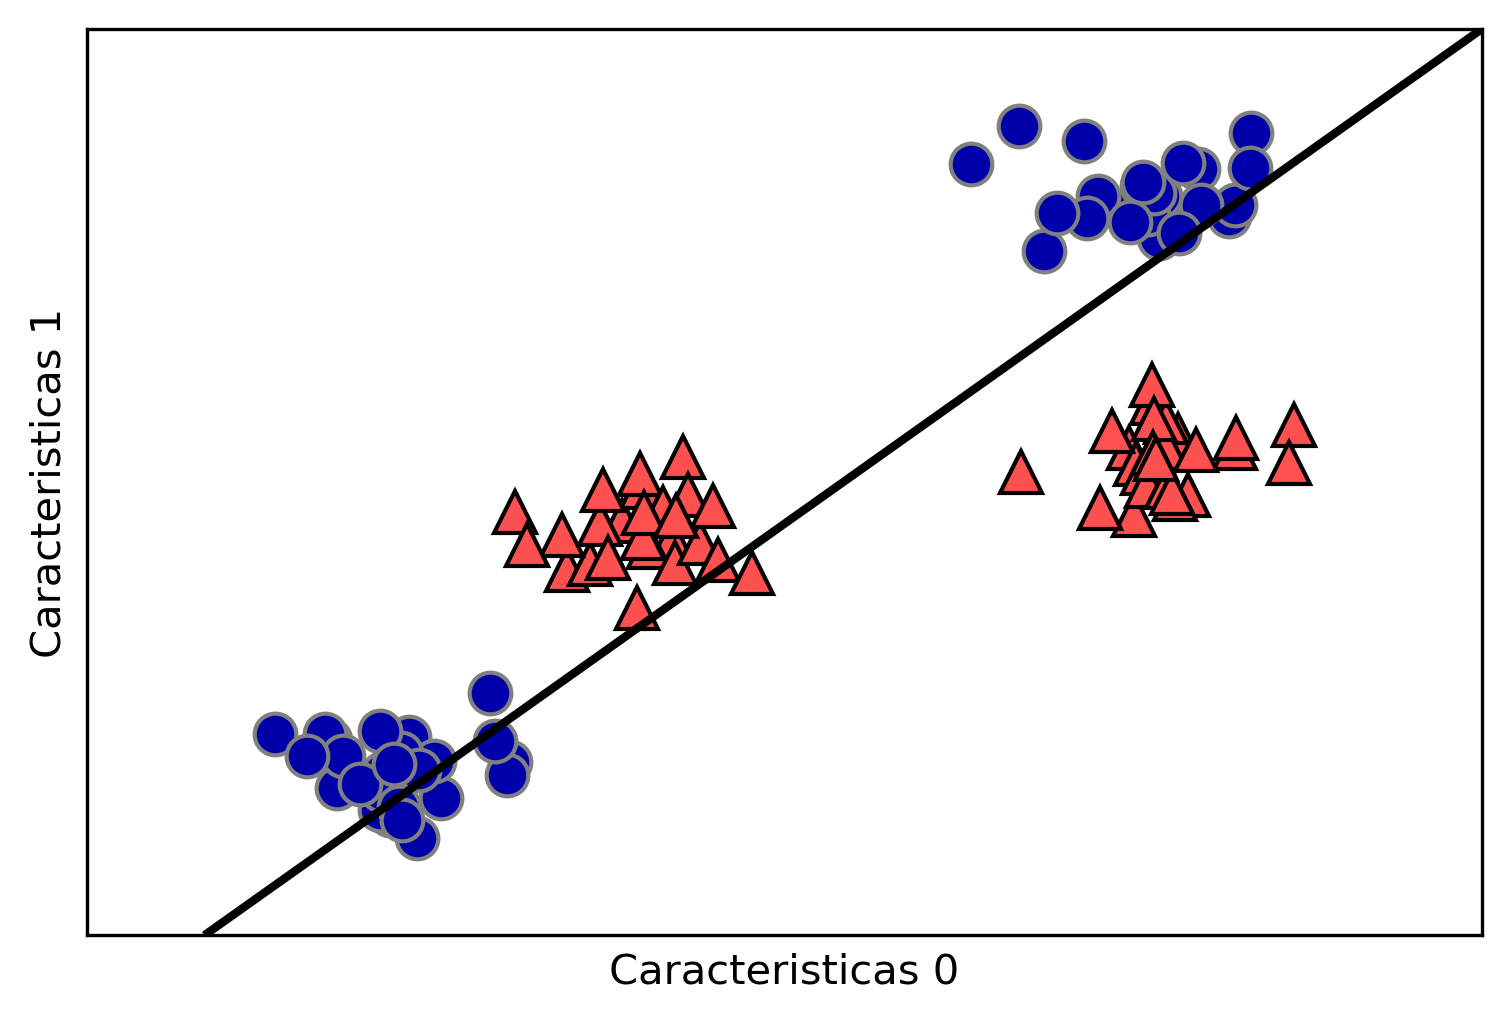

In [54]:
# Hacer una clasificación lineal sobre el dataset
from sklearn.svm import LinearSVC
lineal_svm=LinearSVC(max_iter=10000).fit(X,y)
mglearn.plots.plot_2d_separator(lineal_svm,X)
mglearn.discrete_scatter(X[:,0],X[:,1],y)
plt.xlabel('Caracteristicas 0')
plt.ylabel('Caracteristicas 1')


In [ ]:
la regresión lineal hace lo que puede, la frontera de decisión que propone no sirve

Extendemos la características

Text(0.5, 0, '(característica 1)ˆ2')

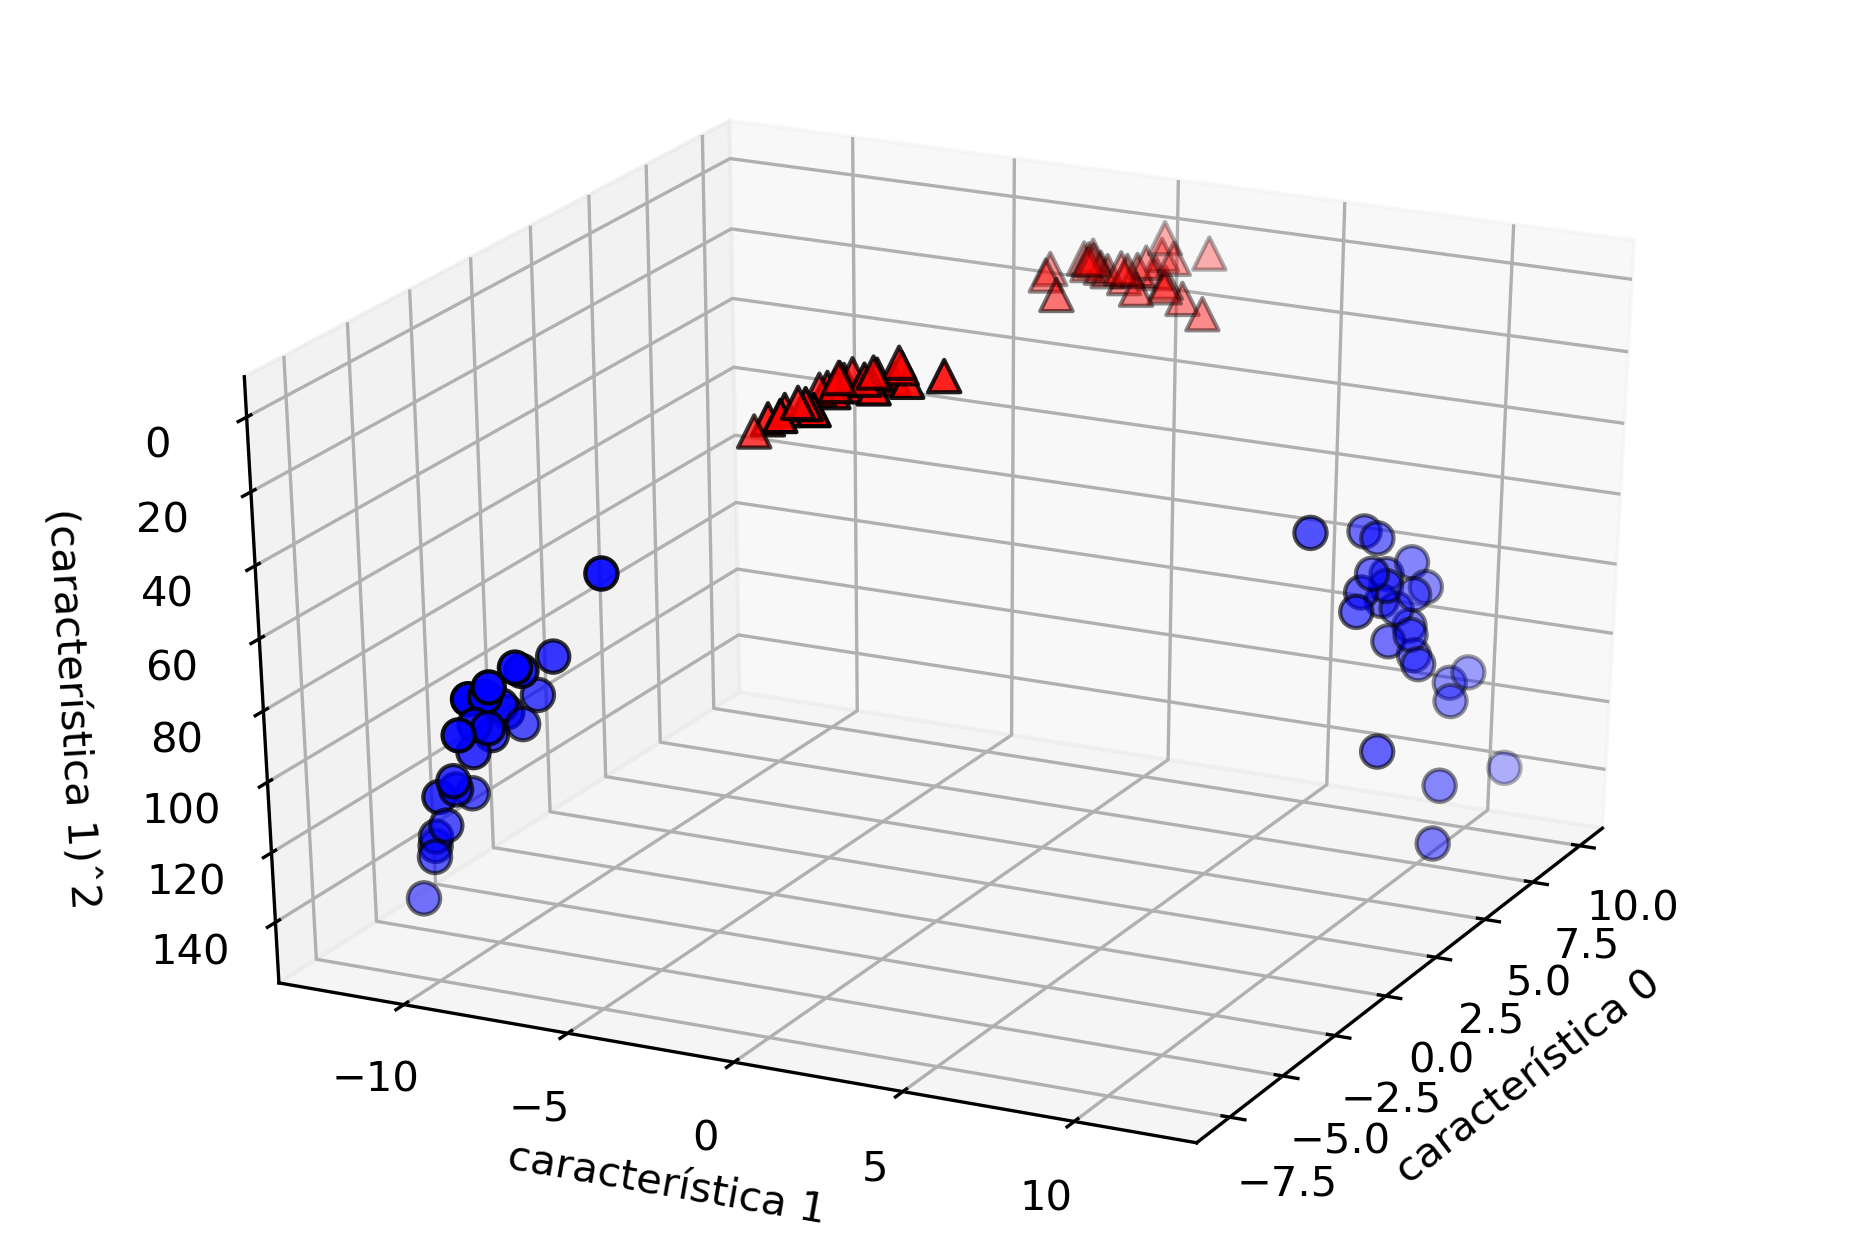

In [55]:
# Añadimos la segunda característica elevada al cuadrado
X_new = np.hstack([X, X[:, 1:] ** 2])


from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()
# Visualizamos en 3D
ax = Axes3D(figure, elev=-152, azim=-26)
# Pintamos todos los puntos con y==0, y luego con y == 1
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.set_xlabel("característica 0")
ax.set_ylabel("característica 1")
ax.set_zlabel("(característica 1)ˆ2")

Usamos ahora un modelo lineal

Text(0.5, 0, '(Característica 1)^2')

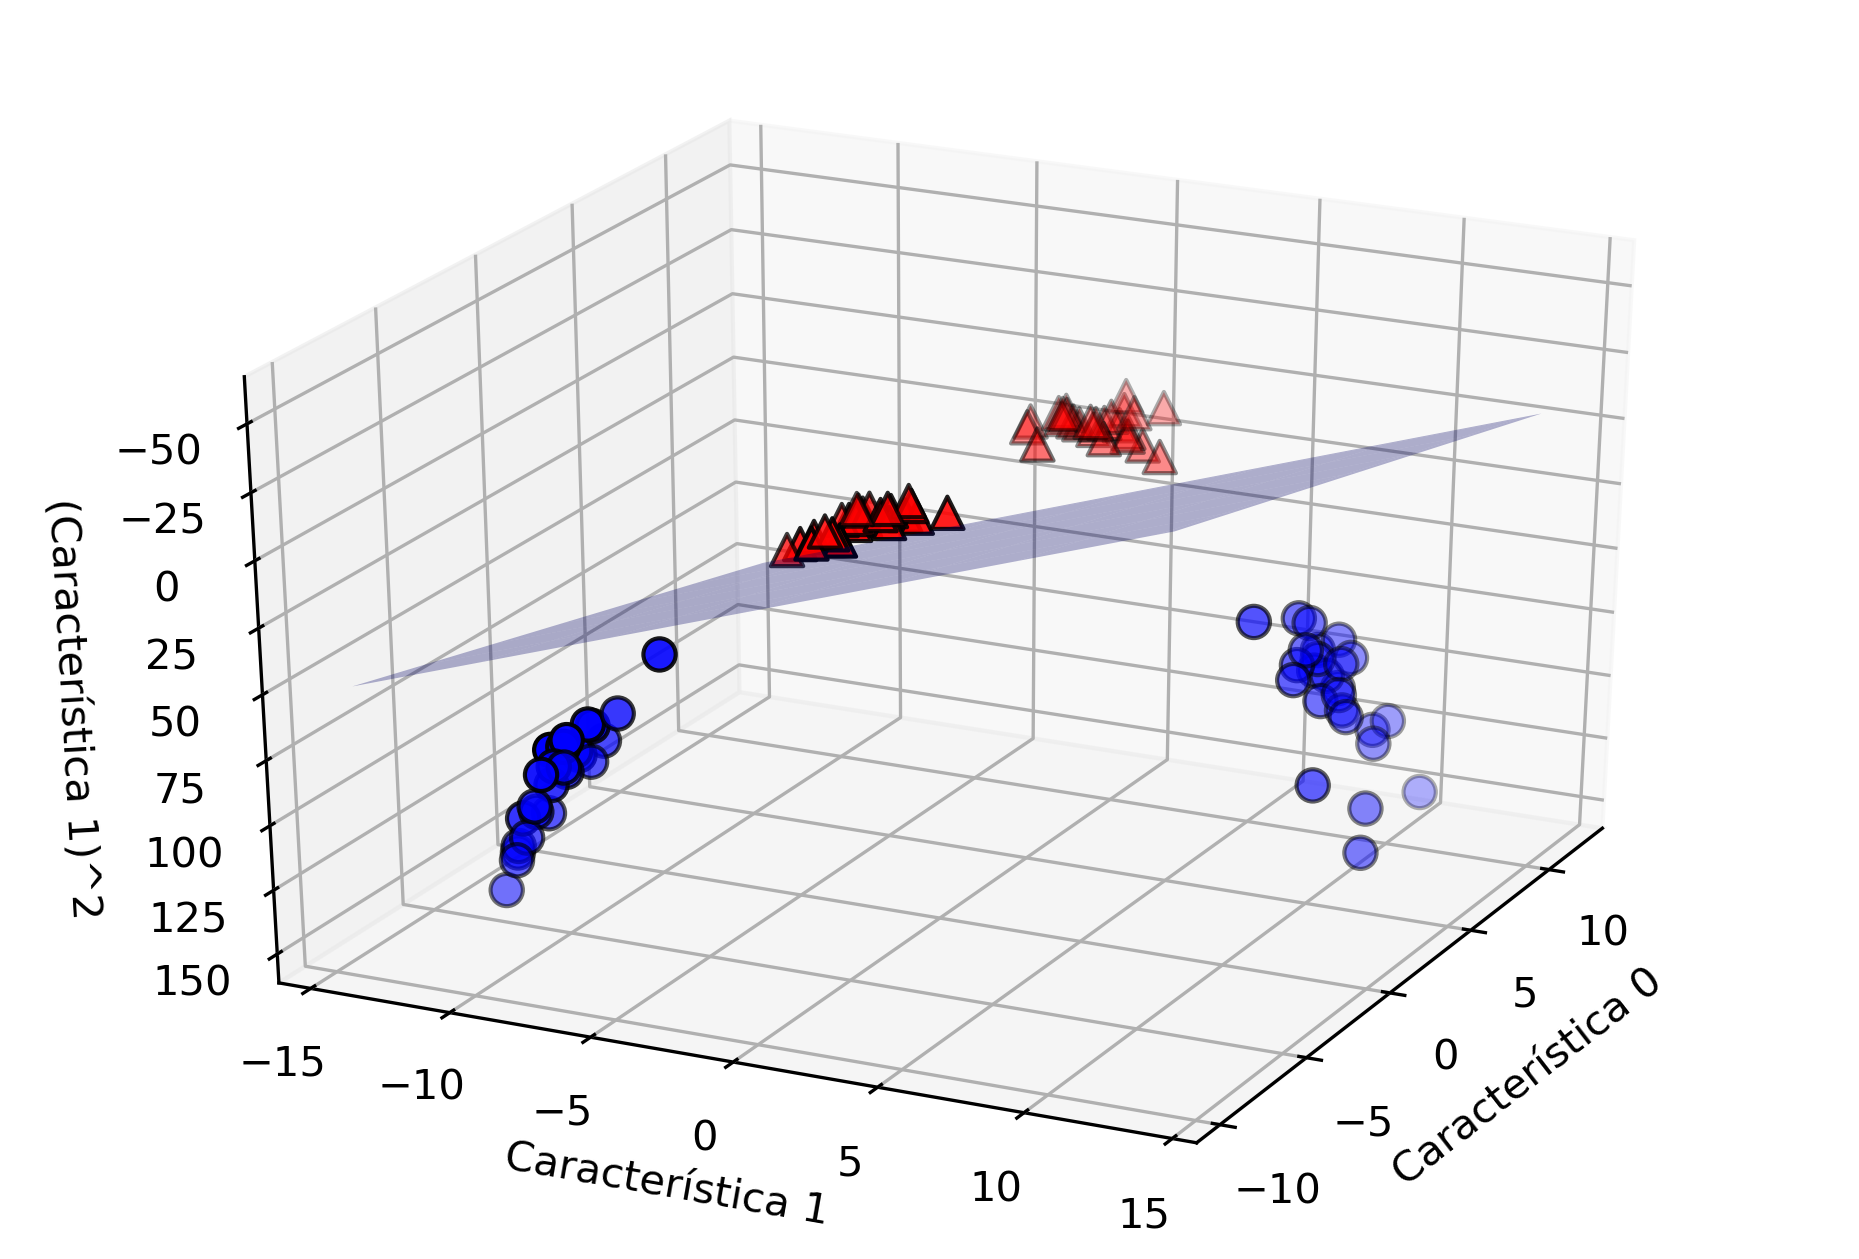

In [56]:
# Entrena de nuevo un modelo lineal con estas nuevas características
linear_svm_3d = LinearSVC(max_iter=10000).fit(X_new,y)

# Caputramos los coeficientes y el corte con los ejes
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_
#funciónravel es para aplanar#

# Mostramos la frontera de decisión lineal
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')

ax.set_xlabel("Característica 0")
ax.set_ylabel("Característica 1")
ax.set_zlabel("(Característica 1)^2")

Text(0, 0.5, 'Característica 1')

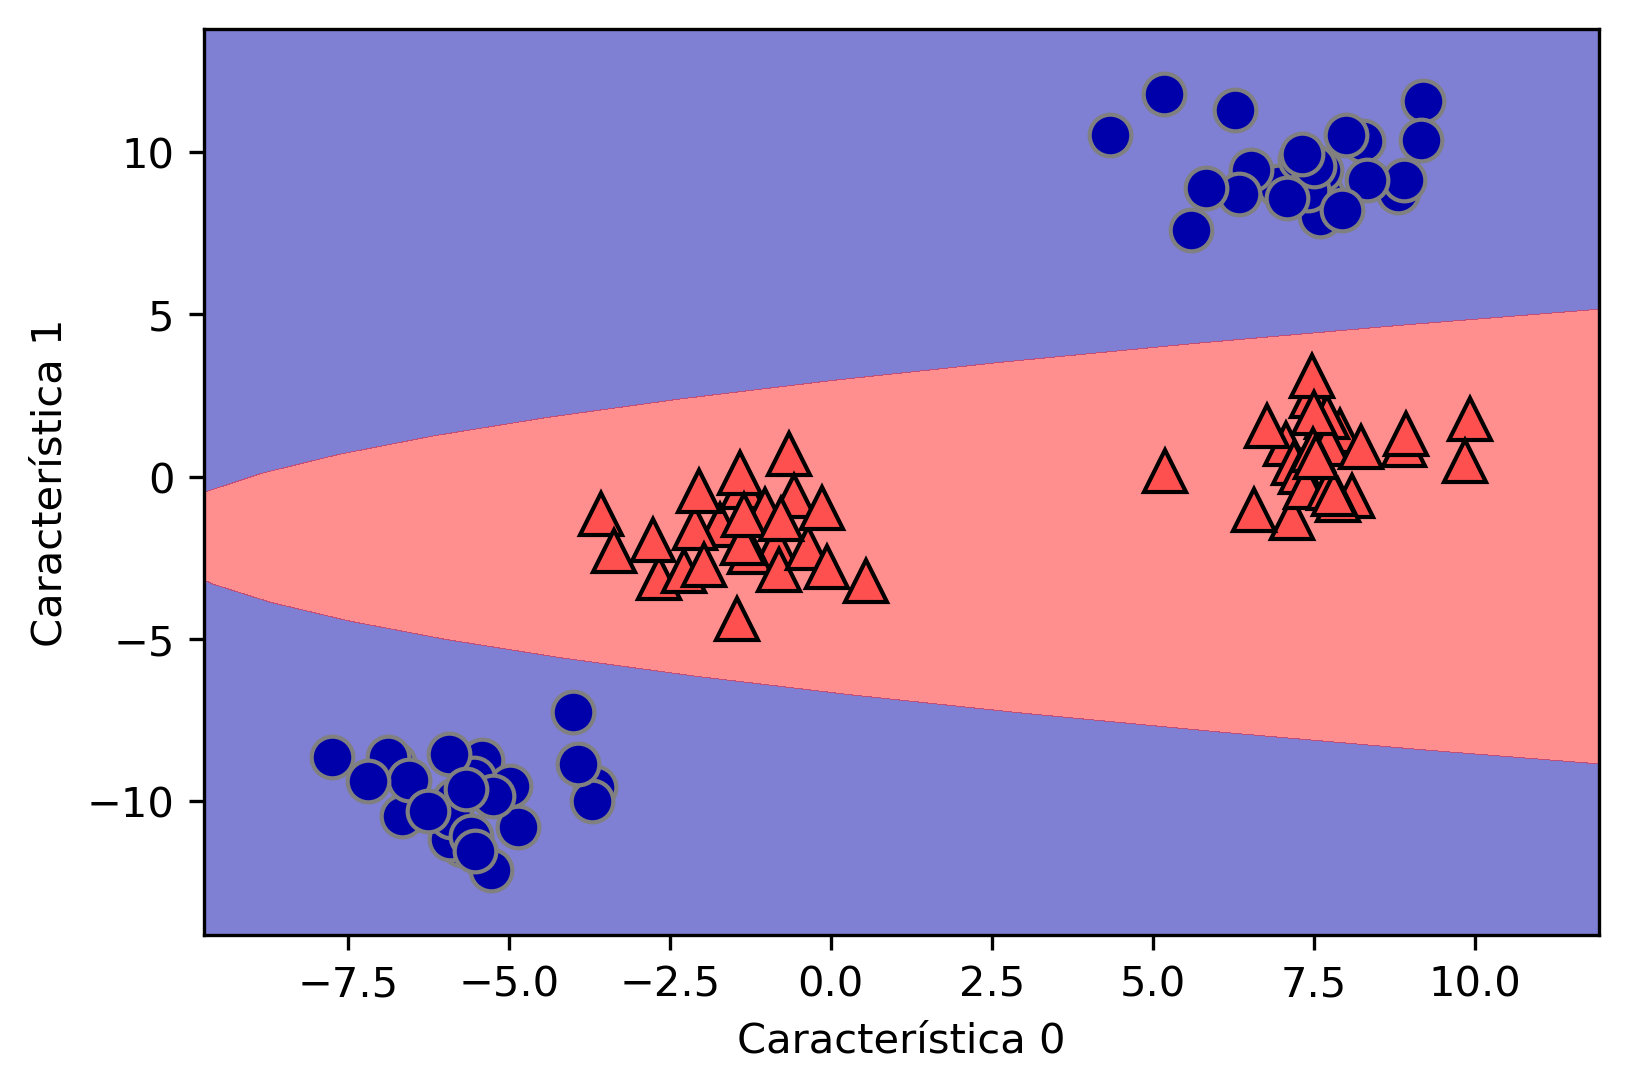

In [57]:
# Usamos la función de decisión (decision_function) sobre el modelo

# Tenemos una nueva característica más, ahora extendemos el meshgrid
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()],
             cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Característica 0")
plt.ylabel("Característica 1")

In [ ]:
SVM aumenta la dimensión de las caracteristicas, partiendo de un modelo lineal,
para poder calcular una frontera/separación/clasificador eficiente

### El truco del Kernel

### Análisis de Support Vector Machines
\begin{align*}
\end{align*}

Text(0, 0.5, 'Característica 1')

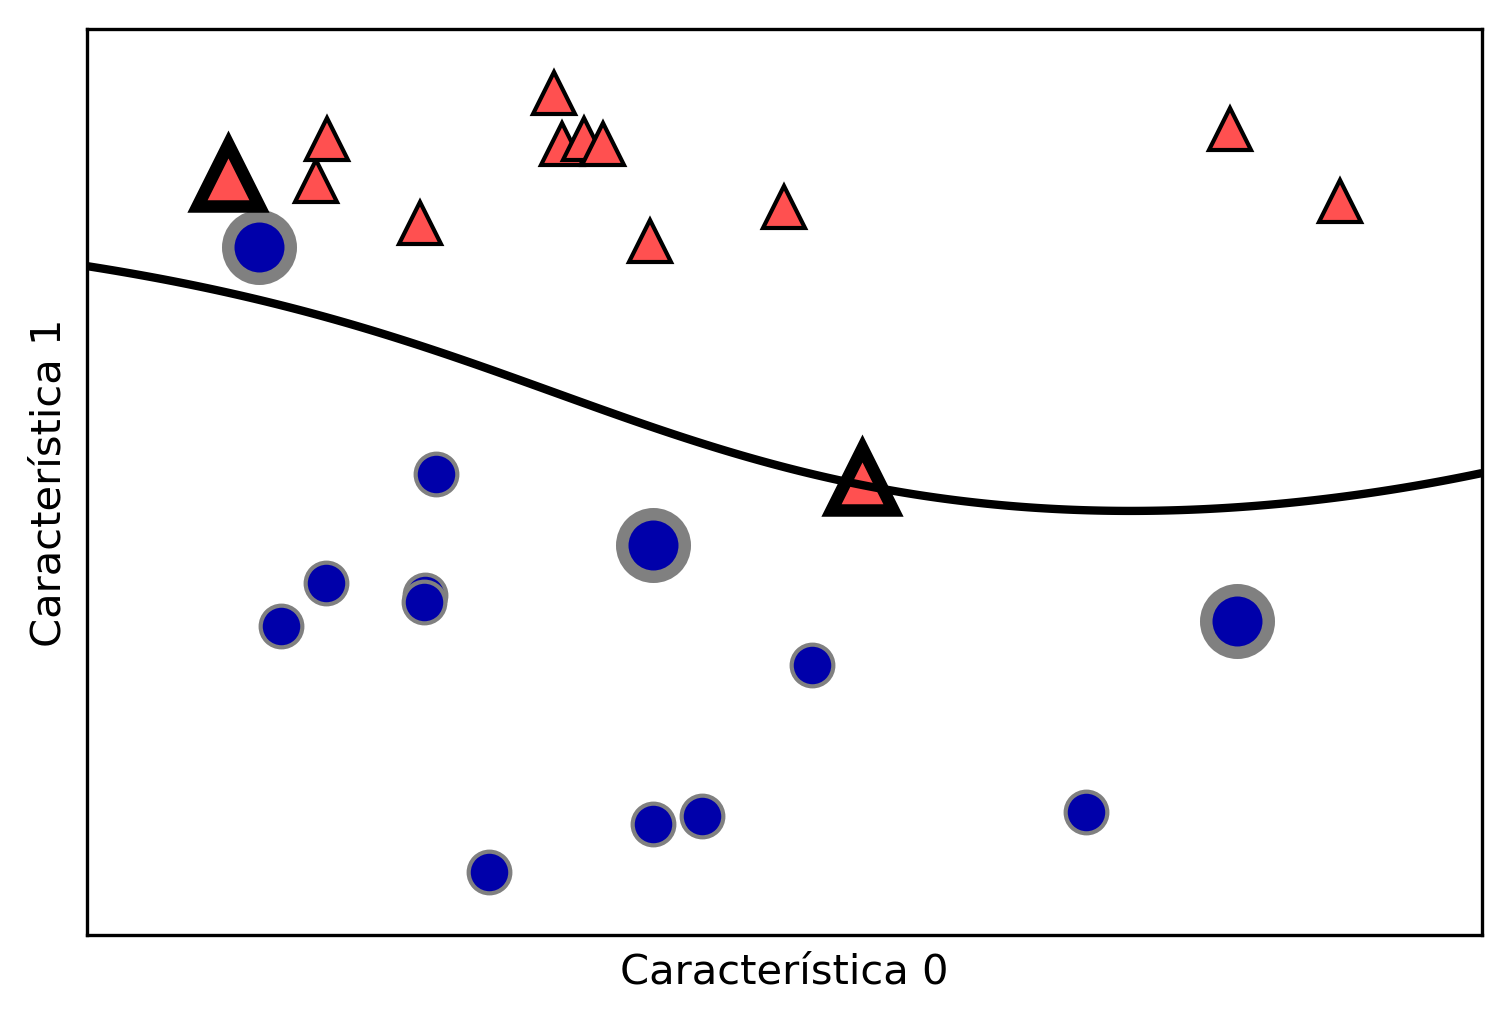

In [59]:
# Importamos SVC desde el módulo svm
from sklearn.svm import SVC # ya no es linear

# Hacemos un dataset levemente modificado
X, y = mglearn.tools.make_handcrafted_dataset()                                                                  

# Instanciamos y entrenamos un SVC con RBF, C=10 y gamma=0.1
svm=SVC(kernel='rbf',C=10,gamma=0.1).fit(X,y)

# Pintamos el separador
mglearn.plots.plot_2d_separator(svm, X, eps=.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)

# Pintamos los vectores soporte
sv = svm.support_vectors_
# Las etiquetas de clase de los vectores vienen dadas por el signo de dual_coef
sv_labels = svm.dual_coef_.ravel() > 0
mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)
plt.xlabel("Característica 0")
plt.ylabel("Característica 1")

In [ ]:
tiene buena pinta, los que estan en negrita son vectores soporte, esta ajustando, pero
tiene algunas missclasificaciones lo que quiere decir que generaliza

En este caso, SMV produce una curva suave. Hemos ajustado dos parámetros, $C$ y $\gamma$, que vamos a ver ahora en detalle:

### Ajuste de los parámetros de SVM

Vamos a ir variando $\gamma$ y $C$:

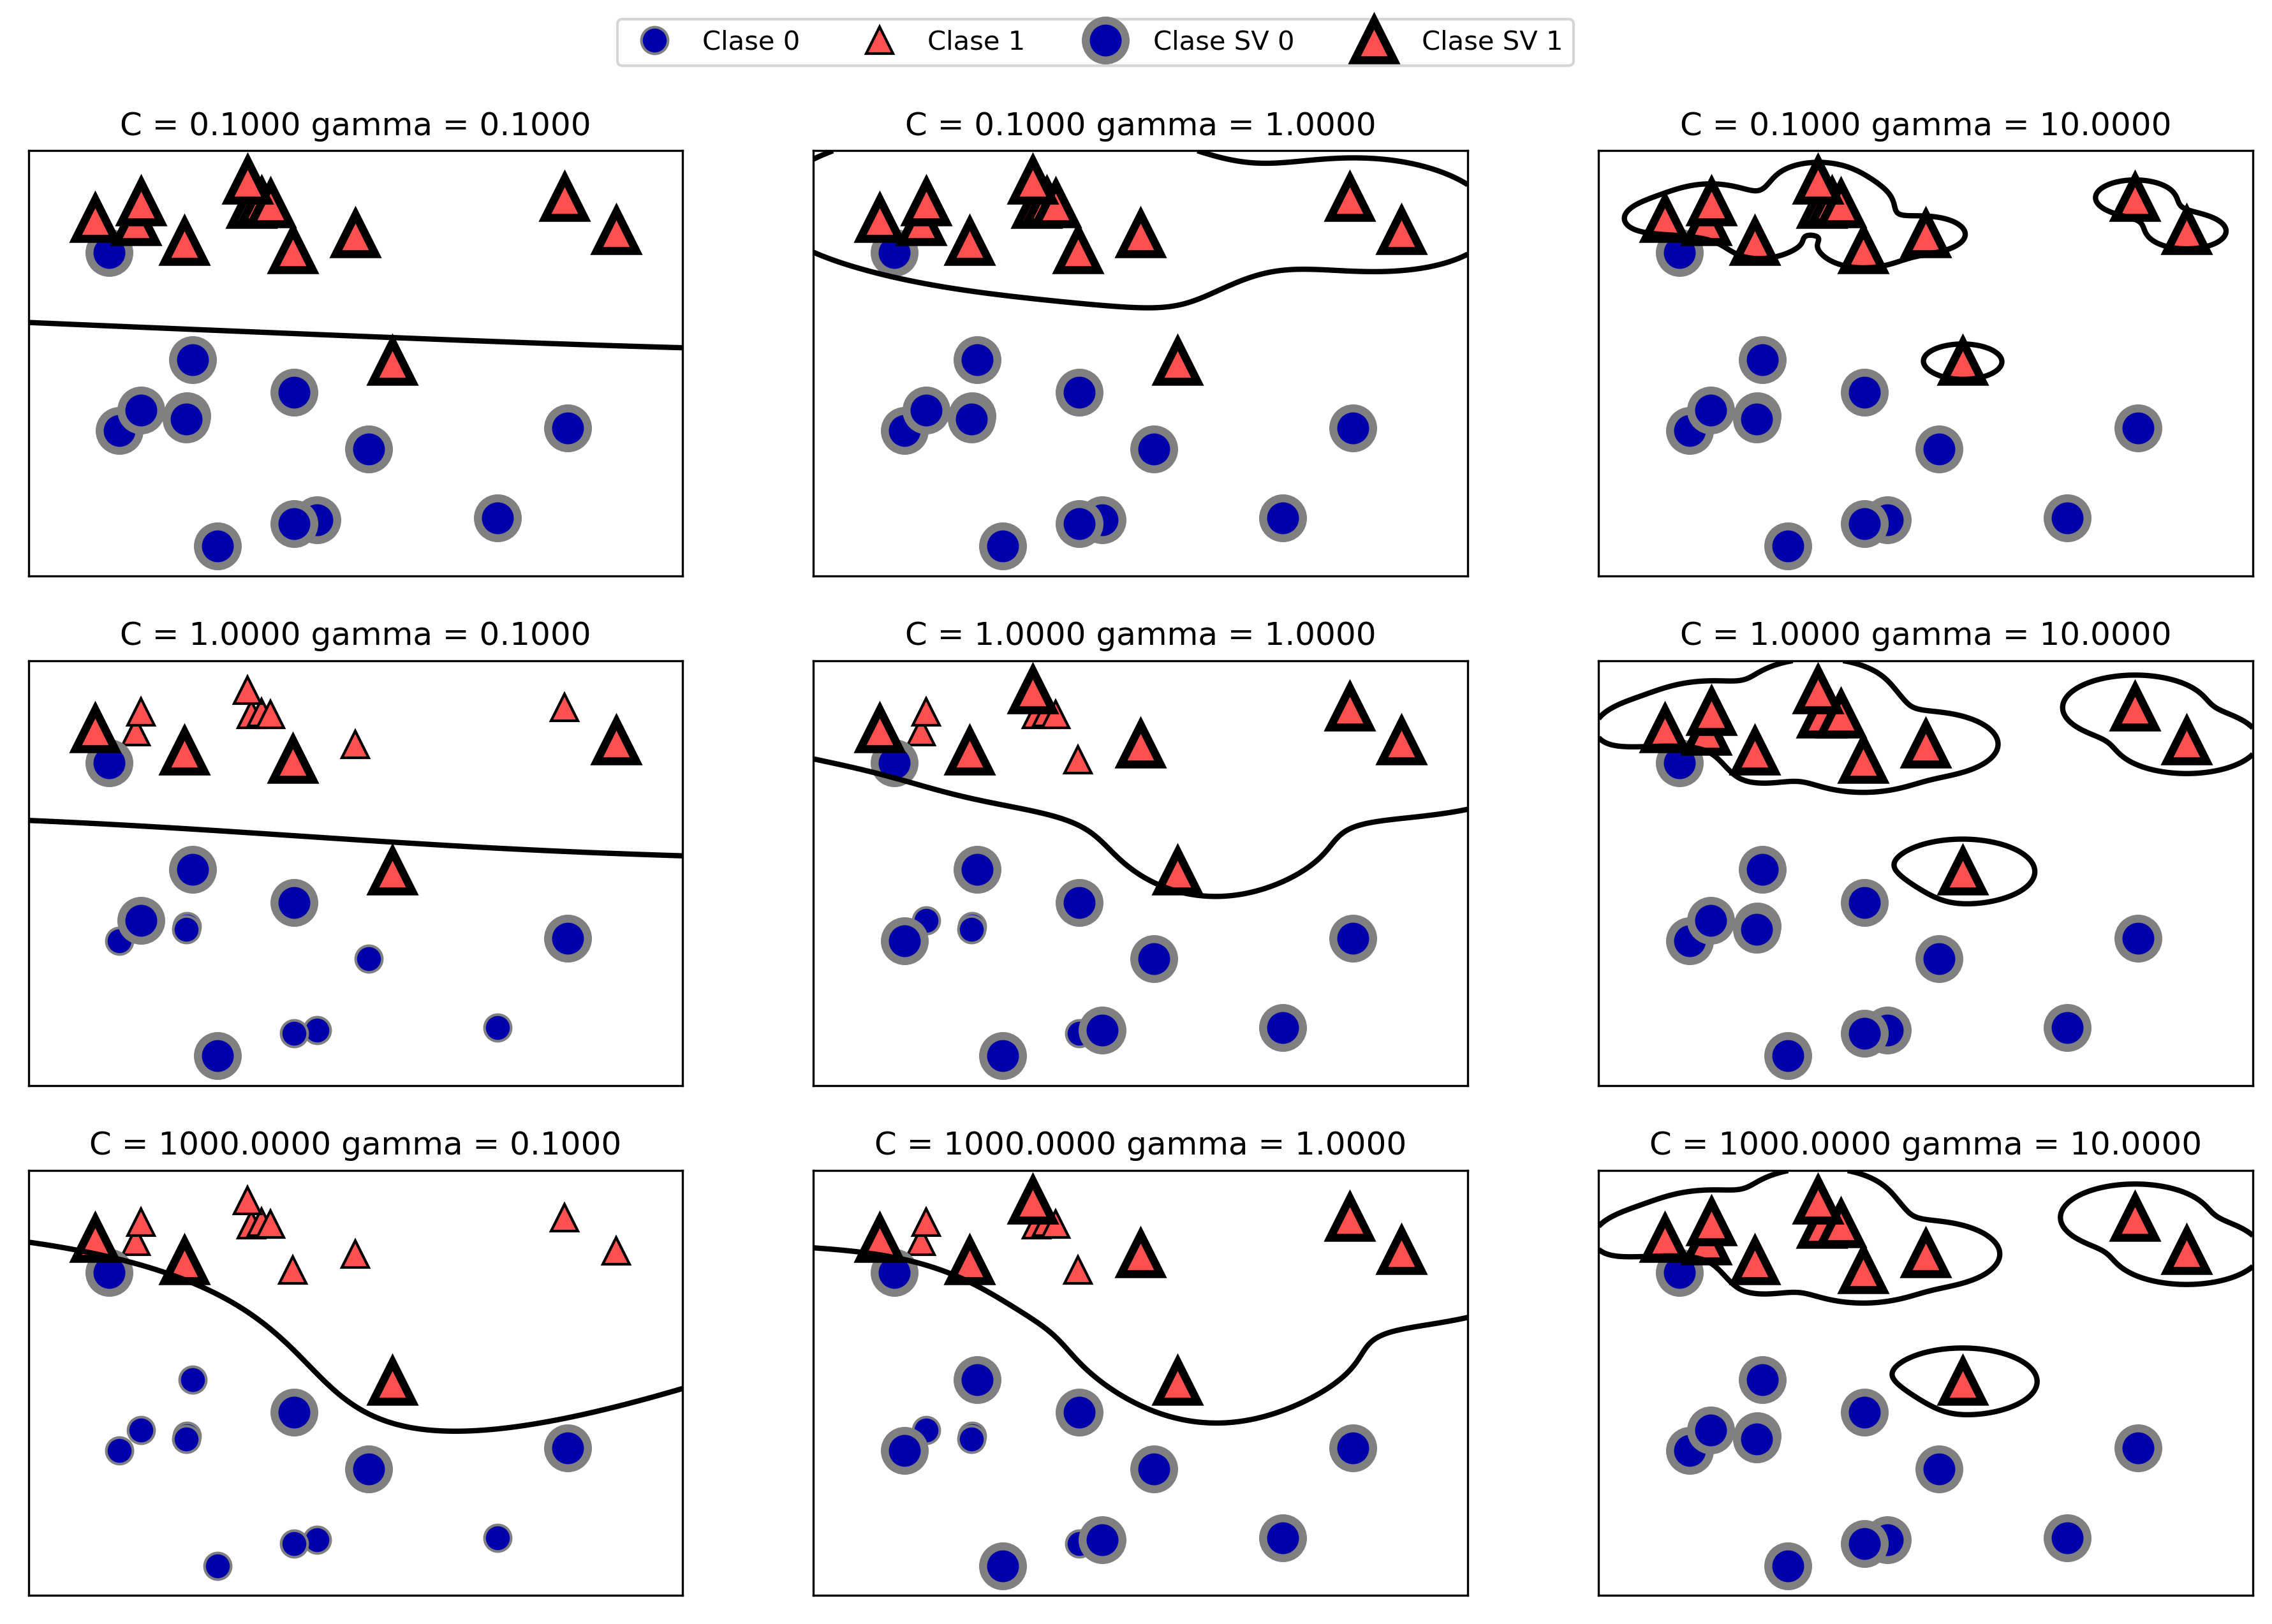

In [60]:
# Hacemos 6 subplots
fig, axes = plt.subplots(3,3,figsize=(15,10))

# Iteramos para valores de C=0.1, 1 y 1000 en filas, y gamma -1, 0, 1 en columnas
for ax,C in zip(axes,[-1,0,3]):
    for a,gamma in zip(ax,range(-1,2)):
        # Nos apoyamos en una función ya definida para pintar los SVMs
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)
        
axes[0, 0].legend(["Clase 0", "Clase 1", "Clase SV 0", "Clase SV 1"],
                  ncol=4, loc=(.9, 1.2))

In [ ]:
columna de la derecha overfittin
Valor C alto regulariza menos
valor gamma-->

**Discusión**

Apliquemos ahora SVM con kernel RBF al Breast Cancer dataset. Por defecto, $C=1$ y $\gamma = \frac{1}{\mathrm{n\_features}}$:

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

# Partimos en test y training
X_train,X_test,y_train,y_test=train_test_split(cancer.data,cancer.target,
                                               stratify=cancer.target,random_state=42)

# Instanciamos y entrenamos un SVC
svc=SVC(gamma='auto').fit(X_train,y_train) # gamma automatico

# Mostramos las precisiones
print(svc.score(X_train,y_train))
print(svc.score(X_test,y_test))

1.0
0.6293706293706294


In [ ]:
tenemos que ajustar los parametros, mal modelo, modelos muy sensibles a como estan 
las caracteristicas/parametros

**Discusión**

Echemos un vistazo a los valores mínimos y máximos de cada característica, graficados en espacio logarítmico:

Text(0, 0.5, 'magnitud de la caracteristica')

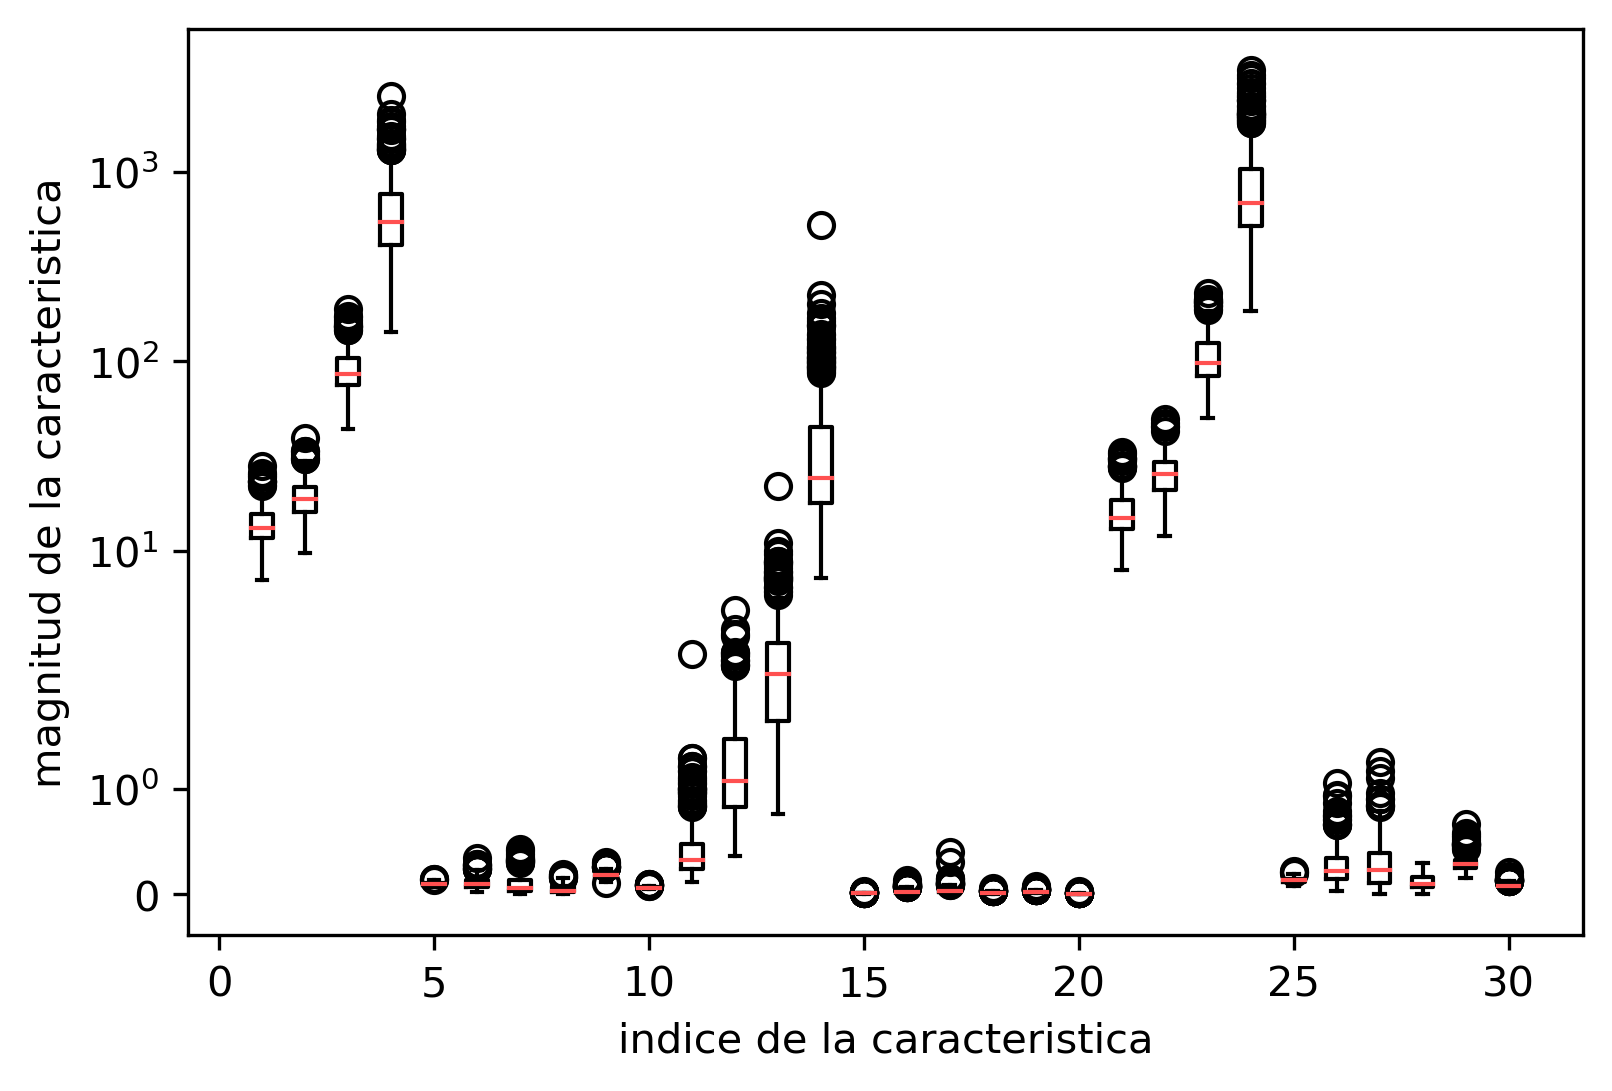

In [65]:
# Usamos un boxplot para mostrarlos
plt.boxplot(X_train,manage_ticks=False)
plt.yscale('symlog')
plt.xlabel('indice de la caracteristica')
plt.ylabel('magnitud de la caracteristica')

**Discusión**

### Preprocesado de datos para SVMs

In [67]:
# Calculamos el valor mínimo de cada característica en el training set
min_on_training=X_train.min(axis=0)
# Calculamos el rango de cada característica (max - min) en el training set
range_on_training=(X_train-min_on_training).max(axis=0)

# Restamos el mínimo y dividimos por el rango
# después, min=0 y max=1 para cada caracterísitca
X_train_scaled=(X_train-min_on_training)/range_on_training
print(X_train_scaled.min(axis=0))
print(X_train_scaled.max(axis=0))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [69]:
# Utilizamos la misma transformación en el test set,
# usando el mínimo y el rango del training set. See Chapter 3 (unsupervised learning) for details.
# usando el mínimo y el rango del training set.
X_test_scaled=(X_test-min_on_training)/range_on_training

Con estos cambios, probamos de nuevo a entrenar y evaluar el modelo:

In [70]:
# Instanciamos y entrenamos un SVC
svc=SVC(gamma='auto').fit(X_train_scaled,y_train) # gamma automatico

# Mostramos las precisiones
print(svc.score(X_train_scaled,y_train))
print(svc.score(X_test_scaled,y_test))

0.9553990610328639
0.9440559440559441


In [ ]:
Modelo mucho mejor con esta ingeniera de caracteristicas, son muy sensibles a esto

Desde esta situación de partida, podemos intentar incrementar $C$ o $\gamma$ para ajustar con un modelo más complejo.

In [85]:
# Entrena svc on C=1000. Vamos probando
# Instanciamos y entrenamos un SVC
svc=SVC(C=100,gamma='auto').fit(X_train_scaled,y_train) # gamma automatico

# Mostramos las precisiones
print(svc.score(X_train_scaled,y_train))
print(svc.score(X_test_scaled,y_test))



0.9812206572769953
0.986013986013986
